In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
from scipy.stats import multinomial, dirichlet
import sys
from multinomial_expectation_maximizer import MultinomialExpectationMaximizer, \
    IndividualMultinomialExpectationMaximizer

In [2]:
#Function Declaration for Mapping

In [3]:
def get_individual_alpha_test(best_alpha, test_household_ids, train_household_ids):
    alpha_df = pd.DataFrame(best_alpha, index=train_household_ids)
    filtered_alpha_df = alpha_df.groupby(alpha_df.index).apply(lambda g: g.iloc[0])
    alpha_test = np.vstack([filtered_alpha_df.loc[household_id].values for household_id in test_household_ids])
    return alpha_test

run_with_gamma folder will be for global mode
run_with_gamma2 folder will be for individual mode

In [4]:
def process_with_k_mixtures_init(args):
    k, X_train, X_test, train_household_ids, test_household_ids, individual_mode = args
    print('###################################### Experiment with %i mixture components ######################################' % k)
    
    SAVE_DIR = 'run_with_gamma'
    model = MultinomialExpectationMaximizer(k, restarts=10, rtol=1e-4)
    best_train_loss, best_alpha, best_beta, best_gamma = model.fit(X_train)
    alpha_test = best_alpha

    log_likelihood = model.compute_log_likelihood(X_test, alpha_test, best_beta)
    bic = model.compute_bic(X_test, best_alpha, best_beta, log_likelihood)
    icl_bic = model.compute_icl_bic(bic, best_gamma)

    print('log likelihood for k=%i : %f' % (k, log_likelihood))
    print('bic for k=%i : %f' % (k, bic))
    print('icl bic for k=%i : %f' % (k, icl_bic))
    pickle.dump((best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma),
                open(os.path.join(SAVE_DIR, 'best_params_%i.p' % k), 'wb'))

In [5]:
def process_with_k_mixtures(args):
    k, X_train, X_test, train_household_ids, test_household_ids, individual_mode = args
    print('###################################### Experiment with %i mixture components ######################################' % k)

    if individual_mode:
        best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma= pickle.load(open('run_with_gamma2/best_params_%i.p' % k, 'rb'))
        SAVE_DIR = 'run_with_gamma2'
        model = IndividualMultinomialExpectationMaximizer(k, best_alpha, best_beta, train_household_ids,
                                                          restarts=10, rtol=1e-4)
        best_train_loss, best_alpha, best_beta, best_gamma = model.fit(X_train)
        alpha_test = get_individual_alpha_test(best_alpha, test_household_ids, train_household_ids)
    else:
        best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma= pickle.load(open('run_with_gamma/best_params_%i.p' % k, 'rb'))
        SAVE_DIR = 'run_with_gamma'
        model = MultinomialExpectationMaximizer(k, restarts=10, rtol=1e-4)
        best_train_loss, best_alpha, best_beta, best_gamma = model.fit(X_train)
        alpha_test = best_alpha

    log_likelihood = model.compute_log_likelihood(X_test, alpha_test, best_beta)
    bic = model.compute_bic(X_test, best_alpha, best_beta, log_likelihood)
    icl_bic = model.compute_icl_bic(bic, best_gamma)

    print('log likelihood for k=%i : %f' % (k, log_likelihood))
    print('bic for k=%i : %f' % (k, bic))
    print('icl bic for k=%i : %f' % (k, icl_bic))
    pickle.dump((best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma),
                open(os.path.join(SAVE_DIR, 'best_params_%i.p' % k), 'wb'))

In [6]:
#Data Preparation

In [7]:
transactions_filepath = 'transaction_data.csv'
products_filepath = 'product.csv'

In [8]:
transactions_df = pd.read_csv(transactions_filepath)
products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)
full_df = transactions_df.join(products_df, on='PRODUCT_ID', how='inner')

In [9]:
full_df.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0              2375  26984851472    1     1004906         1         1.39   
954            1929  27021022215    4     1004906         1         1.39   
997             568  27021090189    4     1004906         1         1.39   
1836            887  27031467254    5     1004906         1         1.39   
2295            175  27057508267    7     1004906         1         1.99   

      STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
0          364         -0.6        1631        1          0.0   
954        441         -0.6        1755        1          0.0   
997        446         -0.6          35        1          0.0   
1836       298         -0.6        1551        1          0.0   
2295       446          0.0        2303        2          0.0   

      COUPON_MATCH_DISC  MANUFACTURER DEPARTMENT    BRAND COMMODITY_DESC  \
0                   0.0            69    PRODUCE  Private       POTATOES   
954                 0.0            69    PRODUCE  Private       POTATOES   
997                 0.0            69    PRODUCE  Private       POTATOES   
1836                0.0            69    PRODUCE  Private       POTATOES   
2295                0.0            69    PRODUCE  Private       POTATOES   

              SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0     POTATOES RUSSET (BULK&BAG)                 5 LB  
954   POTATOES RUSSET (BULK&BAG)                 5 LB  
997   POTATOES RUSSET (BULK&BAG)                 5 LB  
1836  POTATOES RUSSET (BULK&BAG)                 5 LB  
2295  POTATOES RUSSET (BULK&BAG)                 5 LB

In [10]:
grocery_df = full_df.loc[full_df['DEPARTMENT'] == 'GROCERY'].copy()

In [11]:
#grocery_df=full_df.copy()

In [12]:
grocery_df.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
5              2375  26984851516    1      826249         2         1.98   
216             240  26996786121    2      826249         1         0.99   
1381            681  27021421165    4      826249         1         0.99   
3524           2247  27093225344   10      826249         1         0.99   
4609             25  27101681812   11      826249         1         0.99   

      STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
5          364         -0.6        1642        1          0.0   
216        286         -0.3        2155        1          0.0   
1381       443         -0.3        1205        1          0.0   
3524       364         -0.3        1041        2          0.0   
4609       298         -0.3        1445        2          0.0   

      COUPON_MATCH_DISC  MANUFACTURER DEPARTMENT    BRAND  \
5                   0.0            69    GROCERY  Private   
216                 0.0            69    GROCERY  Private   
1381                0.0            69    GROCERY  Private   
3524                0.0            69    GROCERY  Private   
4609                0.0            69    GROCERY  Private   

              COMMODITY_DESC SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
5     BAKED BREAD/BUNS/ROLLS     HAMBURGER BUNS                12 OZ  
216   BAKED BREAD/BUNS/ROLLS     HAMBURGER BUNS                12 OZ  
1381  BAKED BREAD/BUNS/ROLLS     HAMBURGER BUNS                12 OZ  
3524  BAKED BREAD/BUNS/ROLLS     HAMBURGER BUNS                12 OZ  
4609  BAKED BREAD/BUNS/ROLLS     HAMBURGER BUNS                12 OZ

In [13]:
categories_df = pd.DataFrame(grocery_df['COMMODITY_DESC'].value_counts())
categories_df

count
COMMODITY_DESC                
SOFT DRINKS             117532
FLUID MILK PRODUCTS      85630
BAKED BREAD/BUNS/ROLLS   83232
CHEESE                   74885
BAG SNACKS               67190
...                        ...
FROZEN CHICKEN             496
BIRD SEED                  325
BOTTLE DEPOSITS             95
FRZN SEAFOOD                64
RESTRICTED DIET             51

[94 rows x 1 columns]

In [14]:
grocery_df.sort_values(['WEEK_NO', 'DAY', 'TRANS_TIME'], inplace=True)
grocery_df.reset_index(inplace=True)
unique_basket_ids = grocery_df['BASKET_ID'].unique()
nb_train = int(len(unique_basket_ids) * 0.8)

In [15]:
train_grocery_df = grocery_df[grocery_df['BASKET_ID'].isin(unique_basket_ids[:nb_train])]
test_grocery_df = grocery_df[grocery_df['BASKET_ID'].isin(unique_basket_ids[nb_train:])]

In [16]:
train_grocery_df.head()

index  household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0     33           1172  26985025264    1      981760         1         0.79   
1     31           1172  26985025264    1      930917         2         2.00   
2     34           1172  26985025264    1      999971         1         0.99   
3     36           1172  26985025264    1     1045220         2         2.00   
4     37           1172  26985025264    1     1068719         1         1.49   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  \
0       396        -0.60         946        1          0.0                0.0   
1       396        -0.78         946        1          0.0                0.0   
2       396        -0.30         946        1          0.0                0.0   
3       396        -0.78         946        1          0.0                0.0   
4       396        -0.50         946        1          0.0                0.0   

   MANUFACTURER DEPARTMENT     BRAND          COMMODITY_DESC  \
0            69    GROCERY   Private                    EGGS   
1          1377    GROCERY  National     MEAT - SHELF STABLE   
2            69    GROCERY   Private  BAKED BREAD/BUNS/ROLLS   
3          1377    GROCERY  National     MEAT - SHELF STABLE   
4            69    GROCERY   Private        SUGARS/SWEETNERS   

       SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          EGGS - X-LARGE                 1 DZ  
1           PASTA: CANNED                15 OZ  
2  MAINSTREAM WHITE BREAD                20 OZ  
3           PASTA: CANNED                15 OZ  
4                   SUGAR            (600) 4LB

In [17]:
test_grocery_df

index  household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  \
1297018  2050745             72  40460176724  580      912553         2   
1297019  2050742             72  40460176724  580      896369         1   
1297020  2050740             72  40460176724  580      872137         1   
1297021  2050741             72  40460176724  580      893118         1   
1297022  2050732             72  40460176724  580      833556         1   
...          ...            ...          ...  ...         ...       ...   
1646071  2591387           1651  42289363311  711     9526239         1   
1646072  2591962            820  42289474243  711      911974         1   
1646073  2591963            820  42289474243  711      934131         1   
1646074  2591966            820  42289474243  711    18038469         1   
1646075  2592448            623  42289544807  711     1008673         1   

         SALES_VALUE  STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
1297018         1.18     31862        -0.20        1716       84          0.0   
1297019         1.00     31862        -0.79        1716       84          0.0   
1297020         3.65     31862         0.00        1716       84          0.0   
1297021         2.99     31862         0.00        1716       84          0.0   
1297022         0.60     31862        -0.19        1716       84          0.0   
...              ...       ...          ...         ...      ...          ...   
1646071         2.88     32004        -2.51        2301      102          0.0   
1646072         2.00       323        -0.49        2334      102          0.0   
1646073         0.79       323        -0.50        2334      102          0.0   
1646074         4.99       323        -0.30        2334      102          0.0   
1646075         1.25       381        -0.14        2343      102          0.0   

         COUPON_MATCH_DISC  MANUFACTURER DEPARTMENT     BRAND  \
1297018                0.0            69    GROCERY   Private   
1297019                0.0            69    GROCERY   Private   
1297020                0.0           709    GROCERY  National   
1297021                0.0          1126    GROCERY  National   
1297022                0.0          1487    GROCERY  National   
...                    ...           ...        ...       ...   
1646071                0.0           955    GROCERY  National   
1646072                0.0           531    GROCERY  National   
1646073                0.0          2224    GROCERY  National   
1646074                0.0          1208    GROCERY  National   
1646075                0.0           212    GROCERY  National   

                 COMMODITY_DESC              SUB_COMMODITY_DESC  \
1297018                    SOUP                  CONDENSED SOUP   
1297019      PNT BTR/JELLY/JAMS                   PEANUT BUTTER   
1297020                  BUTTER                          BUTTER   
1297021                  CHEESE                 SHREDDED CHEESE   
1297022                  YOGURT          YOGURT NOT MULTI-PACKS   
...                         ...                             ...   
1646071  ICE CREAM/MILK/SHERBTS                         PREMIUM   
1646072           CANNED JUICES  BLENDED JUICE&COMBINATIONS (OV   
1646073             SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1646074         ISOTONIC DRINKS    ISOTONIC DRINKS SINGLE SERVE   
1646075             SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   

        CURR_SIZE_OF_PRODUCT  
1297018              10.75OZ  
1297019                18 OZ  
1297020                 1 LB  
1297021                 8 OZ  
1297022                 6 OZ  
...                      ...  
1646071                56 OZ  
1646072                64 OZ  
1646073                20 OZ  
1646074               160 OZ  
1646075                2 LTR  

[349058 rows x 19 columns]

In [18]:
baskets_data = train_grocery_df.groupby(['household_key', 'BASKET_ID'])['COMMODITY_DESC'].value_counts()
baskets_data_df = pd.DataFrame(data=baskets_data.values, index=baskets_data.index, columns=['Count']).reset_index()
train_counts_df = baskets_data_df.pivot(index=['household_key', 'BASKET_ID'], columns=['COMMODITY_DESC'], values=['Count'])['Count']
train_counts_df.fillna(0, inplace=True)

In [19]:
train_counts_df

COMMODITY_DESC             AIR CARE  BAG SNACKS  BAKED BREAD/BUNS/ROLLS  \
household_key BASKET_ID                                                   
1             27601281299       0.0         0.0                     1.0   
              27774192959       0.0         1.0                     1.0   
              28024266849       0.0         2.0                     0.0   
              28106322445       0.0         0.0                     1.0   
              28235481967       0.0         1.0                     2.0   
...                             ...         ...                     ...   
2500          35841415780       0.0         0.0                     0.0   
              36001928008       0.0         2.0                     0.0   
              40126766784       0.0         0.0                     0.0   
              40186542550       0.0         1.0                     2.0   
              40248261914       0.0         0.0                     0.0   

COMMODITY_DESC             BAKED SWEET GOODS  BAKING MIXES  BAKING NEEDS  \
household_key BASKET_ID                                                    
1             27601281299                0.0           0.0           0.0   
              27774192959                0.0           0.0           0.0   
              28024266849                1.0           0.0           0.0   
              28106322445                1.0           0.0           0.0   
              28235481967                0.0           0.0           0.0   
...                                      ...           ...           ...   
2500          35841415780                0.0           0.0           0.0   
              36001928008                0.0           0.0           0.0   
              40126766784                0.0           0.0           0.0   
              40186542550                0.0           0.0           0.0   
              40248261914                0.0           0.0           0.0   

COMMODITY_DESC             BATH TISSUES  BEANS - CANNED GLASS & MW  \
household_key BASKET_ID                                              
1             27601281299           1.0                        0.0   
              27774192959           0.0                        0.0   
              28024266849           0.0                        0.0   
              28106322445           0.0                        0.0   
              28235481967           1.0                        0.0   
...                                 ...                        ...   
2500          35841415780           0.0                        0.0   
              36001928008           0.0                        0.0   
              40126766784           0.0                        0.0   
              40186542550           0.0                        0.0   
              40248261914           0.0                        0.0   

COMMODITY_DESC             BEERS/ALES  BIRD SEED  ...  SOFT DRINKS  SOUP  \
household_key BASKET_ID                           ...                      
1             27601281299         0.0        0.0  ...          0.0   1.0   
              27774192959         0.0        0.0  ...          1.0   0.0   
              28024266849         0.0        0.0  ...          0.0   0.0   
              28106322445         0.0        0.0  ...          0.0   0.0   
              28235481967         0.0        0.0  ...          0.0   0.0   
...                               ...        ...  ...          ...   ...   
2500          35841415780         1.0        0.0  ...          0.0   0.0   
              36001928008         0.0        0.0  ...          1.0   0.0   
              40126766784         0.0        0.0  ...          0.0   0.0   
              40186542550         0.0        0.0  ...          0.0   0.0   
              40248261914         1.0        0.0  ...          0.0   0.0   

COMMODITY_DESC             SPICES & EXTRACTS  SUGARS/SWEETNERS  \
household_key BASKET_ID                                          
1  

In [20]:
baskets_data2 = test_grocery_df.groupby(['household_key', 'BASKET_ID'])['COMMODITY_DESC'].value_counts()
baskets_data2_df = pd.DataFrame(data=baskets_data2.values, index=baskets_data2.index, columns=['Count']).reset_index()
test_counts_df = baskets_data2_df.pivot(index=['household_key', 'BASKET_ID'], columns=['COMMODITY_DESC'], values=['Count'])['Count']
test_counts_df.fillna(0, inplace=True)

In [21]:
test_counts_df.tail()

COMMODITY_DESC             AIR CARE  BAG SNACKS  BAKED BREAD/BUNS/ROLLS  \
household_key BASKET_ID                                                   
2500          42076591137       0.0         0.0                     0.0   
              42115225458       0.0         0.0                     0.0   
              42198526427       0.0         0.0                     1.0   
              42229520973       0.0         1.0                     0.0   
              42250641157       0.0         0.0                     0.0   

COMMODITY_DESC             BAKED SWEET GOODS  BAKING MIXES  BAKING NEEDS  \
household_key BASKET_ID                                                    
2500          42076591137                0.0           0.0           0.0   
              42115225458                0.0           0.0           0.0   
              42198526427                1.0           0.0           0.0   
              42229520973                0.0           0.0           0.0   
              42250641157                0.0           3.0           0.0   

COMMODITY_DESC             BATH TISSUES  BEANS - CANNED GLASS & MW  \
household_key BASKET_ID                                              
2500          42076591137           0.0                        0.0   
              42115225458           1.0                        0.0   
              42198526427           1.0                        0.0   
              42229520973           0.0                        0.0   
              42250641157           0.0                        0.0   

COMMODITY_DESC             BEERS/ALES  BIRD SEED  ...  SOFT DRINKS  SOUP  \
household_key BASKET_ID                           ...                      
2500          42076591137         0.0        0.0  ...          0.0   0.0   
              42115225458         0.0        0.0  ...          0.0   0.0   
              42198526427         0.0        0.0  ...          0.0   0.0   
              42229520973         0.0        0.0  ...          0.0   0.0   
              42250641157         0.0        0.0  ...          0.0   0.0   

COMMODITY_DESC             SPICES & EXTRACTS  SUGARS/SWEETNERS  \
household_key BASKET_ID                                          
2500          42076591137                0.0               0.0   
              42115225458                0.0               0.0   
              42198526427                0.0               0.0   
              42229520973                0.0               0.0   
              42250641157                0.0               0.0   

COMMODITY_DESC             SYRUPS/TOPPINGS  TEAS  VEGETABLES - SHELF STABLE  \
household_key BASKET_ID                                                       
2500          42076591137              0.0   0.0                        0.0   
              42115225458              0.0   0.0                        0.0   
              42198526427              0.0   0.0                        1.0   
              42229520973              0.0   0.0                        0.0   
              42250641157              0.0   0.0                        0.0   

COMMODITY_DESC             WAREHOUSE SNACKS  WATER - CARBONATED/FLVRD DRINK  \
household_key BASKET_ID                                                       
2500          42076591137               0.0                             0.0   
              42115225458               0.0                             0.0   
              42198526427               0.0                             0.0   
              42229520973               0.0                             0.0   
              42250641157               0.0                             0.0   

COMMODITY_DESC             YOGURT  
household_key BASKET_ID            
2500          42076591137     0.0  
              42115225458     0.0  
              42198526427     0.0  
              42229520973     0.0  
              42250641157     0.0  

[5 rows x 94 columns]

In [22]:
train_household_ids = train_counts_df.index.droplevel(level=1)
test_household_ids = test_counts_df.index.droplevel(level=1)
X_train, X_test = train_counts_df.values, test_counts_df.values

In [23]:
test_household_ids

Index([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
       ...
       2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500],
      dtype='int64', name='household_key', length=43083)

In [24]:
train_household_ids

Index([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
       ...
       2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500],
      dtype='int64', name='household_key', length=172328)

In [25]:
unknown_ids = set(test_household_ids).difference(set(train_household_ids))
X_test = X_test[~test_household_ids.isin(unknown_ids)]
test_household_ids = test_household_ids[~test_household_ids.isin(unknown_ids)]

In [26]:
#data = (train_grocery_df, test_grocery_df, train_counts_df, test_counts_df, train_household_ids, test_household_ids)
#file_path = "C:\\Users\\USER\\Desktop\\Mini Research\\data.p"
#USER\\Desktop\\Mini Research < replace this , this is the path for my MNMM example
#with open(file_path, 'wb') as f:
   #pickle.dump(data, f)

In [27]:
#Start Mixture Model Global (First Time run without any best_param files in run_with_gamma folder)

In [28]:
individual_mode = False
#Ks = [1, 2, 3, 4, 5] < for 1 thread
Ks = [6, 8, 10, 15, 30] #< for +2 thread (took almost 6 hours with 8 cpu for thread processing)
#more k (mixture components), more time for the program to run, 5 is the max k value with a 1 interval for the k array
params = [(k, X_train, X_test, train_household_ids, test_household_ids, individual_mode) for k in Ks]
p_counts = cpu_count()

In [57]:
p_counts
# process not using p_count in jupyter notebook and limit max component amount to 5 due to thread issues regarding thread utilization in Jupyter browser

8

In [ ]:
#process_with_k_mixtures_init to initialize the best param files for each mixture component count
#Stricly run in global mode (Individual mode disabled)

In [58]:
with ThreadPool(processes=p_counts) as pool:
    pool.map(process_with_k_mixtures_init, params)

###################################### Experiment with 6 mixture components ######################################
iteration 0
###################################### Experiment with 8 mixture components ######################################
iteration 0
###################################### Experiment with 10 mixture components ######################################
iteration 0
###################################### Experiment with 15 mixture components ######################################
iteration 0
###################################### Experiment with 30 mixture components ######################################
iteration 0
Loss: -3310896.525397
Loss: -3310790.649329
Loss: -3310687.399514
Loss: -3288327.395191
Loss: -3310806.596674
Loss: -3283930.707211
Loss: -3245278.379565
Loss: -3282630.136559
Loss: -3214746.076799
Loss: -3221175.094890
Loss: -3200214.557065
Loss: -3310051.125897
Loss: -3281488.484375
Loss: -3228068.948758
Loss: -3185995.147569
Loss: -3192849.260290
Loss: -317

Visualize Result for Global Best Param with 30 mixture components (k) from run_with_gamma (global params folder) using best_params_30

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open('run_with_gamma/best_params_30.p', 'rb'))

In [61]:
test_log_likelihood

-816112.4605516858

In [62]:
test_bic

1662636.4105783505

## Visualize cluster category probabilities

In [ ]:
sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][0])  # x and y as positional arguments, ax as keyword
sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][1])

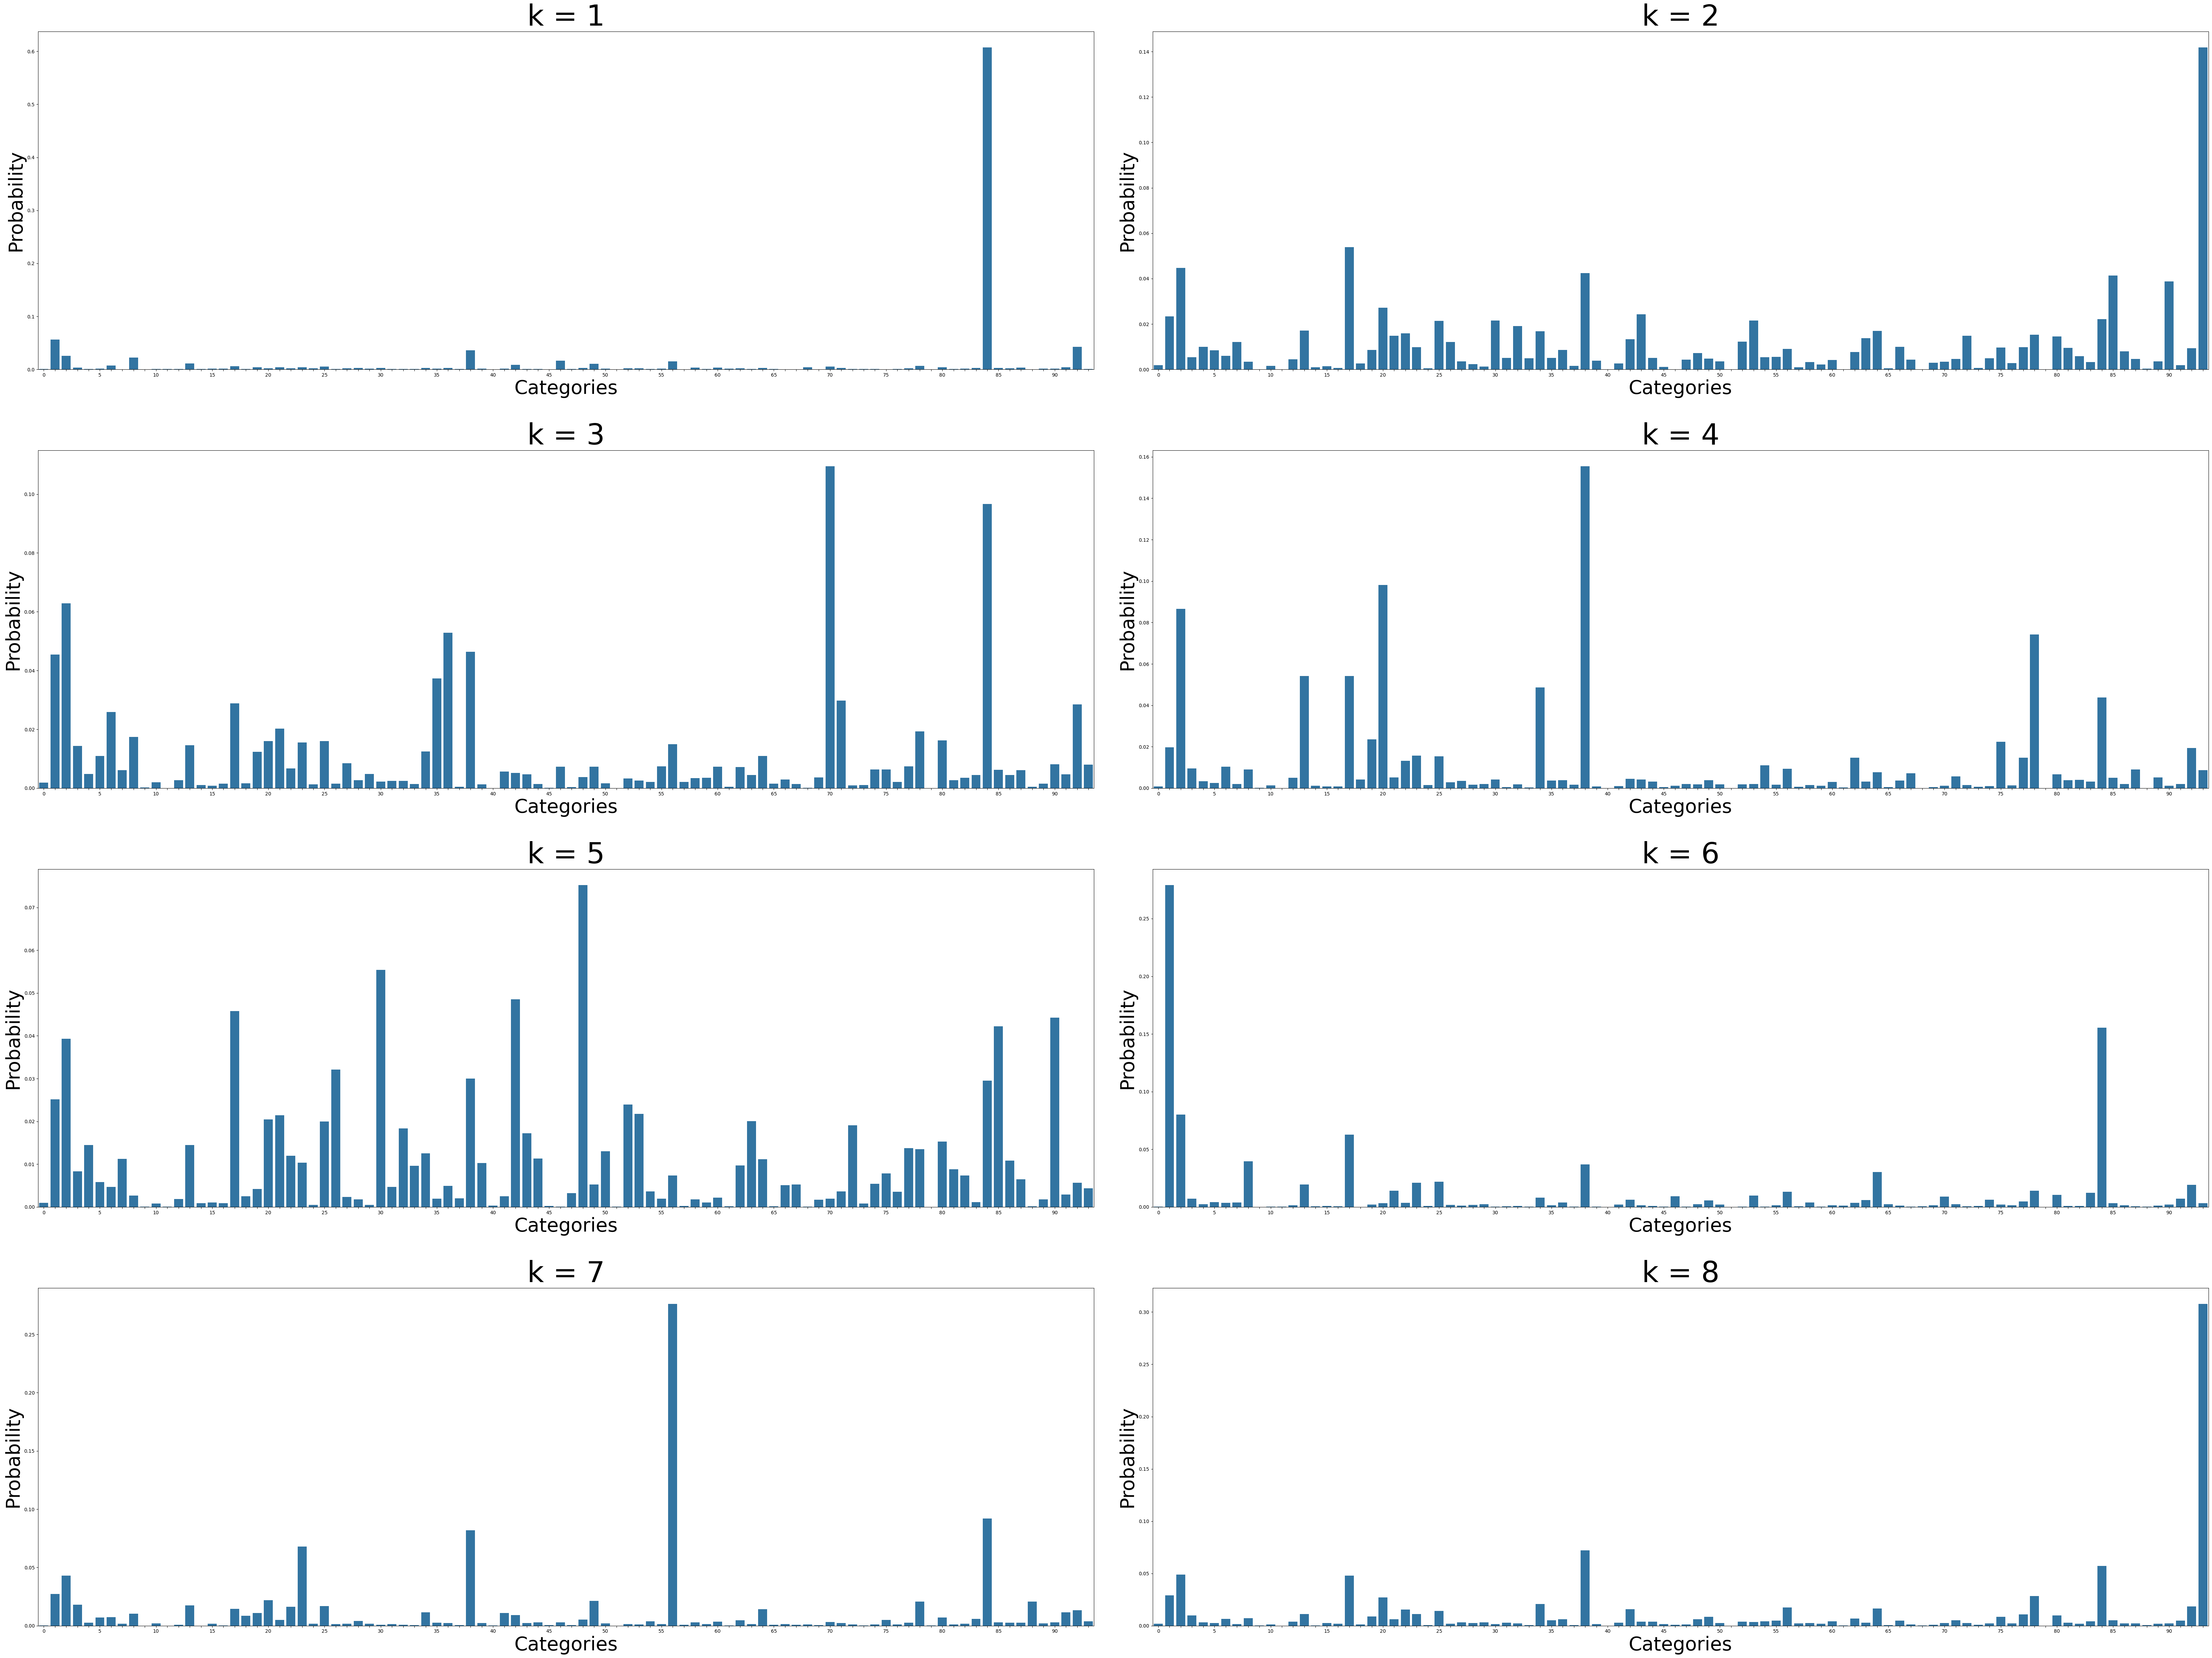

In [72]:
def hide_tick_labels(every_nth, ax):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

K, C = best_beta.shape
K = 8
fig, axes = plt.subplots(nrows=(K // 2), ncols=2, figsize=(64,48))
k = 0
i = 0
while k < K:
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][0])
    hide_tick_labels(5, axes[i][0])
    axes[i][0].set_title('k = %i' % (k+1), size=60)
    axes[i][0].set_xlabel('Categories', size=40)
    axes[i][0].set_ylabel('Probability', size=40)
    k += 1
    
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][1])
    hide_tick_labels(5, axes[i][1])
    axes[i][1].set_title('k = %i' % (k+1), size=60)
    axes[i][1].set_xlabel('Categories', size=40)
    axes[i][1].set_ylabel('Probability', size=40)

    k += 1
    i += 1

fig.tight_layout(h_pad=5, w_pad=5)

## Visualize cluster distances

In [73]:
from sklearn.metrics.pairwise import manhattan_distances

beta_distances = manhattan_distances(best_beta)

In [74]:
beta_distances.shape

(30, 30)

In [75]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress="auto")
beta_distances_transformed = embedding.fit_transform(beta_distances)

C:\Users\USER\AppData\Local\Temp\ipykernel_2984\1222345646.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(lgnd.legendHandles):


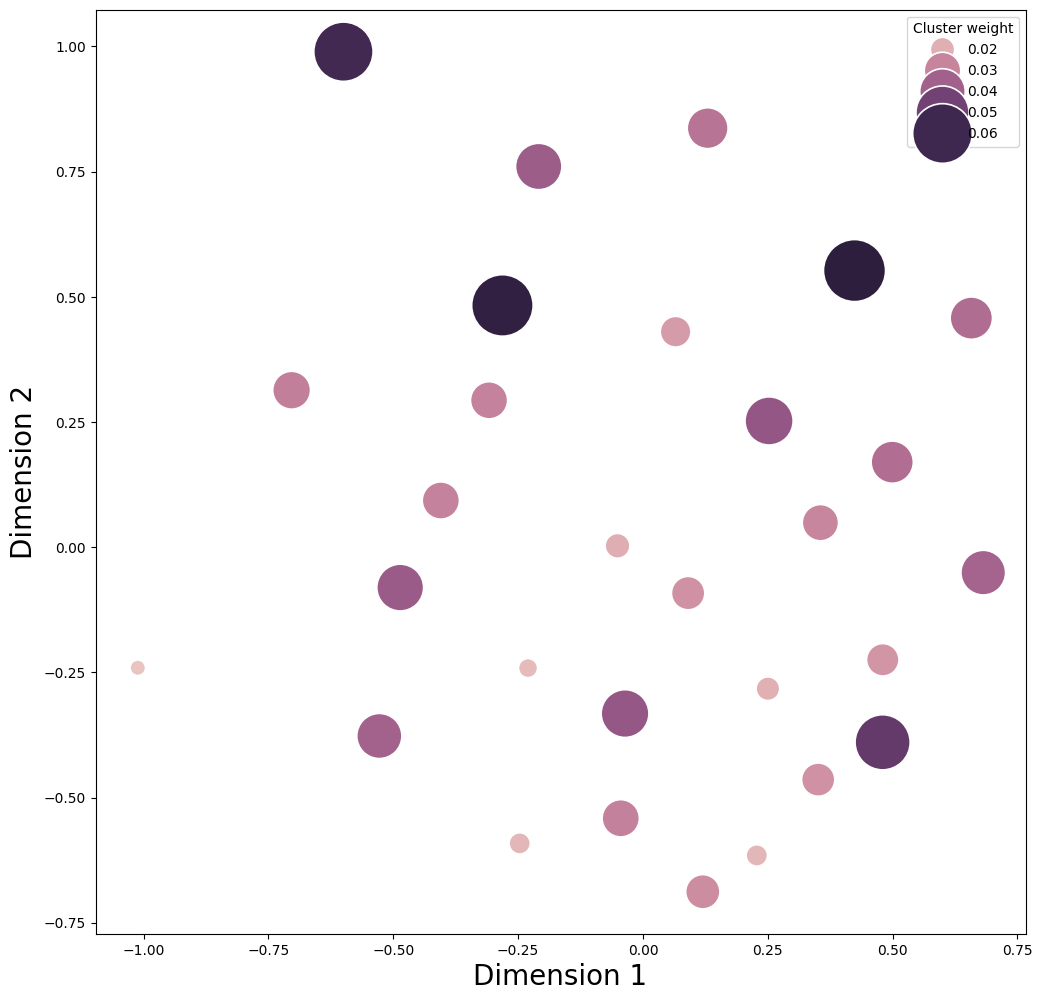

In [77]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x=beta_distances_transformed[:, 0], 
                     y=beta_distances_transformed[:, 1],
                     size=best_alpha,
                     hue=best_alpha,
                     sizes=(1, 2000))
ax.set_xlabel('Dimension 1', size=20)
ax.set_ylabel('Dimension 2', size=20)

# Plot legend.
lgnd = ax.legend(title='Cluster weight')
for i, handle in enumerate(lgnd.legendHandles):
    handle._sizes = [(i+1) * 30]

## Describe clusters by high lift items

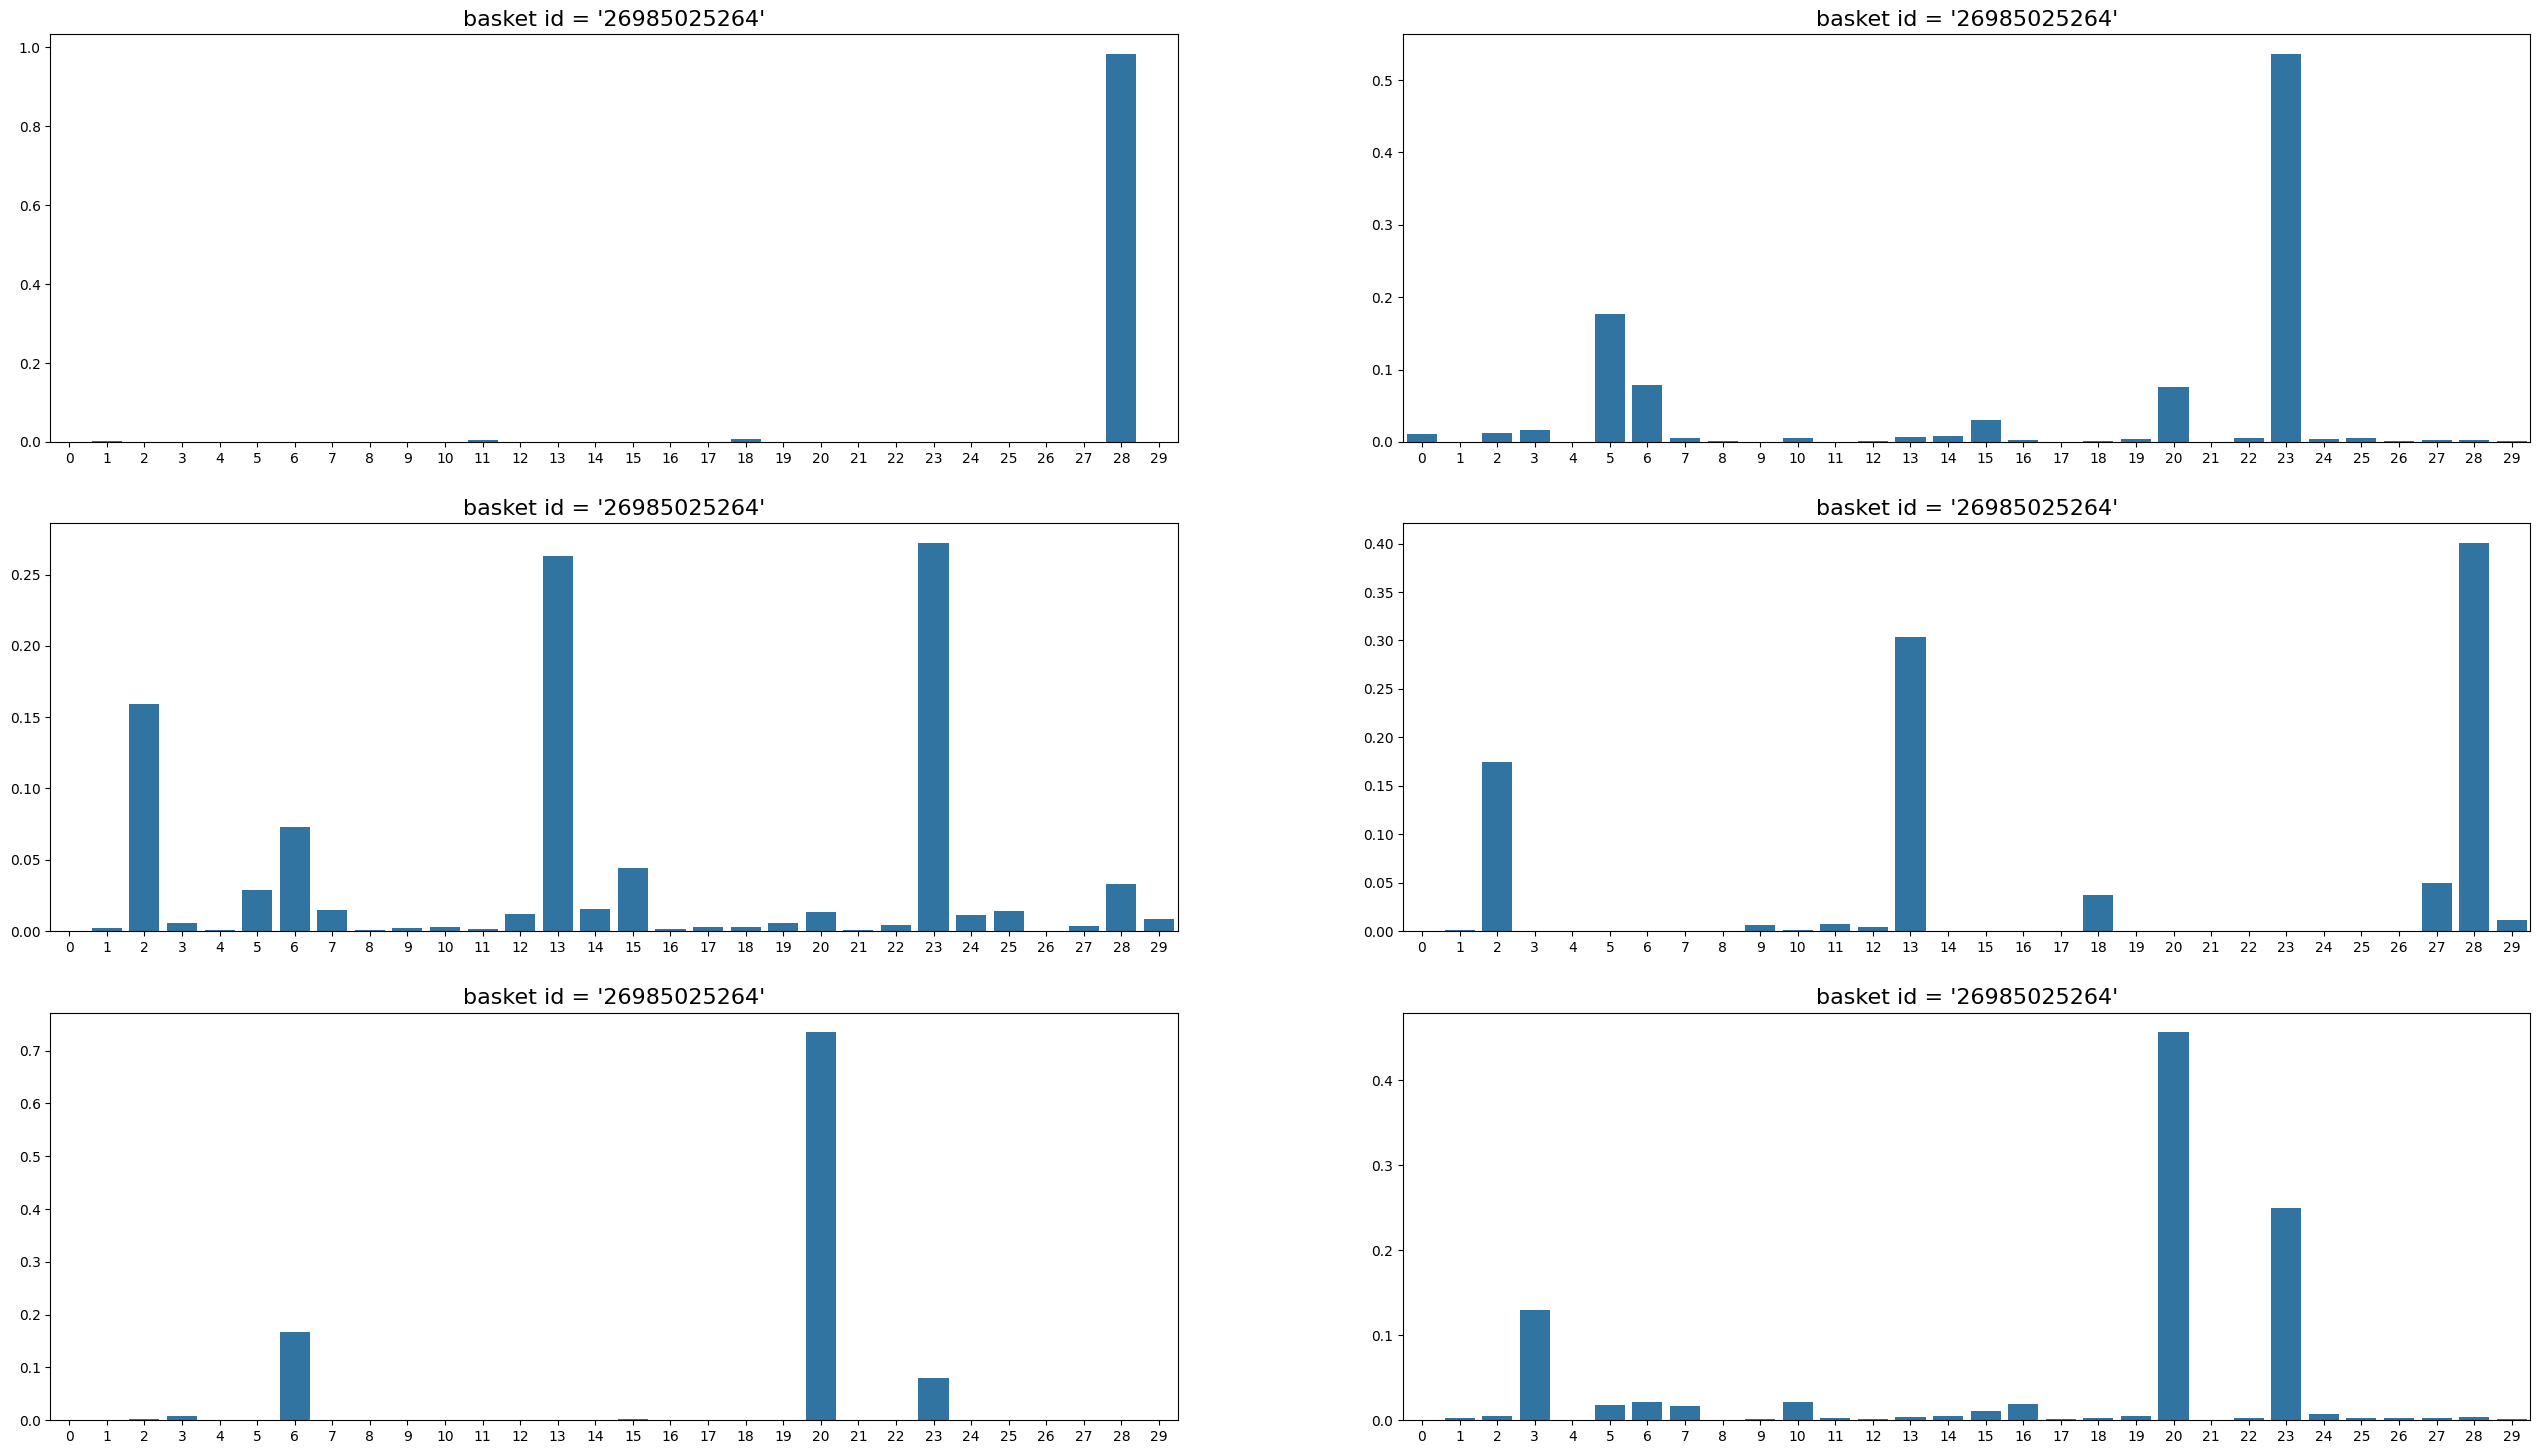

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32,18))
for i in range(6):
    sns.barplot(x=list(range(best_gamma.shape[1])), y=best_gamma[i], ax=axes[(i//2)][i%2])
    axes[(i//2)][i%2].set_title("basket id = '%s'" % train_grocery_df.BASKET_ID[:6][i], size=16)

__Compute global product purchase probabilities__

In [80]:
product_counts = train_grocery_df.groupby('PRODUCT_ID')['QUANTITY'].sum()
product_purchase_prob = product_counts / product_counts.sum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

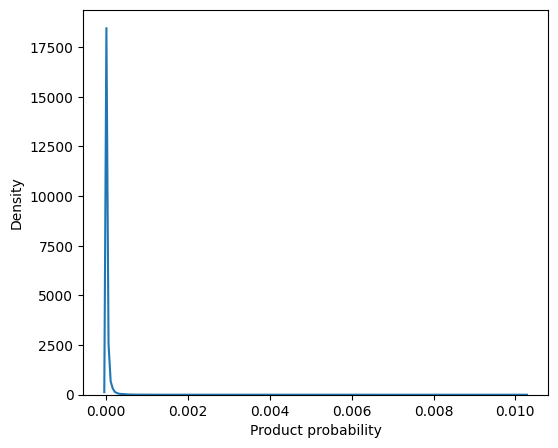

In [81]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(product_purchase_prob, ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [84]:
global_probs_df = pd.DataFrame(data={'Product probability': product_purchase_prob}).sort_values('Product probability', ascending=False)

In [85]:
high_freq_items_prob = product_purchase_prob[product_purchase_prob > 0.0001]
high_freq_items_prob_df = pd.DataFrame(data={'Total purchase prob': high_freq_items_prob})
high_freq_items_prob_df.sort_values('Total purchase prob', ascending=False)

Total purchase prob
PRODUCT_ID                     
995242                 0.010237
1029743                0.007635
1133018                0.005806
981760                 0.005225
1106523                0.005187
...                         ...
9553382                0.000101
903609                 0.000101
943858                 0.000101
943362                 0.000101
862651                 0.000101

[2019 rows x 1 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

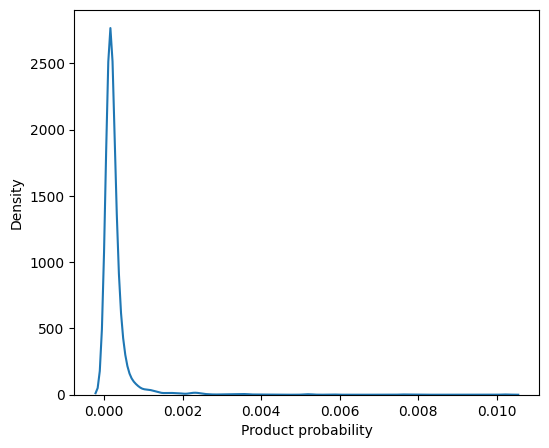

In [86]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(high_freq_items_prob_df['Total purchase prob'], ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [87]:
total_cluster_weights = best_gamma.sum(axis=0)

products_filepath = 'product.csv'
products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)

cluster_weights_by_basket_id = {}
for i, (individual_id, basket_id) in enumerate(train_counts_df.index):
    cluster_weights_by_basket_id[basket_id] = best_gamma[i]

def product_prob_for_component(g, k):
    total_product_cluster_weight = 0
    for basket_id in g['BASKET_ID']:
        total_product_cluster_weight += cluster_weights_by_basket_id[basket_id][k]
    return total_product_cluster_weight / total_cluster_weights[k]

def get_high_lift_frequent_items(k):
    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift.join(products_df, how='inner')

In [90]:
total_quantities = train_grocery_df['QUANTITY'].sum()

cluster_1_df = get_high_lift_frequent_items(k=0)
cluster_1_df['count'] = (cluster_1_df['Total purchase prob'] * total_quantities).astype(int)
weights = (cluster_1_df['Lift'] * cluster_1_df['count']).astype(int)
cluster_1_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(int)

In [91]:
cluster_1_df

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
885750                 0.000153  52.583062           103    GROCERY  National   
935959                 0.000161  44.743487           103    GROCERY  National   
1037894                0.000451  43.515644          2224    GROCERY  National   
1027874                0.000133  43.231333            69    GROCERY   Private   
1085604                0.001743  42.581242           103    GROCERY  National   
...                         ...        ...           ...        ...       ...   
1010190                0.000343  10.758134          1208    GROCERY  National   
943141                 0.000134  10.585928            69    GROCERY   Private   
928123                 0.000103  10.573348            69    GROCERY   Private   
1064892                0.000174  10.478567            69    GROCERY   Private   
831712                 0.000128  10.237154            69    GROCERY   Private   

                    COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                           
885750                 SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
935959                 SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1037894                SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1027874                SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
1085604                SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
...                            ...                             ...   
1010190                SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
943141                 SOFT DRINKS  MIXERS(TONIC WTR/CLUB SODA/GNG   
928123                 SOFT DRINKS  SOFT DRINKS 12/18&15PK CAN CAR   
1064892                SOFT DRINKS  MIXERS(TONIC WTR/CLUB SODA/GNG   
831712      FRZN NOVELTIES/WTR ICE             CUPS/PUSH UPS/OTHER   

           CURR_SIZE_OF_PRODUCT  count  repeat_weight  
PRODUCT_ID                                             
885750                    20 OZ    264              9  
935959                    20 OZ    279              8  
1037894                   20 OZ    780             25  
1027874                   2 LTR    230              6  
1085604                   20 OZ   3015            100  
...                         ...    ...            ...  
1010190                   2 LTR    594              3  
943141                    1 LTR    232              0  
928123                    12 OZ    179              0  
1064892                   2 LTR    301              0  
831712                    12 CT    221              0  

[166 rows x 10 columns]

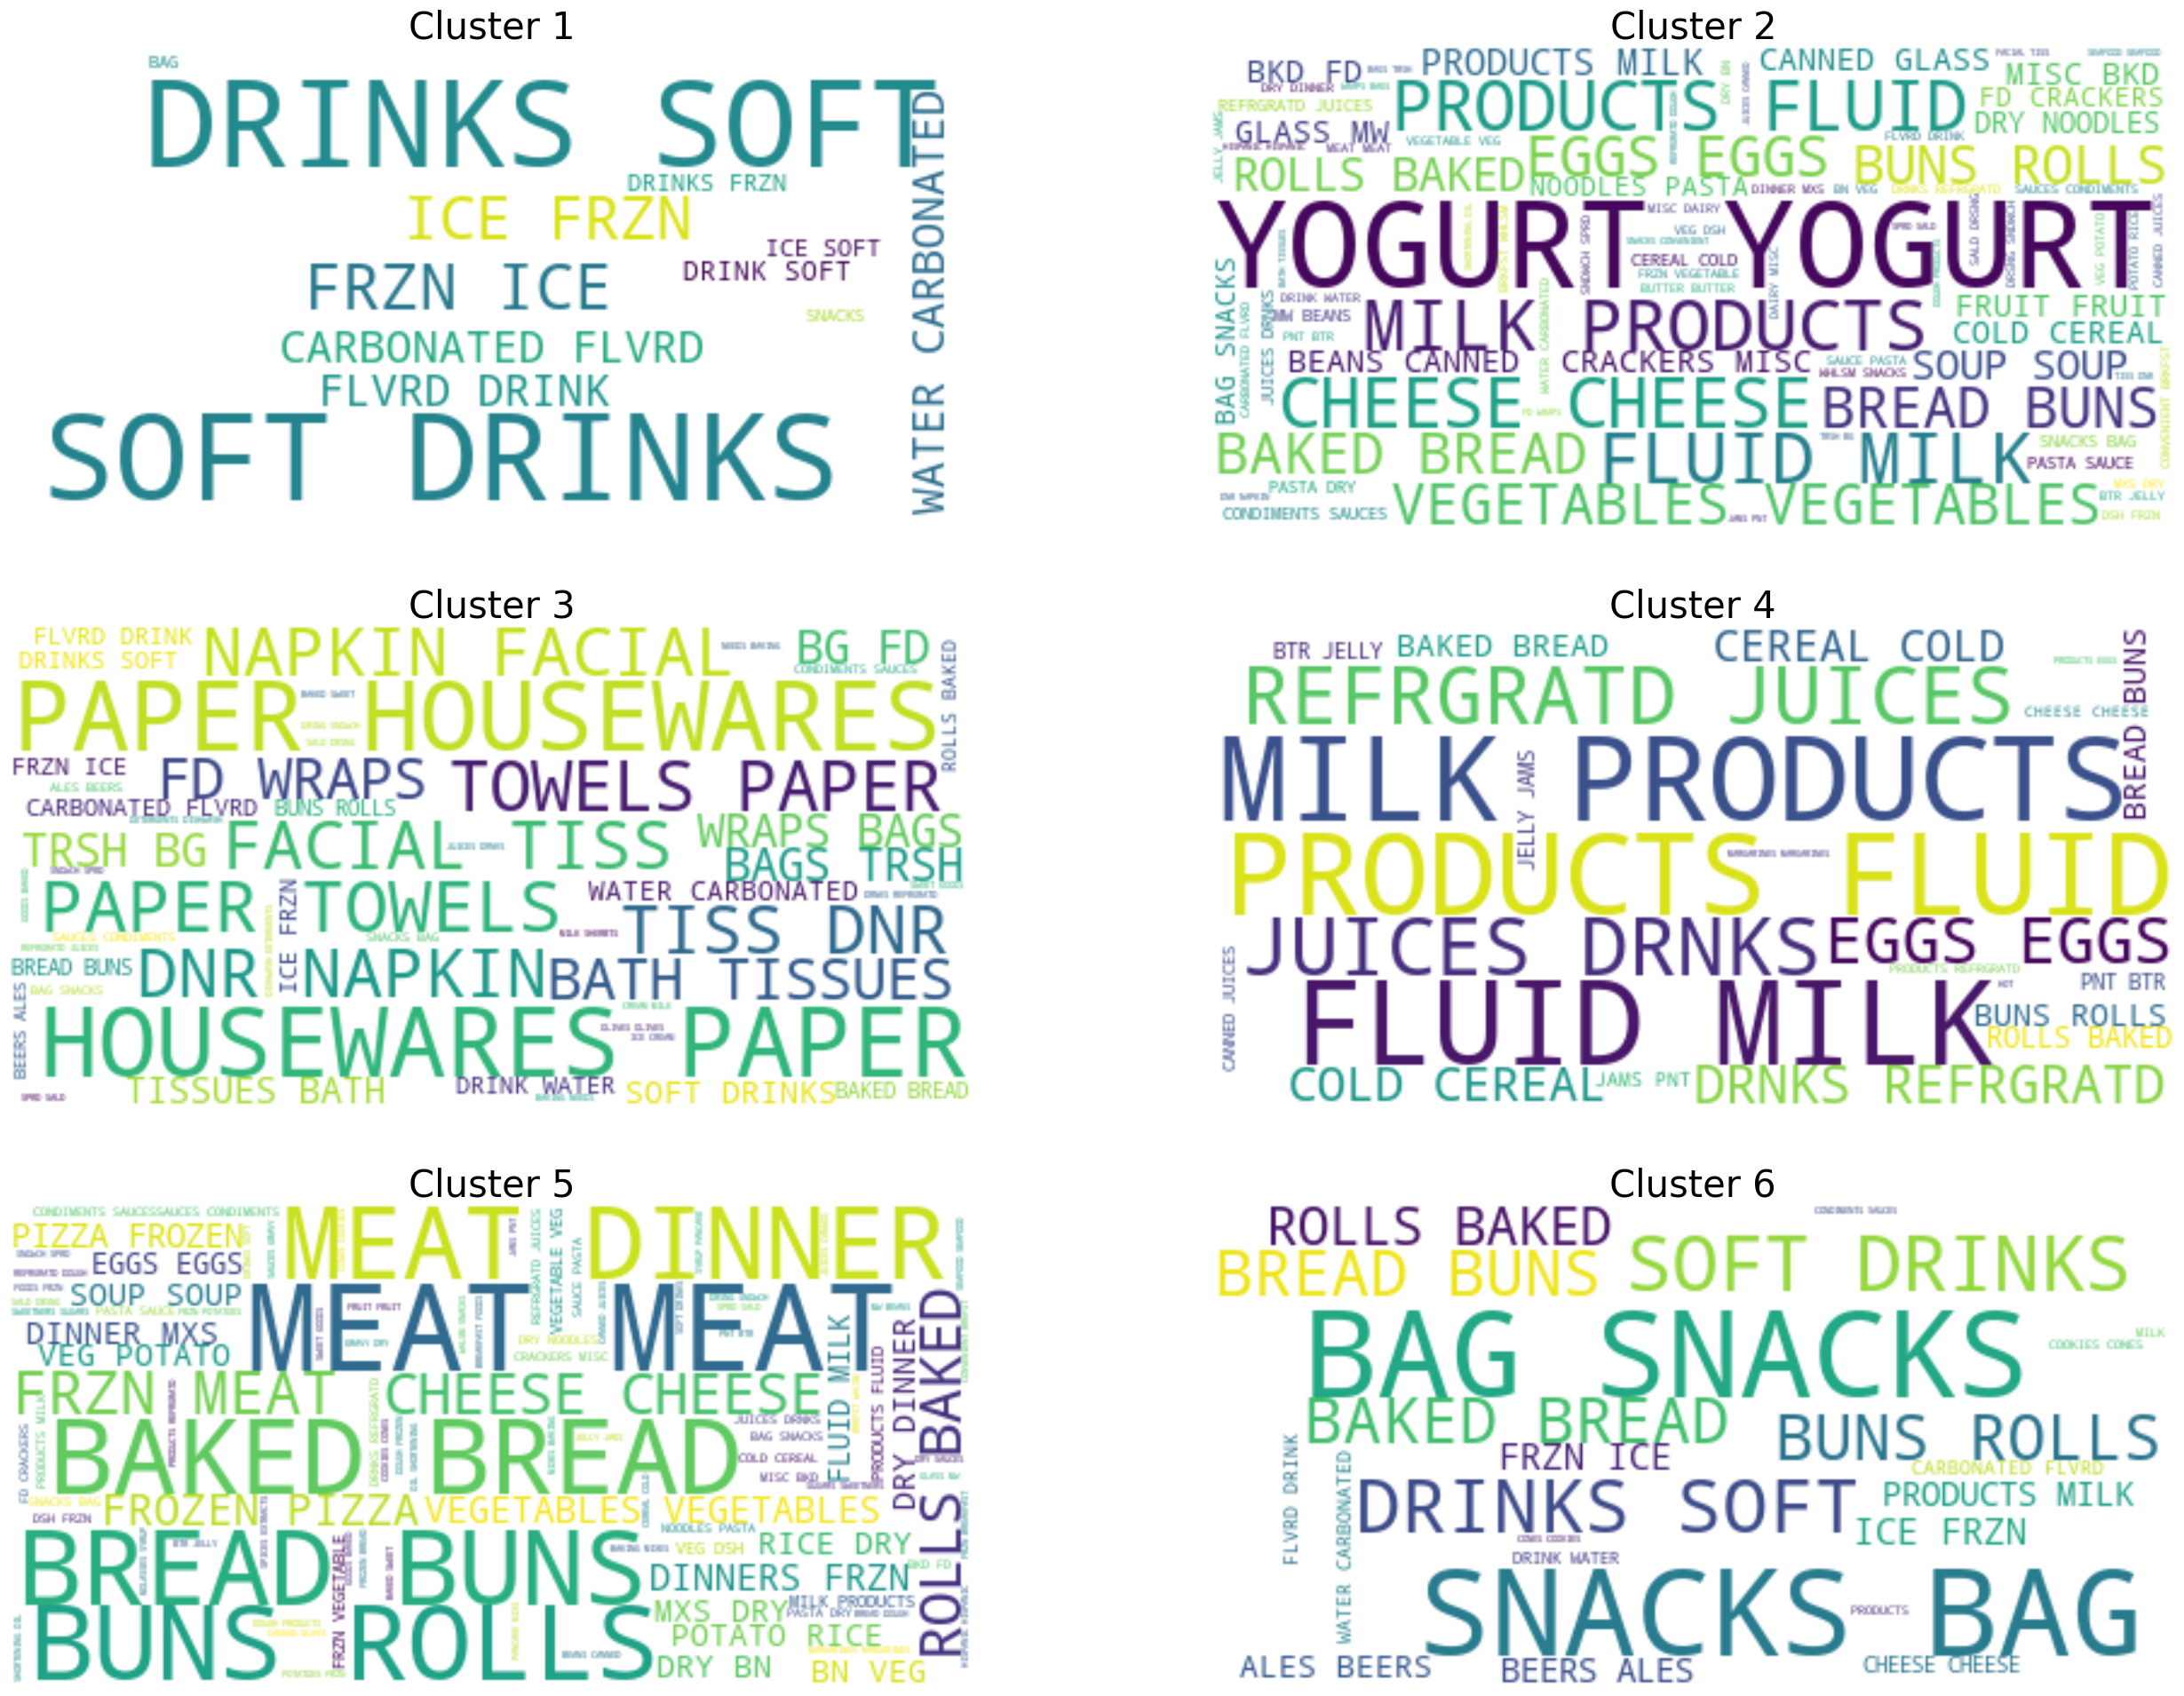

In [97]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

total_quantities = train_grocery_df['QUANTITY'].sum()

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32, 24))
axes = axes.ravel()
for i, ax in enumerate(axes):
    high_lift_items_df = get_high_lift_frequent_items(k=i)
    high_lift_items_df['count'] = (high_lift_items_df['Total purchase prob'] * total_quantities).astype(int)
    weights = (high_lift_items_df['Lift'] * high_lift_items_df['count']).astype(int)
    high_lift_items_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(int)
    high_lift_items_df['COMMODITY_DESC'] = (high_lift_items_df['COMMODITY_DESC'] + ', ').str.replace('SHELF', '').str.replace('STABLE', '')
    description = high_lift_items_df['COMMODITY_DESC'].repeat(high_lift_items_df['repeat_weight']).str.cat(sep=', ')
    img = wordcloud.generate(description)
    ax.imshow(img, interpolation="bilinear")
    ax.axis("off")
    ax.set_title('Cluster %i' % (i+1), size=30)

### Now product associations

In [98]:
cluster_1_df.sort_values('Lift', ascending=False)

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
885750                 0.000153  52.583062           103    GROCERY  National   
935959                 0.000161  44.743487           103    GROCERY  National   
1037894                0.000451  43.515644          2224    GROCERY  National   
1027874                0.000133  43.231333            69    GROCERY   Private   
1085604                0.001743  42.581242           103    GROCERY  National   
...                         ...        ...           ...        ...       ...   
1010190                0.000343  10.758134          1208    GROCERY  National   
943141                 0.000134  10.585928            69    GROCERY   Private   
928123                 0.000103  10.573348            69    GROCERY   Private   
1064892                0.000174  10.478567            69    GROCERY   Private   
831712                 0.000128  10.237154            69    GROCERY   Private   

                    COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                           
885750                 SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
935959                 SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1037894                SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
1027874                SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
1085604                SOFT DRINKS  SFT DRNK SNGL SRV BTL CARB (EX   
...                            ...                             ...   
1010190                SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
943141                 SOFT DRINKS  MIXERS(TONIC WTR/CLUB SODA/GNG   
928123                 SOFT DRINKS  SOFT DRINKS 12/18&15PK CAN CAR   
1064892                SOFT DRINKS  MIXERS(TONIC WTR/CLUB SODA/GNG   
831712      FRZN NOVELTIES/WTR ICE             CUPS/PUSH UPS/OTHER   

           CURR_SIZE_OF_PRODUCT  count  repeat_weight  
PRODUCT_ID                                             
885750                    20 OZ    264              9  
935959                    20 OZ    279              8  
1037894                   20 OZ    780             25  
1027874                   2 LTR    230              6  
1085604                   20 OZ   3015            100  
...                         ...    ...            ...  
1010190                   2 LTR    594              3  
943141                    1 LTR    232              0  
928123                    12 OZ    179              0  
1064892                   2 LTR    301              0  
831712                    12 CT    221              0  

[166 rows x 10 columns]

In [99]:
import itertools

cluster1_highest_lift_product_ids = cluster_1_df.sort_values('Lift', ascending=False).index[:5]
cluster1_highest_lift_product_pairs = list(itertools.combinations(cluster1_highest_lift_product_ids, 2))
len(cluster1_highest_lift_product_pairs)

10

In [100]:
from tqdm import tqdm
from collections import defaultdict

nb_baskets = len(train_grocery_df['BASKET_ID'].unique())
total_cluster_weight = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in train_grocery_df['BASKET_ID'].unique()])

basket_ids_with_pair_by_pair = defaultdict(list)
for i, g in tqdm(train_grocery_df.groupby('BASKET_ID')):
    for pair in cluster1_highest_lift_product_pairs:
        if ((g['PRODUCT_ID'] == pair[0]).sum() > 0) and ((g['PRODUCT_ID'] == pair[1]).sum() > 0):
            basket_ids_with_pair_by_pair[pair].append(g['BASKET_ID'].iloc[0])

pair_lifts = {}
for pair, basket_ids in basket_ids_with_pair_by_pair.items():
    total_proba = len(basket_ids) / nb_baskets
    cluster_pair_proba = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in basket_ids]) / total_cluster_weight
    pair_lifts[pair] = cluster_pair_proba / total_proba    

100%|██████████| 172328/172328 [01:43<00:00, 1666.07it/s]


In [101]:
pair_lifts

{(885750, 935959): 10.518317821173191,
 (885750, 1085604): 9.23047668281639,
 (935959, 1085604): 8.750246544516726,
 (935959, 1037894): 8.715677002574619,
 (1037894, 1085604): 7.402696913025187,
 (885750, 1037894): 10.858063192429599,
 (1027874, 1085604): 16.650028396079314}

In [102]:
products_df[(products_df.index == 885750) | (products_df.index == 935959)]

MANUFACTURER DEPARTMENT     BRAND COMMODITY_DESC  \
PRODUCT_ID                                                     
885750               103    GROCERY  National    SOFT DRINKS   
935959               103    GROCERY  National    SOFT DRINKS   

                        SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                                                       
885750      SFT DRNK SNGL SRV BTL CARB (EX                20 OZ  
935959      SFT DRNK SNGL SRV BTL CARB (EX                20 OZ

### Predictive profiles

__Global predictive profile__

<Axes: >

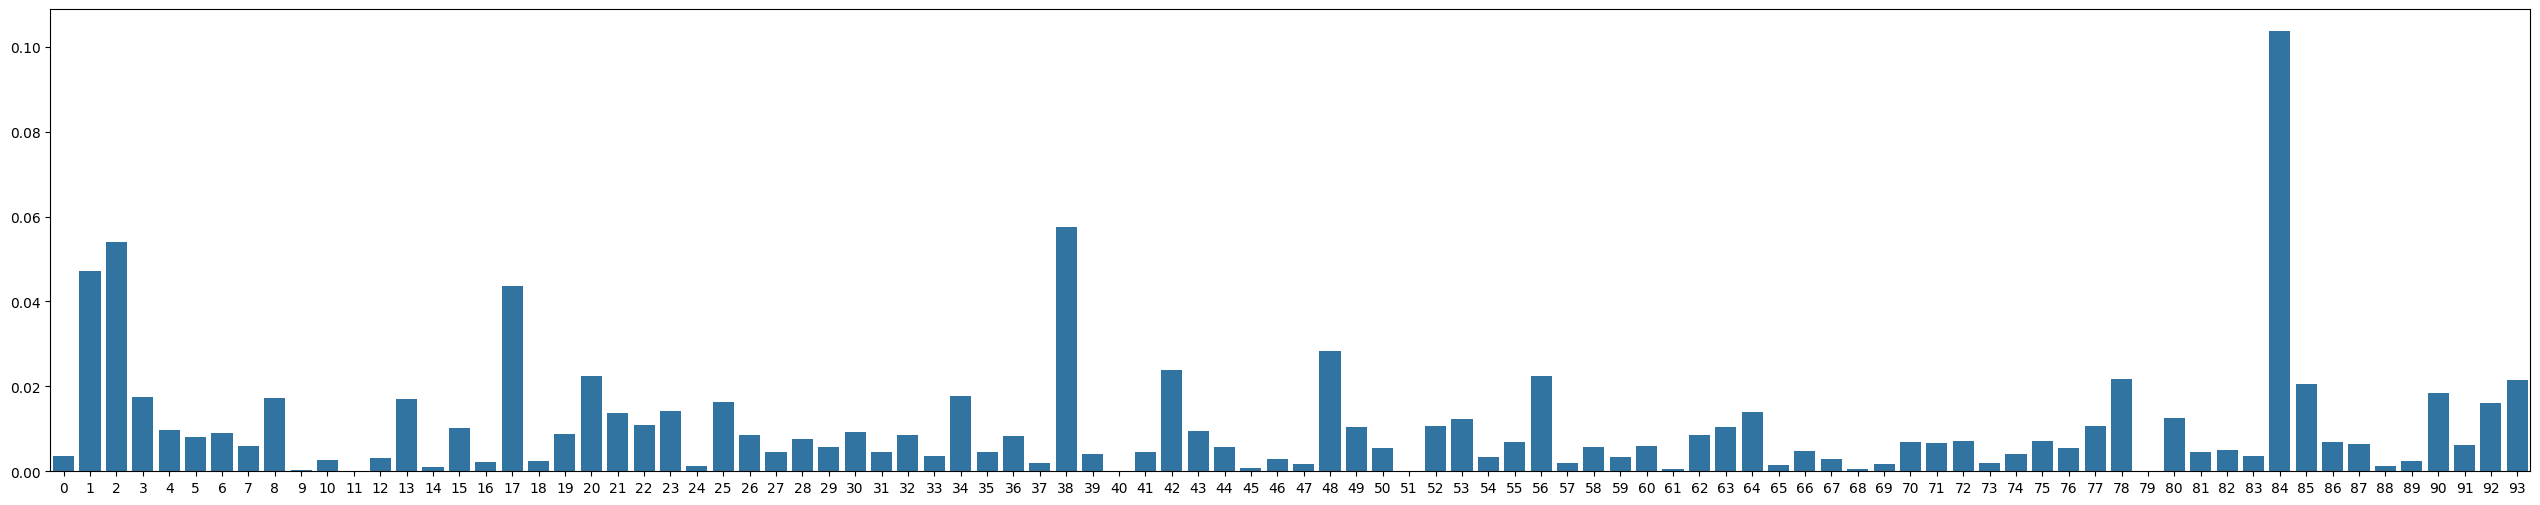

In [105]:
weighted_multi = best_alpha.reshape(-1, 1) * best_beta
global_predictive_profile = weighted_multi.sum(axis=0) / weighted_multi.sum()

plt.subplots(figsize=(32,6))
sns.barplot(x=np.arange(best_beta.shape[1]), y=global_predictive_profile)

__Global predictive profile__

Text(0, 0.5, 'Purchase probability')

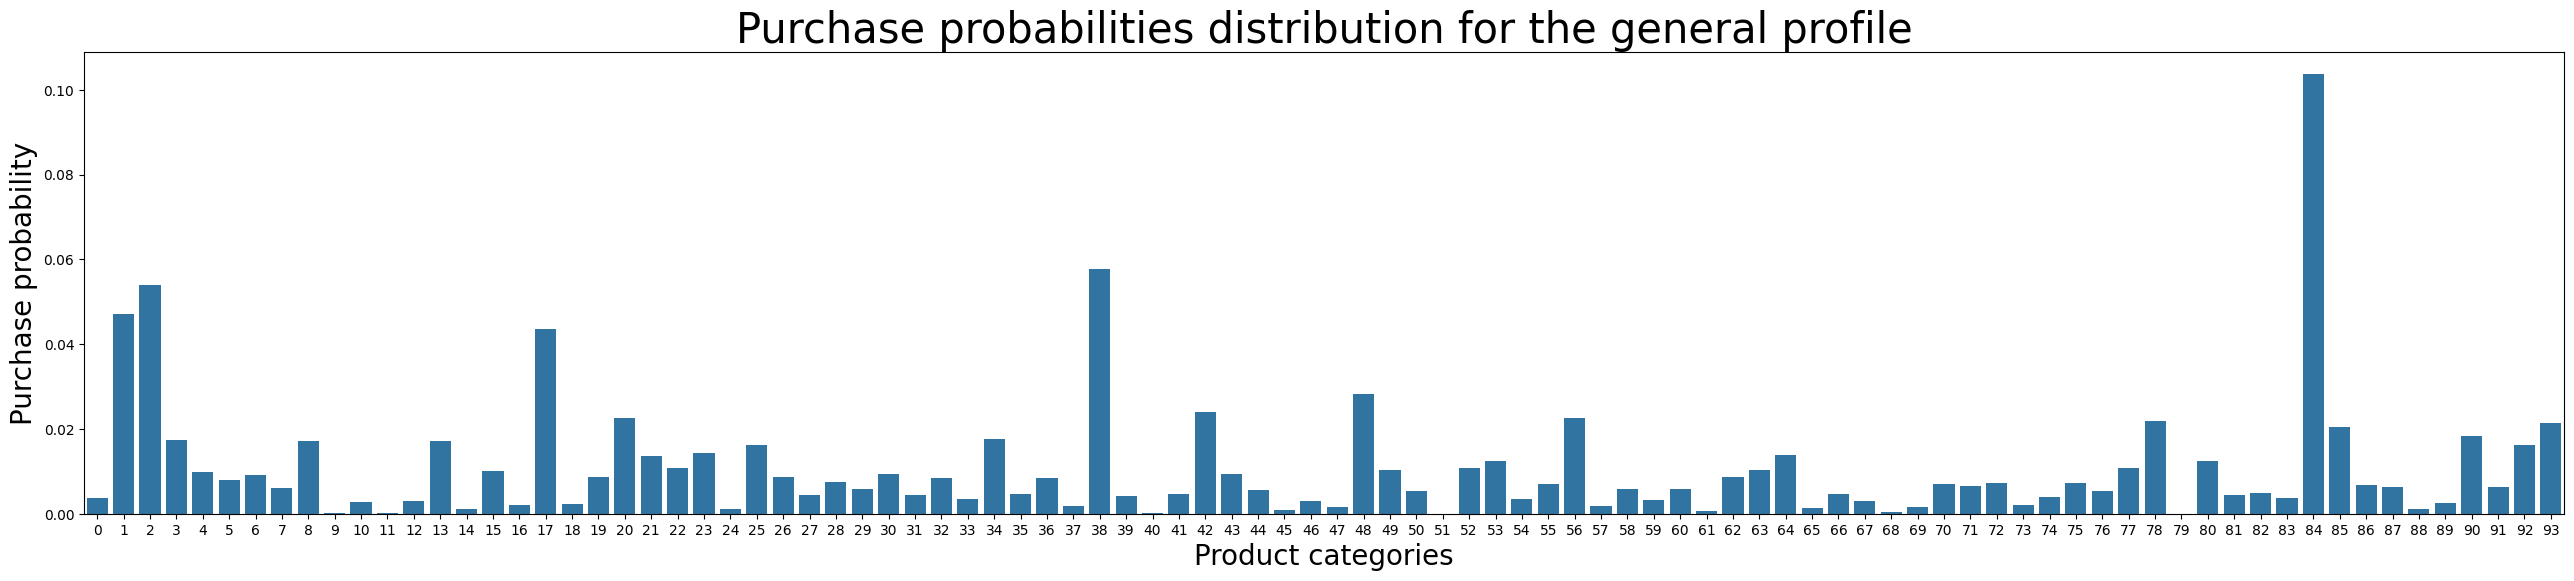

In [106]:
from scipy.stats import multinomial

K, C = best_beta.shape
n=100000
total = np.zeros((C))
for k in range(K):
    k_samples = best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=1000)
    total += k_samples.sum(axis=0)
probs = total / total.sum()

plt.subplots(figsize=(32,6))
ax = sns.barplot(x=np.arange(probs.size), y=probs)
ax.set_title('Purchase probabilities distribution for the general profile', size=30)
ax.set_xlabel('Product categories', size=20)
ax.set_ylabel('Purchase probability', size=20)

__Now using cluster assignments__

In [107]:
best_gamma_df = pd.DataFrame(best_gamma, index=train_household_ids)
best_gamma_df.head()

0         1         2             3         4   \
household_key                                                             
1              7.017506e-19  0.002436  0.000002  9.066239e-09  0.000147   
1              1.148400e-02  0.000360  0.011821  1.663011e-02  0.000486   
1              1.951947e-04  0.002351  0.159465  5.824441e-03  0.000832   
1              1.571174e-11  0.001647  0.175011  1.820233e-07  0.000046   
1              1.181065e-05  0.000019  0.002287  8.464995e-03  0.000011   

                         5             6             7         8         9   \
household_key                                                                 
1              5.427115e-12  3.550055e-09  5.406724e-08  0.000007  0.000136   
1              1.762953e-01  7.932724e-02  5.238651e-03  0.001087  0.000406   
1              2.881172e-02  7.315211e-02  1.467645e-02  0.001100  0.002038   
1              9.960853e-08  3.828006e-06  2.378746e-05  0.000107  0.006728   
1              1.021548e-03  1.669768e-01  6.745793e-04  0.000039  0.000017   

               ...        20            21        22            23        24  \
household_key  ...                                                             
1              ...  0.000001  8.659612e-17  0.000021  7.977748e-09  0.000016   
1              ...  0.075986  2.076106e-04  0.005366  5.365524e-01  0.003621   
1              ...  0.013056  4.354185e-04  0.004149  2.722345e-01  0.011399   
1              ...  0.000019  2.715899e-10  0.000022  5.849035e-06  0.000415   
1              ...  0.734943  3.198314e-06  0.000149  7.912500e-02  0.000057   

                     25            26            27        28        29  
household_key                                                            
1              0.000001  2.589457e-12  4.958914e-09  0.983742  0.000020  
1              0.005398  1.564528e-03  2.651245e-03  0.002338  0.001061  
1              0.013951  9.432666e-05  3.322529e-03  0.033137  0.008348  
1              0.000310  4.195286e-10  4.965795e-02  0.400740  0.011624  
1              0.000296  2.235120e-05  4.888144e-04  0.000269  0.000073  

[5 rows x 30 columns]

In [108]:
test_counts_df.index = test_counts_df.index.droplevel()

In [109]:
from scipy.special import logsumexp

def compute_complete_predictive_profile(household_key):
    household_assignments = best_gamma_df[best_gamma_df.index == household_key]

    K, C = best_beta.shape
    total = np.zeros(C)
    for i, assignment in household_assignments.iterrows():
        for k in range(assignment.size):
            i_k_samples = assignment[k] * best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=100)
            total += i_k_samples.sum(axis=0)
    probs = total / total.sum()
    return probs
    
def compute_household_test_purchase(household_key):
    test_basket_ids=test_grocery_df.loc[test_grocery_df['household_key'] == household_key, 'BASKET_ID'].unique()
    household_test_counts_df = test_counts_df[test_counts_df.index.isin(test_basket_ids)].sum(axis=0)
    return household_test_counts_df / household_test_counts_df.sum()
    
def plot_prediction_vs_reality(household_key):
    fig, axes = plt.subplots(nrows=2, figsize=(32,14))
    axes = axes.ravel()
    
    predictive_probs = compute_complete_predictive_profile(household_key)
    sns.barplot(x=np.arange(predictive_probs.size), y=predictive_probs, ax=axes[0])
    axes[0].set_title('Purchases probabilities prediction for household %s' % str(household_key), size=20)
    axes[0].set_xlabel('Categories', size=20)
    axes[0].set_ylabel('Probability', size=20)

    test_probs = compute_household_test_purchase(household_key)
    sns.barplot(x=np.arange(test_probs.size), y=test_probs, ax=axes[1])
    axes[1].set_title('Purchases from the test set for household %s' % str(household_key), size=20)
    axes[1].set_xlabel('Categories', size=20)
    axes[1].set_ylabel('Probability', size=20)

    l1_distance = np.abs(predictive_probs - test_probs).sum()
    plt.text(0.5, -0.25, 'L1 distance between prediction and test data: %.3f' % l1_distance,
             horizontalalignment='center', verticalalignment='center', transform = axes[1].transAxes, size=30)

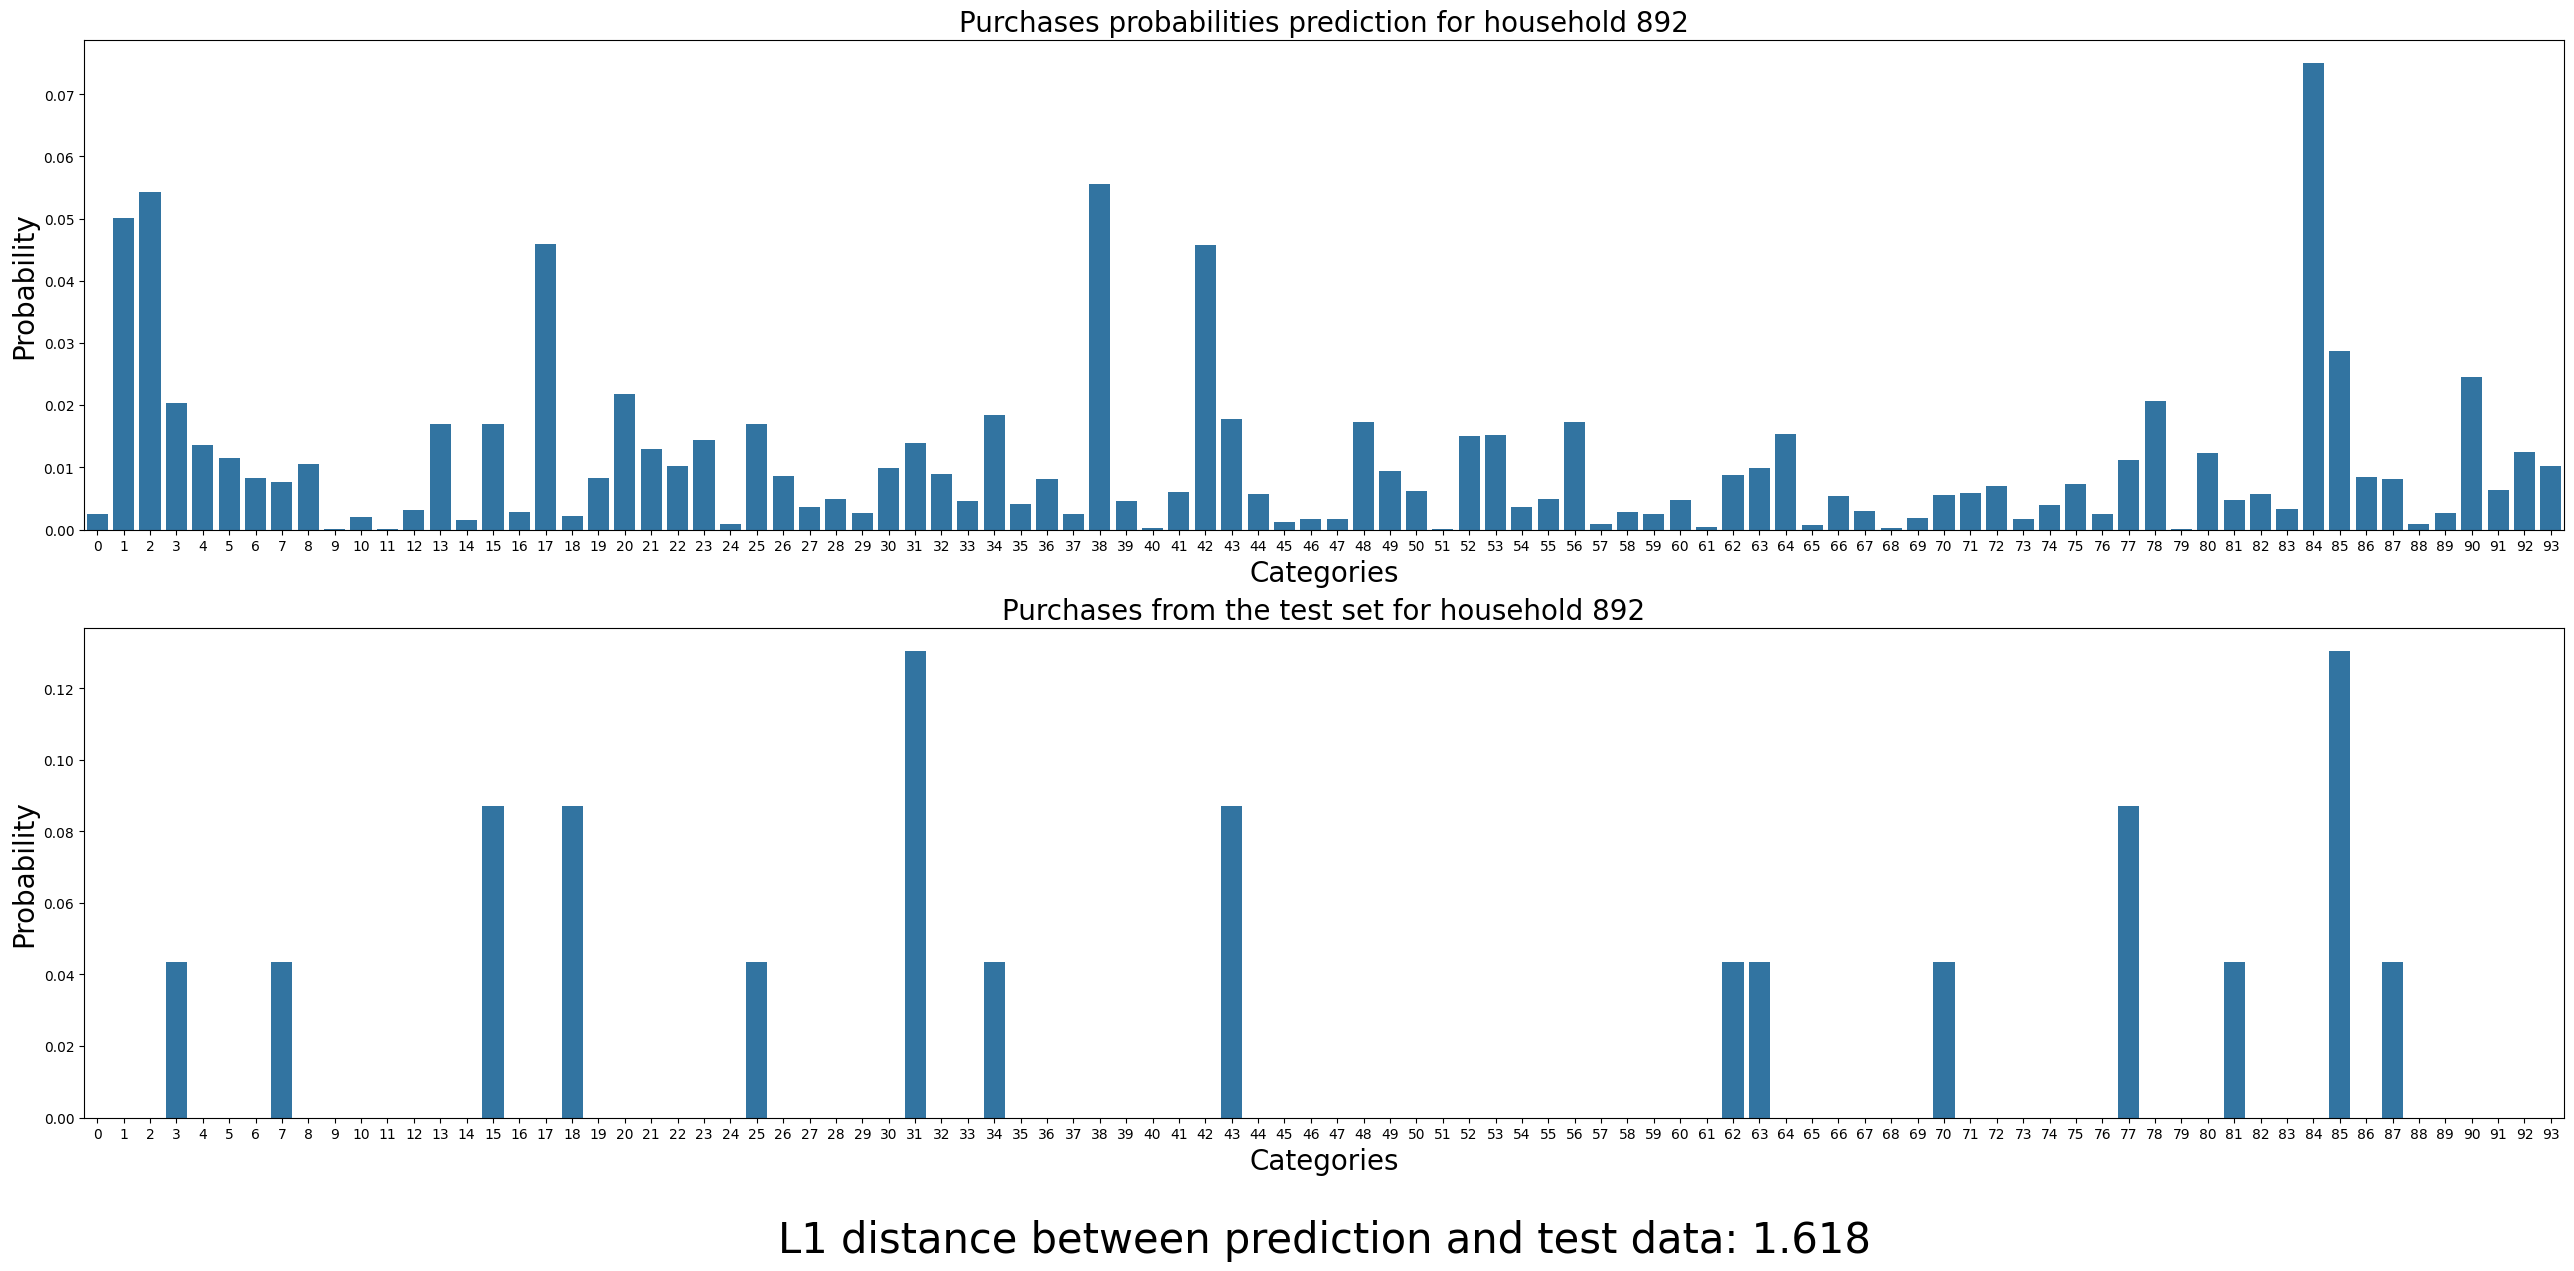

In [110]:
plot_prediction_vs_reality(892)

In [ ]:
from tqdm import tqdm

unique_test_household_ids = test_grocery_df['household_key'].unique()
predictions_distances = {}
for household_id in tqdm(unique_test_household_ids):
    predictive_probs = compute_complete_predictive_profile(household_id)
    test_probs = compute_household_test_purchase(household_id)
    l1_distance = np.abs(predictive_probs - test_probs).sum()
    predictions_distances[household_id] = l1_distance

In [ ]:
pickle.dump(predictions_distances, open('predictions_distances.p', 'wb'))

### Check individuals cluster assignments stability

In [111]:
def plot_group_clusters_attributions(household_key):
    g = best_gamma_df.groupby(best_gamma_df.index).get_group(household_key).copy()
    n, c = g.shape
    fig, axes = plt.subplots(nrows=((n+1) // 2), ncols=2, figsize=(32,64))
    for i in range(n):
        sns.barplot(x=list(range(g.shape[1])), y=g.iloc[i], ax=axes[(i//2)][i%2])
        axes[(i//2)][i%2].set_title('Visit = %i' % (i+1), size=16)

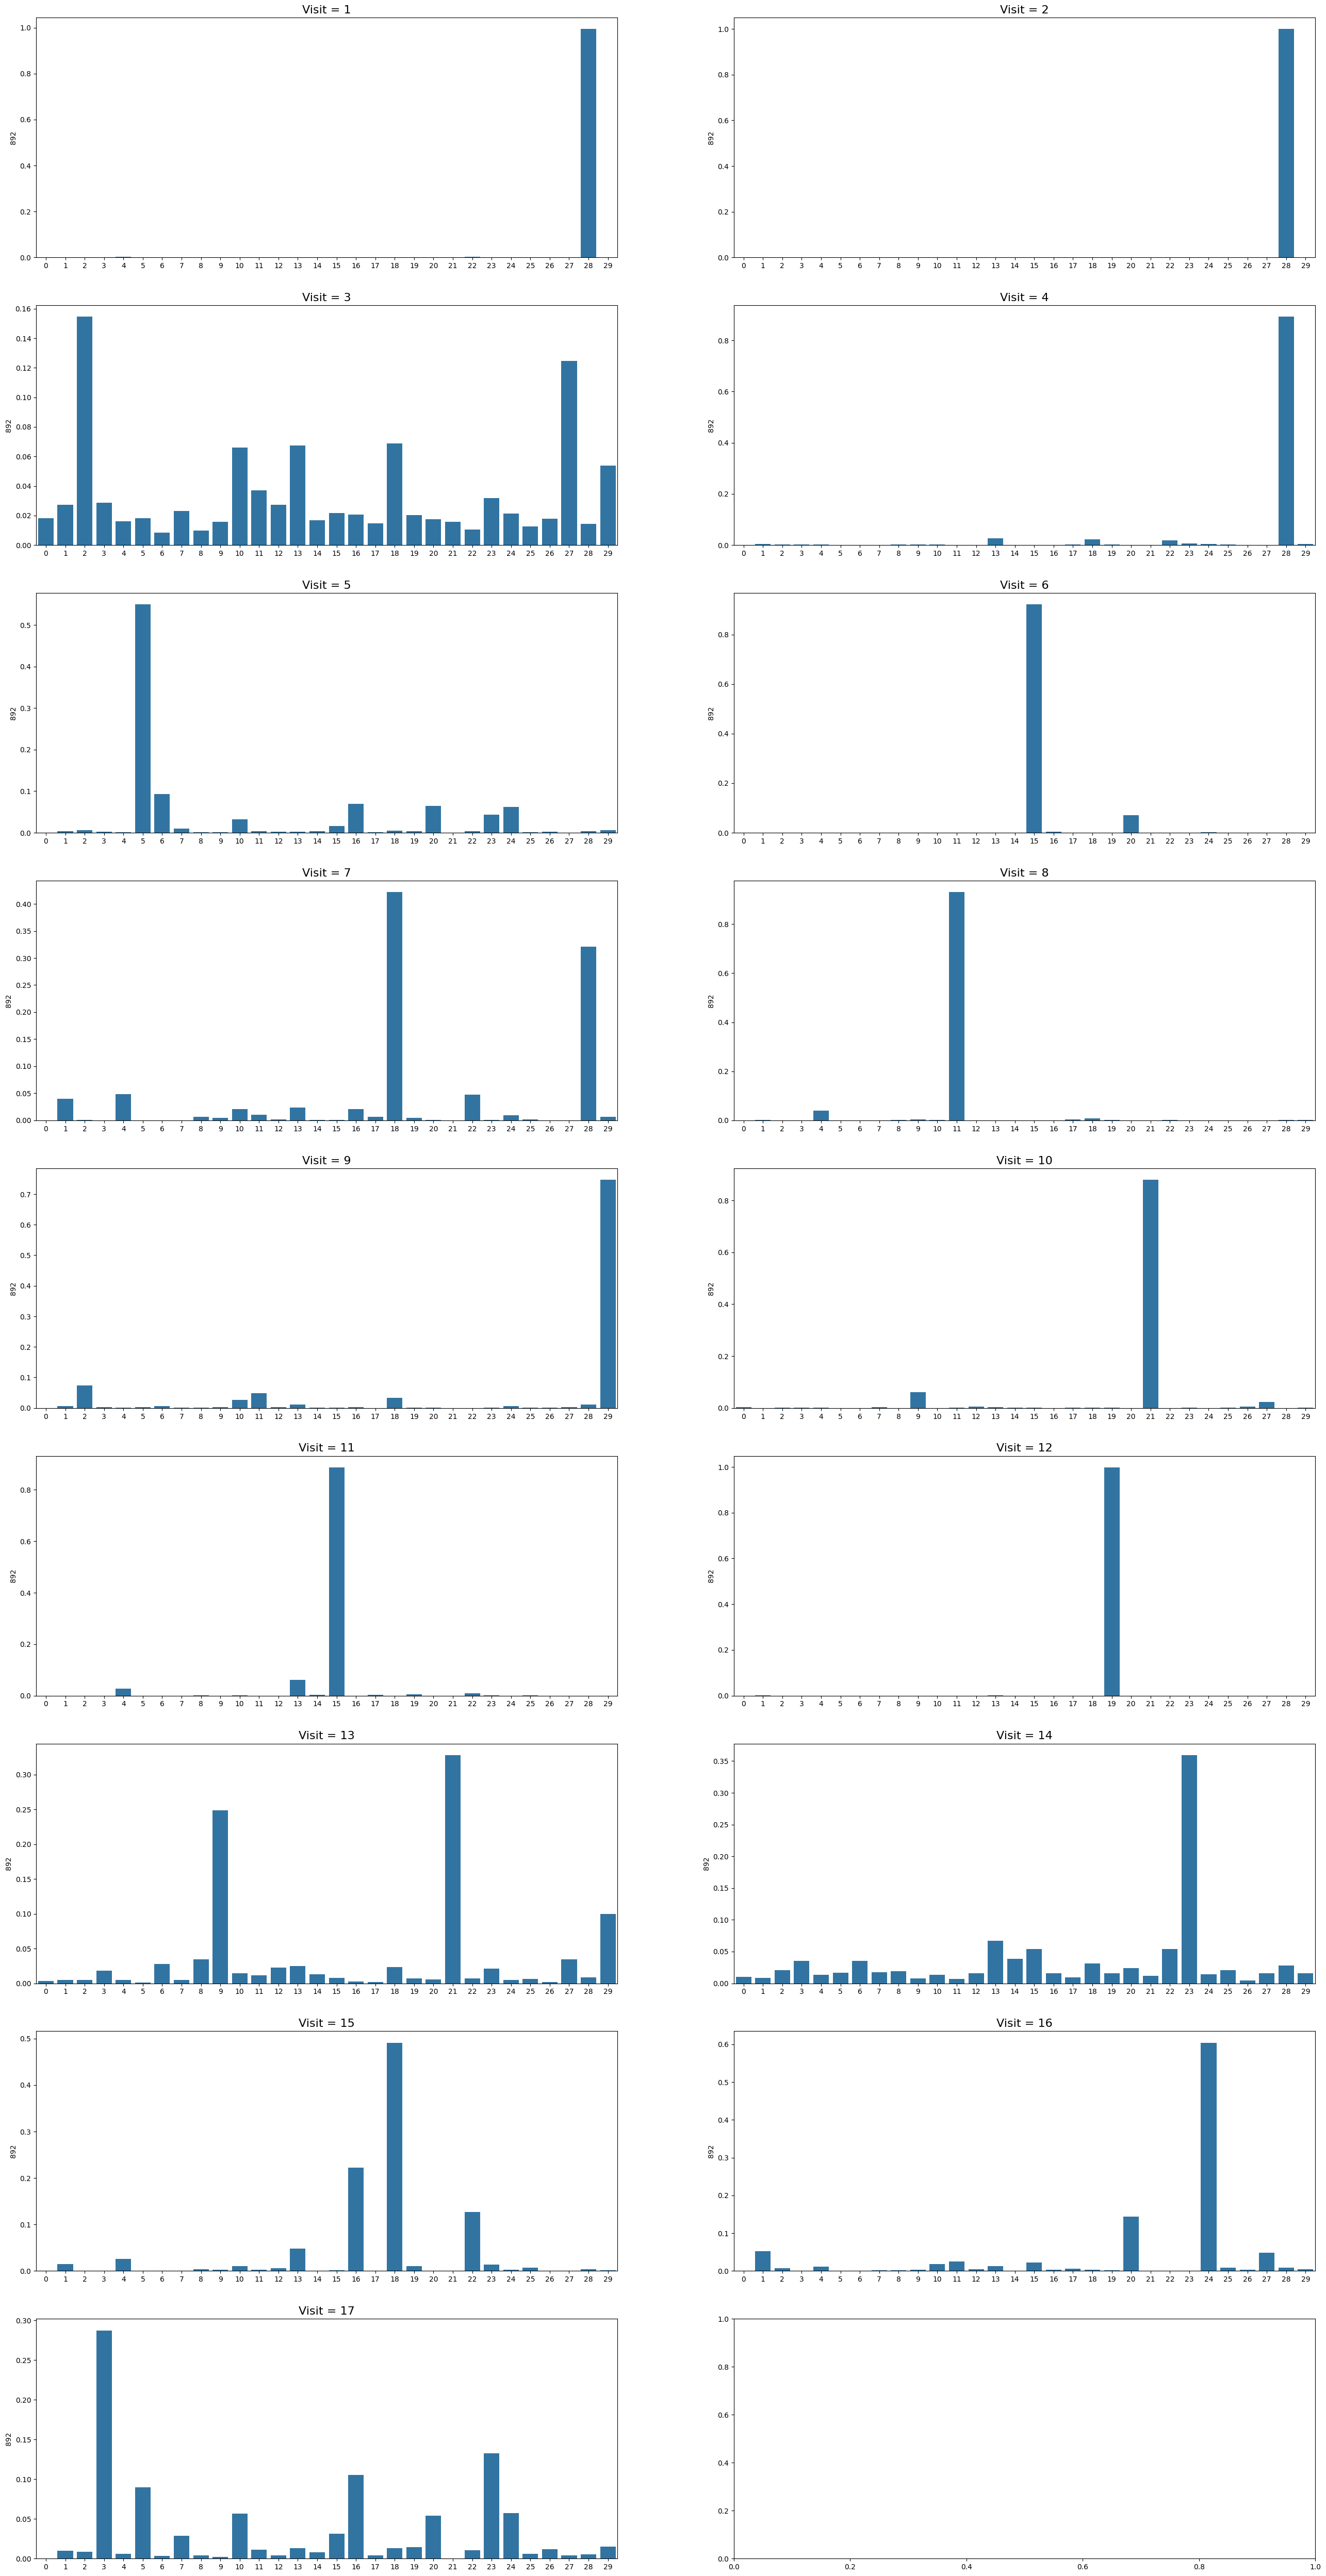

In [114]:
plot_group_clusters_attributions(892)

In [ ]:
#Start Mixture Model Global (with existing best_param pickle files)

In [27]:
individual_mode = False
Ks = [1, 2, 3, 4, 5]
#more k (mixture components), more time needed for the program to run, 5 is the max k value with a 1 interval for the k array
params = [(k, X_train, X_test, train_household_ids, test_household_ids, individual_mode) for k in Ks]
p_counts = cpu_count()

In [29]:
with ThreadPool(processes=p_counts) as pool:
    pool.map(process_with_k_mixtures, params)

###################################### Experiment with 1 mixture components ######################################
###################################### Experiment with 2 mixture components ######################################
###################################### Experiment with 3 mixture components ######################################
###################################### Experiment with 4 mixture components ######################################
###################################### Experiment with 5 mixture components ######################################
iteration 0
iteration 0
iteration 0
iteration 0
iteration 0
Loss: -3315344.219733
Loss: -3313615.638977
Loss: -3315344.219733
better loss on iteration 0: -3315344.2197328513
iteration 1
Loss: -3310936.478324
Loss: -3315344.219733
Loss: -3311631.707285
Loss: -3315344.219733
iteration 2
Loss: -3305931.252542
Loss: -3309969.137606
Loss: -3315344.219733
Loss: -3290100.144329
Loss: -3294148.467409
Loss: -3315344.219733
iterati

Visualize result for global model based on best_param_5.p of run_with_gamma (global param folder)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open('run_with_gamma/best_params_5.p', 'rb'))


In [30]:
test_log_likelihood

-850374.799137086

In [31]:
test_bic

1705818.1798533353

## Visualize cluster category probabilities

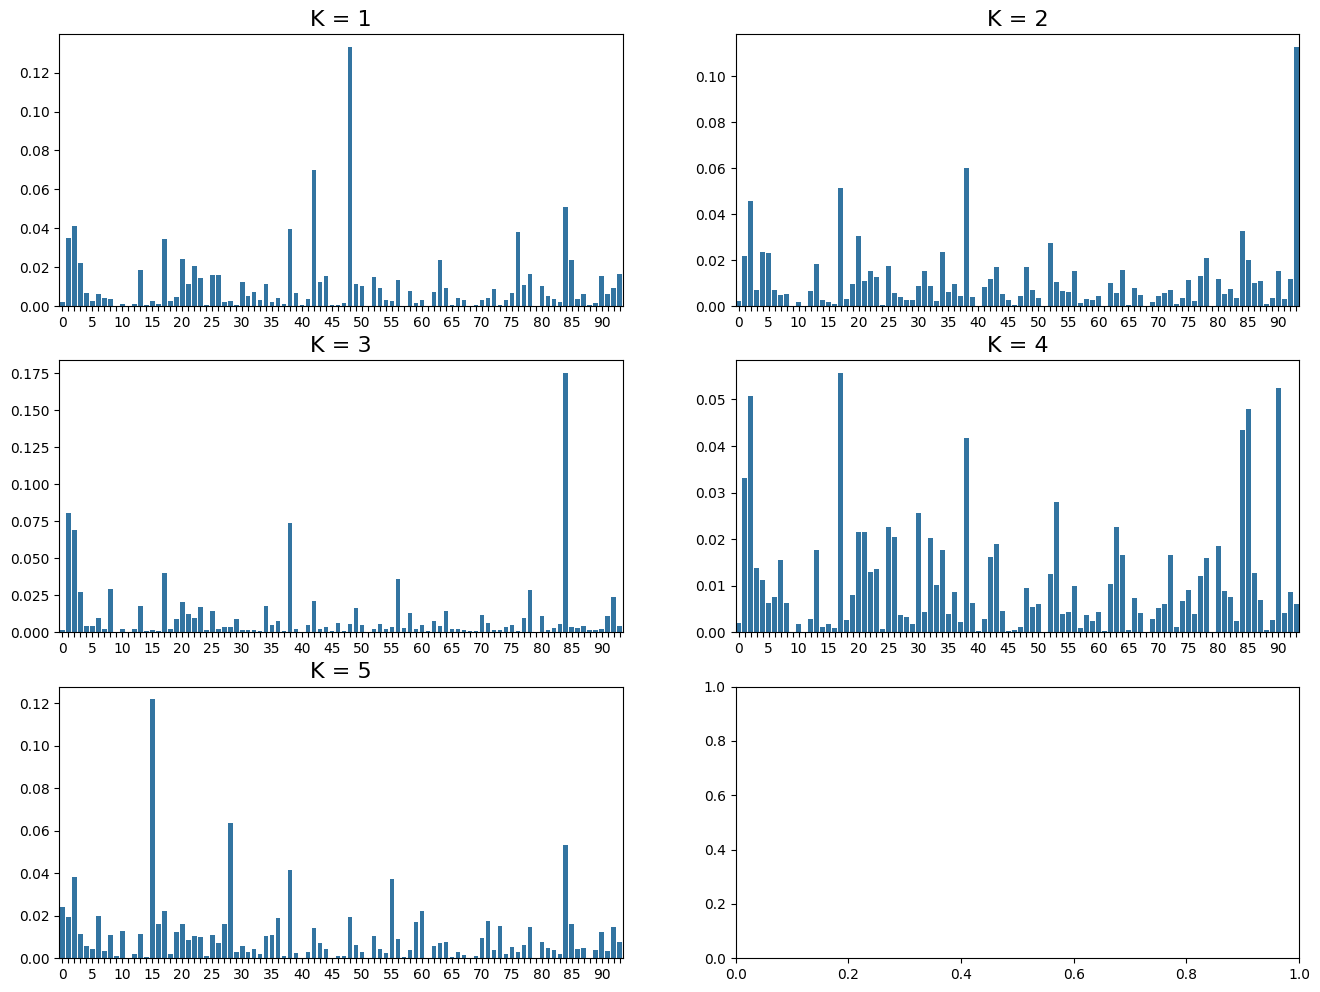

In [32]:
def hide_tick_labels(every_nth, ax):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

K, C = best_beta.shape
n_rows = ((K + 1) // 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16,n_rows*4))
axes = axes.ravel()
for k in range(K):
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[k])
    hide_tick_labels(5, axes[k])
    axes[k].set_title('K = %i' % (k+1), size=16)

## Visualize cluster distances

In [33]:
from sklearn.metrics.pairwise import manhattan_distances

beta_distances = manhattan_distances(best_beta)

In [34]:
beta_distances.shape

(5, 5)

In [35]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress="auto")
beta_distances_transformed = embedding.fit_transform(beta_distances)

C:\Users\USER\AppData\Local\Temp\ipykernel_16892\5890003.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(lgnd.legendHandles):


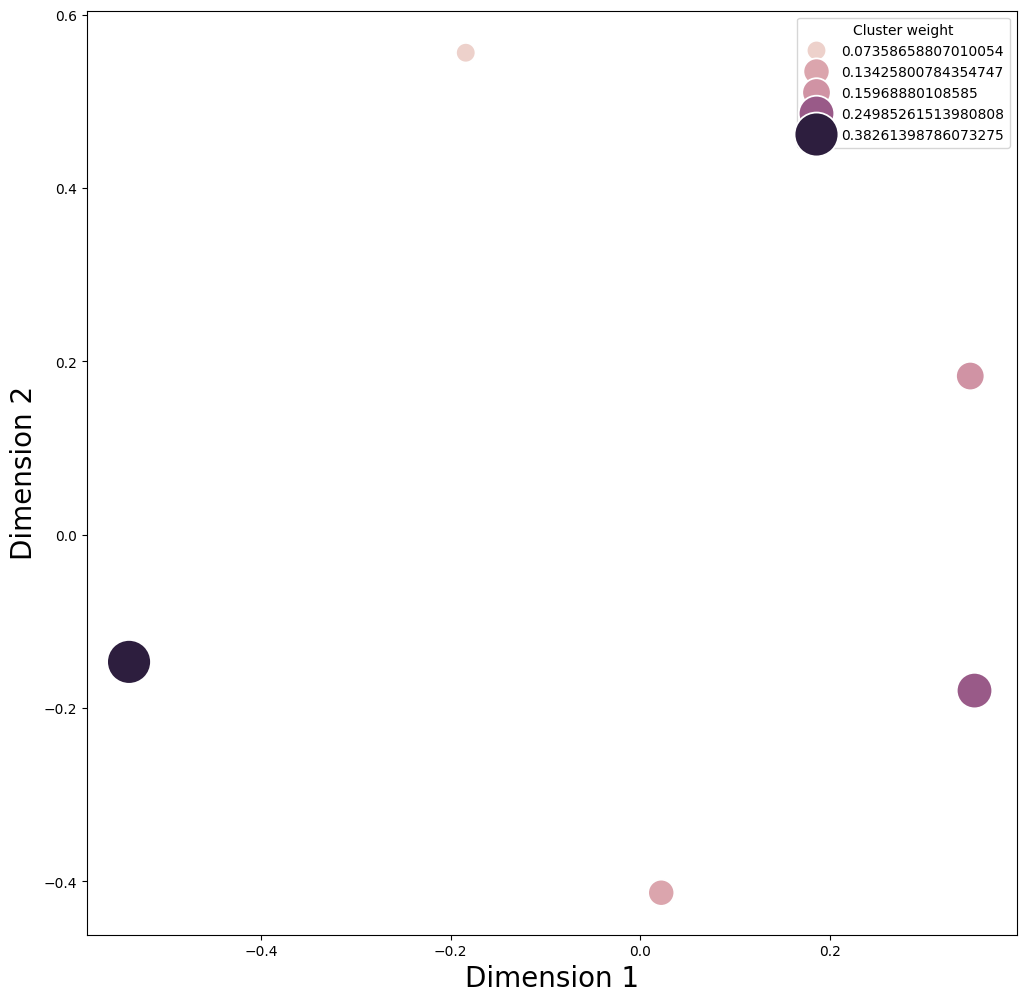

In [37]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x=beta_distances_transformed[:, 0], 
                     y=beta_distances_transformed[:, 1],
                     size=best_alpha,
                     hue=best_alpha,
                     sizes=(200, 1000))
ax.set_xlabel('Dimension 1', size=20)
ax.set_ylabel('Dimension 2', size=20)

# Plot legend.
lgnd = ax.legend(title='Cluster weight')
for i, handle in enumerate(lgnd.legendHandles):
    handle._sizes = [(i+1) * 5]

## Describe clusters by high lift items

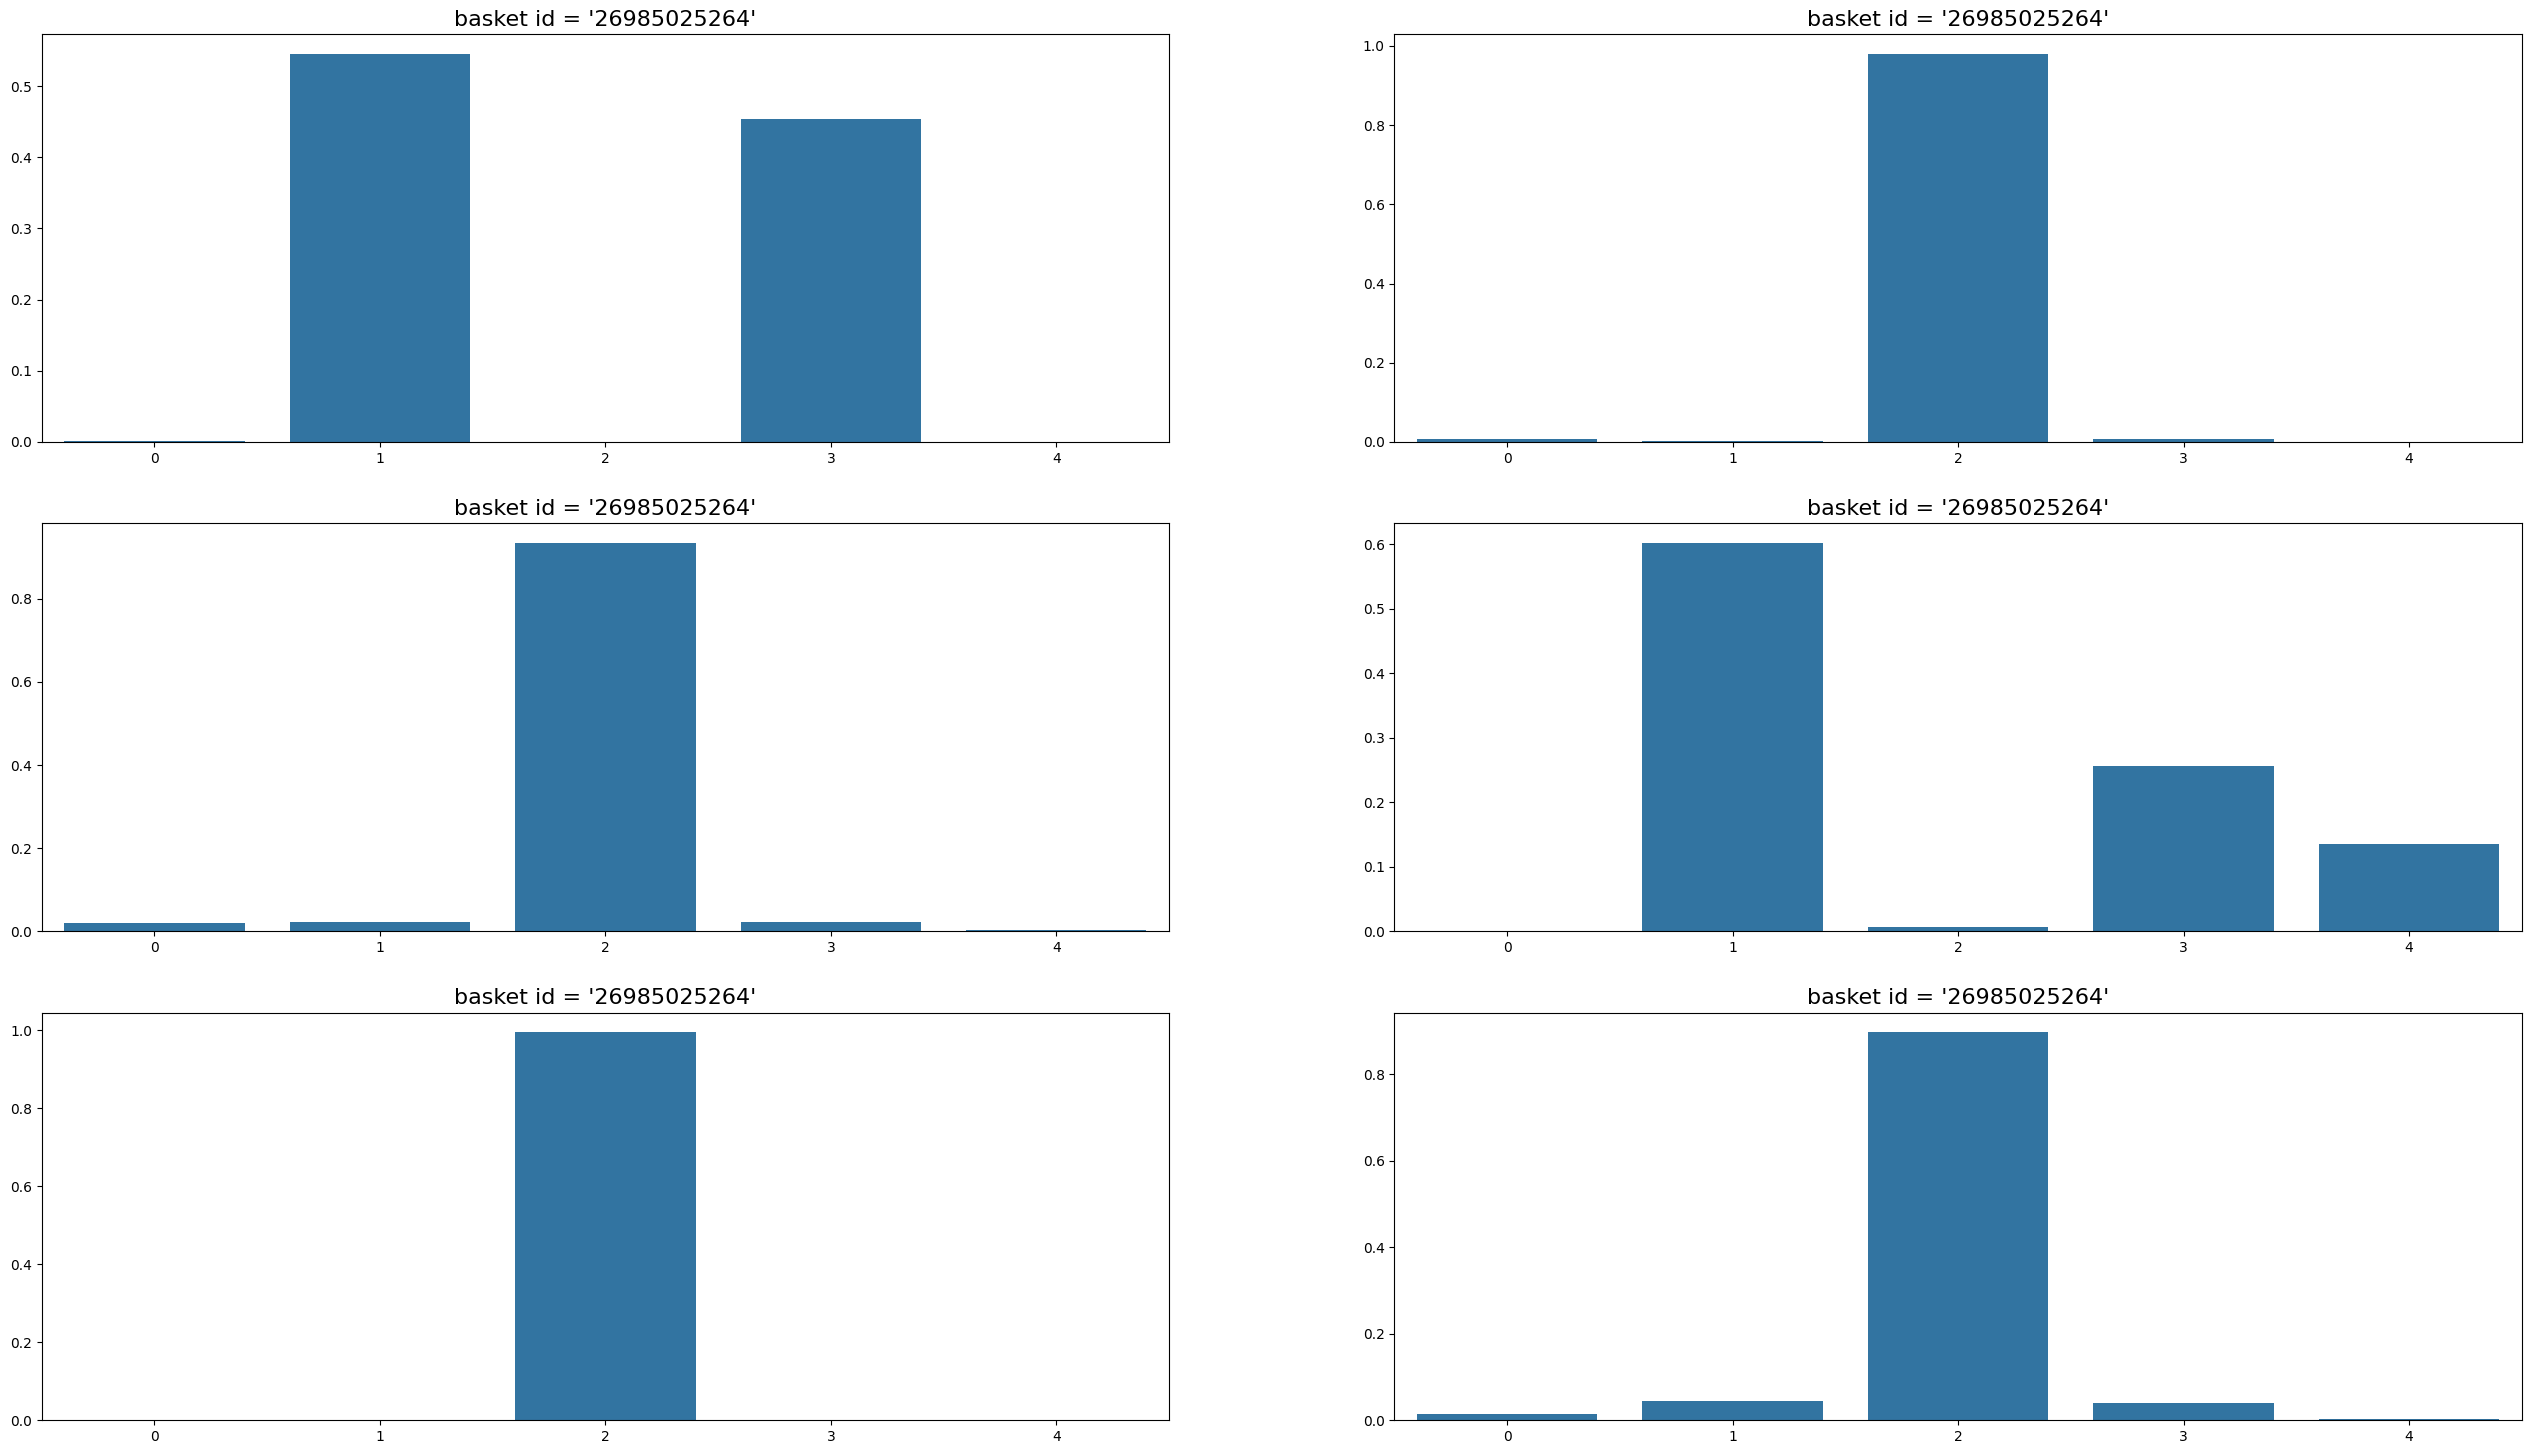

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32,18))
for i in range(6):
    sns.barplot(x=list(range(best_gamma.shape[1])), y=best_gamma[i], ax=axes[(i//2)][i%2])
    axes[(i//2)][i%2].set_title("basket id = '%s'" % train_grocery_df.BASKET_ID[:6][i], size=16)

__Compute global product purchase probabilities__

In [40]:
product_counts = train_grocery_df.groupby('PRODUCT_ID')['QUANTITY'].sum()
product_purchase_prob = product_counts / product_counts.sum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

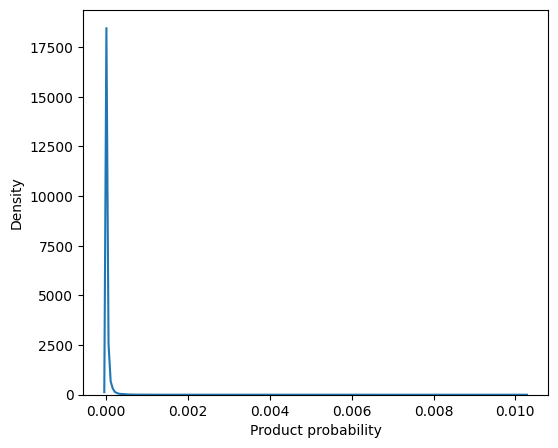

In [41]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(product_purchase_prob, ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [43]:
high_freq_items_prob = product_purchase_prob[product_purchase_prob > 0.0001]
high_freq_items_prob_df = pd.DataFrame(data={'Total purchase prob': high_freq_items_prob})
high_freq_items_prob_df.sort_values('Total purchase prob', ascending=False)

Total purchase prob
PRODUCT_ID                     
995242                 0.010237
1029743                0.007635
1133018                0.005806
981760                 0.005225
1106523                0.005187
...                         ...
9553382                0.000101
903609                 0.000101
943858                 0.000101
943362                 0.000101
862651                 0.000101

[2019 rows x 1 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

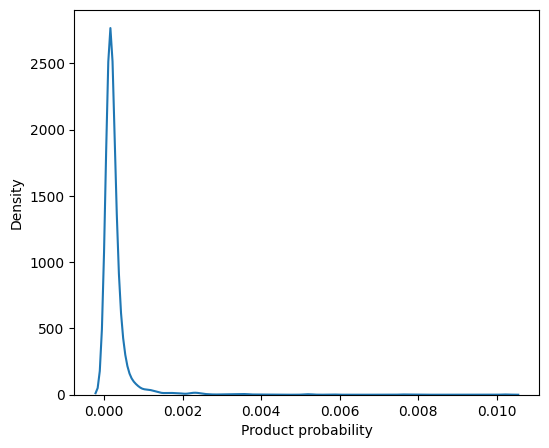

In [44]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(high_freq_items_prob_df['Total purchase prob'], ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [45]:
total_cluster_weights = best_gamma.sum(axis=0)

products_filepath = 'product.csv'
products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)

cluster_weights_by_basket_id = {}
for i, (individual_id, basket_id) in enumerate(train_counts_df.index):
    cluster_weights_by_basket_id[basket_id] = best_gamma[i]

def product_prob_for_component(g, k):
    total_product_cluster_weight = 0
    for basket_id in g['BASKET_ID']:
        total_product_cluster_weight += cluster_weights_by_basket_id[basket_id][k]
    return total_product_cluster_weight / total_cluster_weights[k]

def get_high_lift_frequent_items(k):
    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift.join(products_df, how='inner')

In [47]:
total_quantities = train_grocery_df['QUANTITY'].sum()

cluster_1_df = get_high_lift_frequent_items(k=0)
cluster_1_df['count'] = (cluster_1_df['Total purchase prob'] * total_quantities).astype(int)
weights = (cluster_1_df['Lift'] * cluster_1_df['count']).astype(int)
cluster_1_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(int)

In [48]:
cluster_1_df.head()

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
889779                 0.000134  51.652548           608    GROCERY  National   
1005861                0.000103  49.376137           608    GROCERY  National   
872702                 0.000142  49.369215           608    GROCERY  National   
915617                 0.000102  49.013673          1230    GROCERY  National   
881608                 0.000151  48.677215           608    GROCERY  National   

                    COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                           
889779      FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
1005861     FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
872702      FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
915617      FRZN MEAT/MEAT DINNERS  FRZN SS PREMIUM ENTREES/DNRS/N   
881608      FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   

           CURR_SIZE_OF_PRODUCT  count  repeat_weight  
PRODUCT_ID                                             
889779                    11 OZ    231             11  
1005861                 10.1 OZ    178              7  
872702                    11 OZ    245             11  
915617                    10 OZ    176              7  
881608                   9.9 OZ    262             12

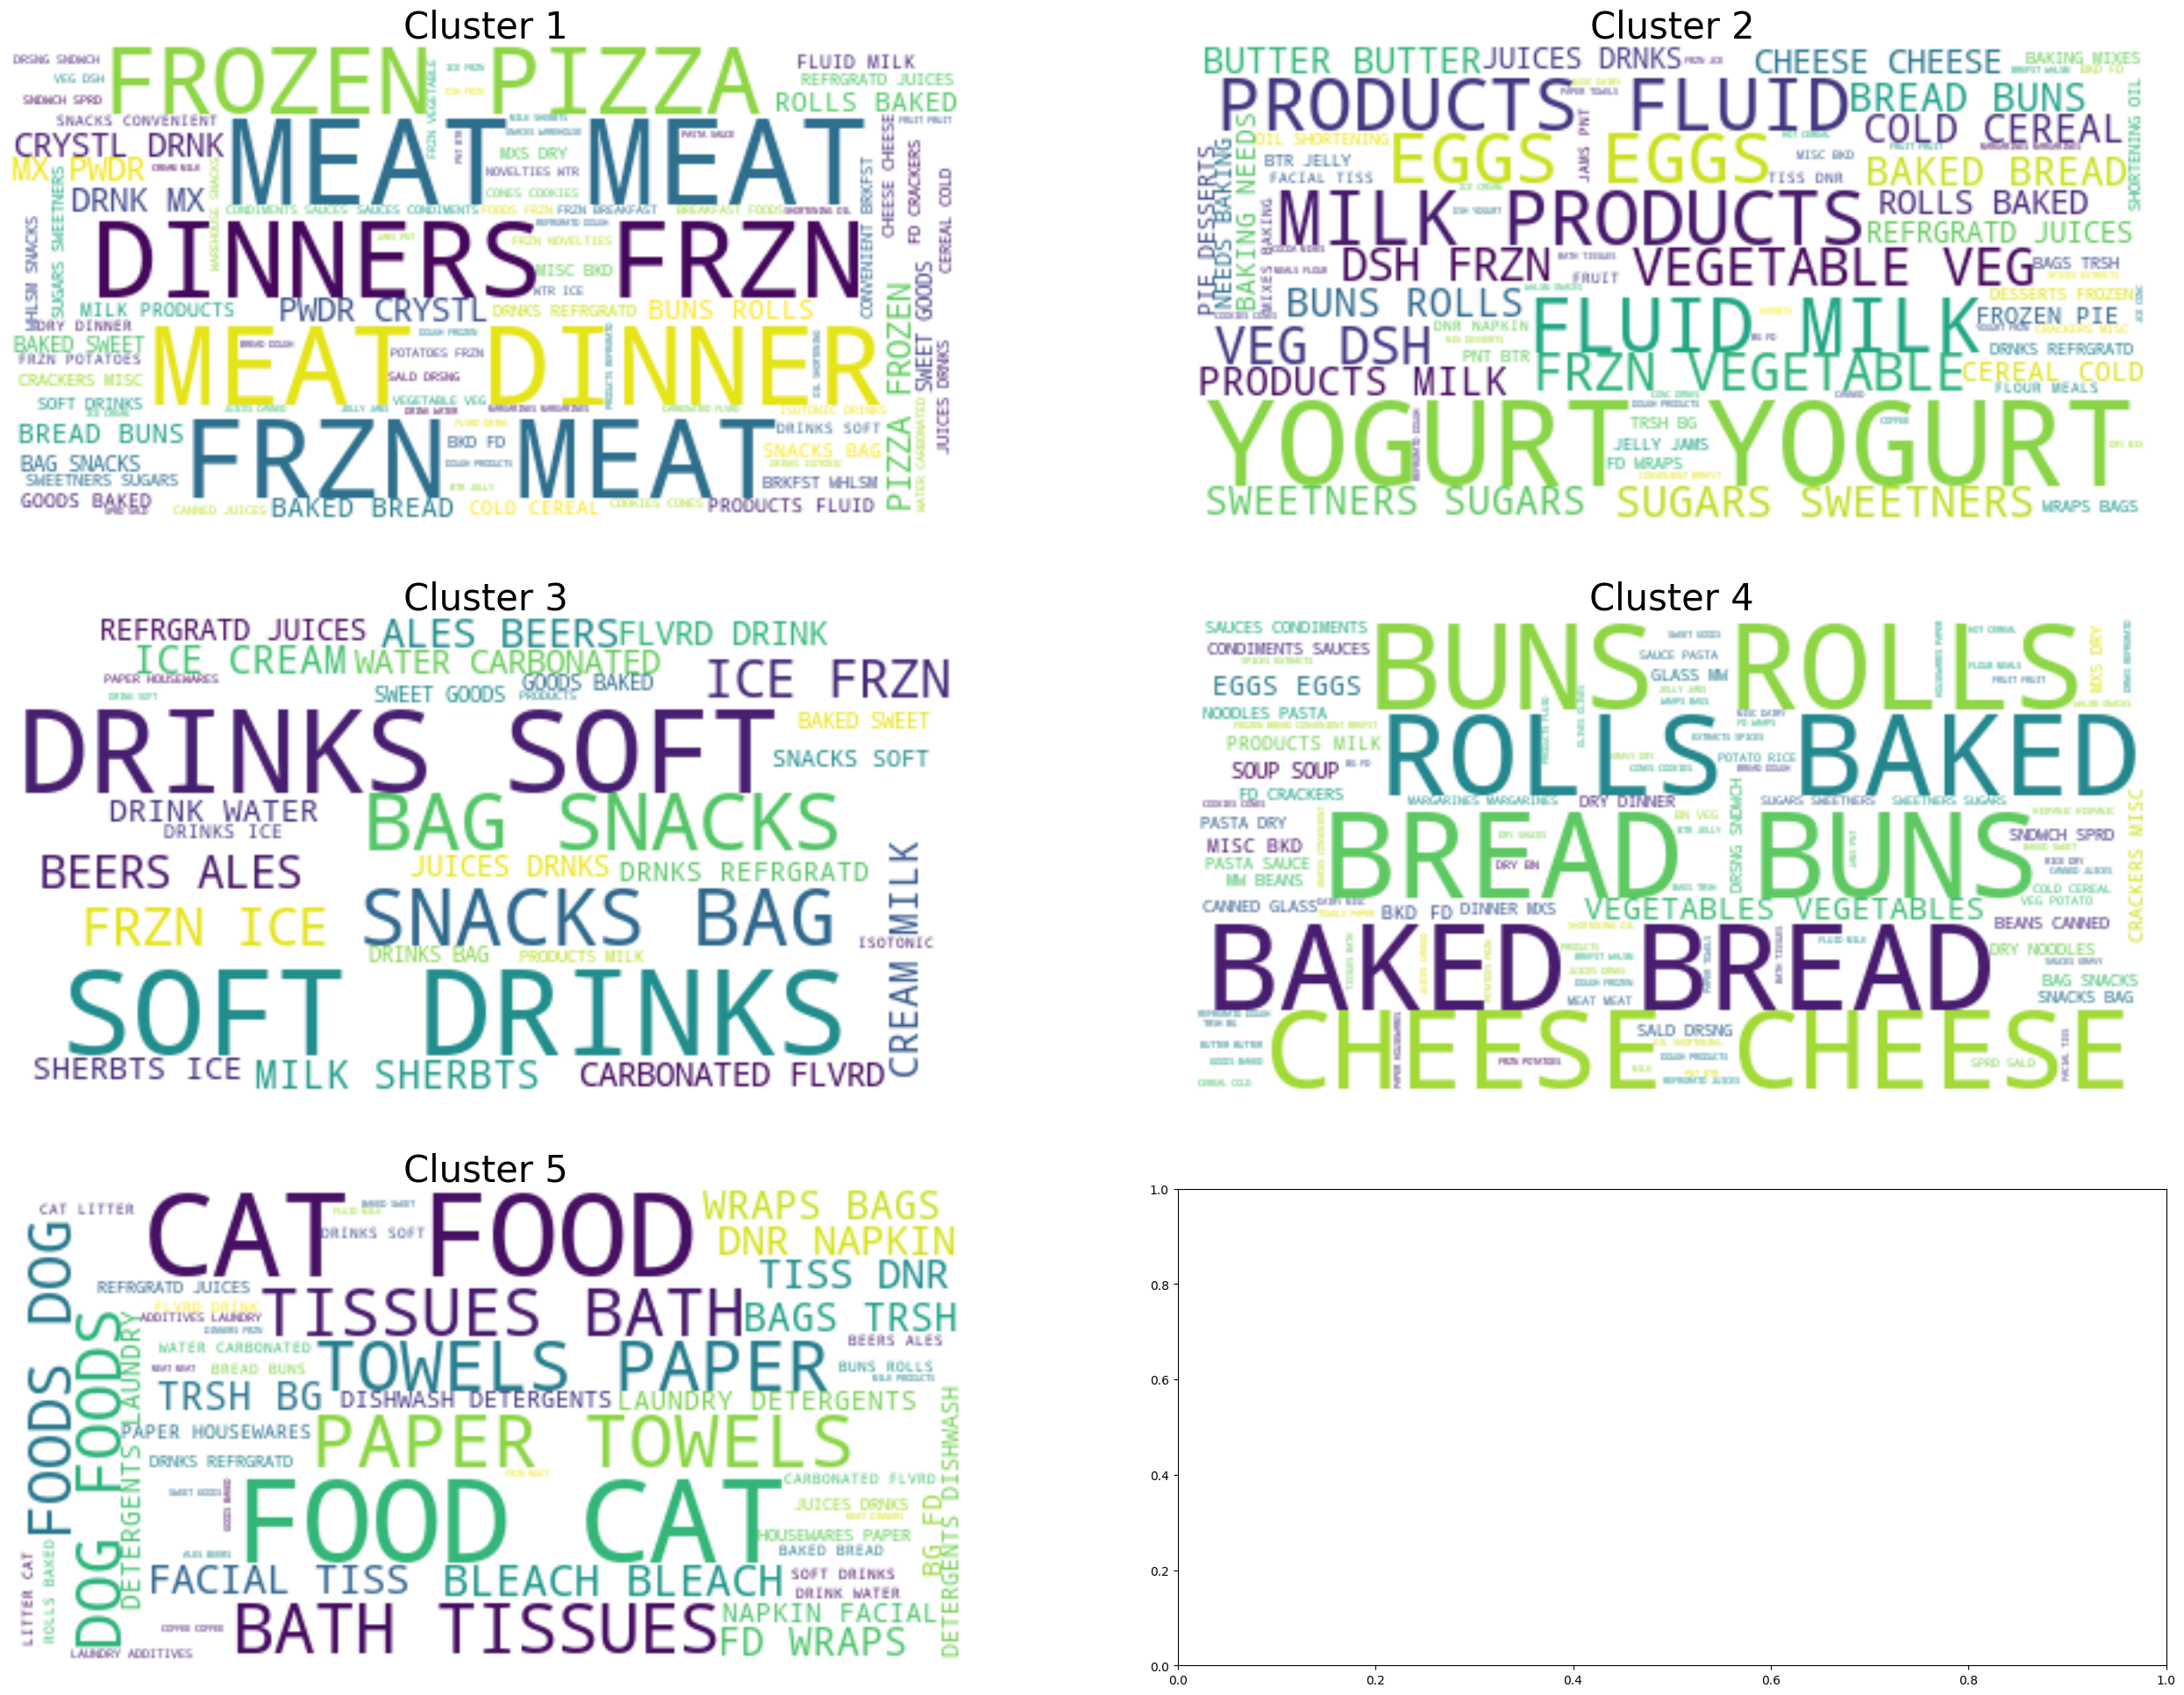

In [53]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

total_quantities = train_grocery_df['QUANTITY'].sum()

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32, 24))
axes = axes.ravel()

mixture_model_count=5

for i in range(mixture_model_count): 
    high_lift_items_df = get_high_lift_frequent_items(k=i) 
    high_lift_items_df['count'] = (high_lift_items_df['Total purchase prob'] * total_quantities).astype(int)
    weights = (high_lift_items_df['Lift'] * high_lift_items_df['count']).astype(int)
    high_lift_items_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(int)
    high_lift_items_df['COMMODITY_DESC'] = (high_lift_items_df['COMMODITY_DESC'] + ', ').str.replace('SHELF', '').str.replace('STABLE', '')
    description = high_lift_items_df['COMMODITY_DESC'].repeat(high_lift_items_df['repeat_weight']).str.cat(sep=', ')
    img = wordcloud.generate(description)
    ax = axes[i]
    ax.imshow(img, interpolation="bilinear")
    ax.axis("off")
    ax.set_title('Cluster %i' % (i+1), size=30)

### Now product associations

In [54]:
cluster_1_df.sort_values('Lift', ascending=False)

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
889779                 0.000134  51.652548           608    GROCERY  National   
1005861                0.000103  49.376137           608    GROCERY  National   
872702                 0.000142  49.369215           608    GROCERY  National   
915617                 0.000102  49.013673          1230    GROCERY  National   
881608                 0.000151  48.677215           608    GROCERY  National   
...                         ...        ...           ...        ...       ...   
1135768                0.000440  10.025982          1276    GROCERY  National   
1029504                0.000245  10.024304            69    GROCERY   Private   
1132789                0.000144  10.012609           436    GROCERY  National   
1110292                0.000187  10.006709           236    GROCERY  National   
844818                 0.000324  10.001541           544    GROCERY  National   

                      COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                             
889779        FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
1005861       FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
872702        FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
915617        FRZN MEAT/MEAT DINNERS  FRZN SS PREMIUM ENTREES/DNRS/N   
881608        FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
...                              ...                             ...   
1135768              ISOTONIC DRINKS    ISOTONIC DRINKS SINGLE SERVE   
1029504                   BAG SNACKS                        PRETZELS   
1132789       REFRGRATD JUICES/DRNKS  DAIRY CASE 100% PURE JUICE - O   
1110292     REFRGRATD DOUGH PRODUCTS   REFRIGERATED BISCUITS REGULAR   
844818                    BAG SNACKS                      CORN CHIPS   

           CURR_SIZE_OF_PRODUCT  count  repeat_weight  
PRODUCT_ID                                             
889779                    11 OZ    231             11  
1005861                 10.1 OZ    178              7  
872702                    11 OZ    245             11  
915617                    10 OZ    176              7  
881608                   9.9 OZ    262             12  
...                         ...    ...            ...  
1135768                   32 OZ    762              6  
1029504                    15OZ    424              2  
1132789                   64 OZ    250              0  
1110292                 16.3 OZ    323              1  
844818                    10 OZ    560              4  

[837 rows x 10 columns]

In [55]:
import itertools

cluster1_highest_lift_product_ids = cluster_1_df.sort_values('Lift', ascending=False).index[:5]
cluster1_highest_lift_product_pairs = list(itertools.combinations(cluster1_highest_lift_product_ids, 2))
len(cluster1_highest_lift_product_pairs)

10

In [56]:
from tqdm import tqdm
from collections import defaultdict

nb_baskets = len(train_grocery_df['BASKET_ID'].unique())
total_cluster_weight = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in train_grocery_df['BASKET_ID'].unique()])

basket_ids_with_pair_by_pair = defaultdict(list)
for i, g in tqdm(train_grocery_df.groupby('BASKET_ID')):
    for pair in cluster1_highest_lift_product_pairs:
        if ((g['PRODUCT_ID'] == pair[0]).sum() > 0) and ((g['PRODUCT_ID'] == pair[1]).sum() > 0):
            basket_ids_with_pair_by_pair[pair].append(g['BASKET_ID'].iloc[0])

pair_lifts = {}
for pair, basket_ids in basket_ids_with_pair_by_pair.items():
    total_proba = len(basket_ids) / nb_baskets
    cluster_pair_proba = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in basket_ids]) / total_cluster_weight
    pair_lifts[pair] = cluster_pair_proba / total_proba    

100%|██████████| 172328/172328 [02:59<00:00, 960.14it/s] 


In [57]:
pair_lifts

{(889779, 1005861): 7.430084508320545,
 (1005861, 881608): 7.44646712516275,
 (889779, 872702): 7.370237005055048,
 (1005861, 872702): 7.009937590023234,
 (872702, 881608): 7.383831261713385,
 (889779, 881608): 7.368711488039409,
 (872702, 915617): 7.44834528725891}

In [59]:
products_df[(products_df.index == 872702) | (products_df.index == 1005861)]

MANUFACTURER DEPARTMENT     BRAND          COMMODITY_DESC  \
PRODUCT_ID                                                              
872702               608    GROCERY  National  FRZN MEAT/MEAT DINNERS   
1005861              608    GROCERY  National  FRZN MEAT/MEAT DINNERS   

                        SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                                                       
872702      SS ECONOMY ENTREES/DINNERS ALL                11 OZ  
1005861     SS ECONOMY ENTREES/DINNERS ALL              10.1 OZ

Global Predictive Profile

<Axes: >

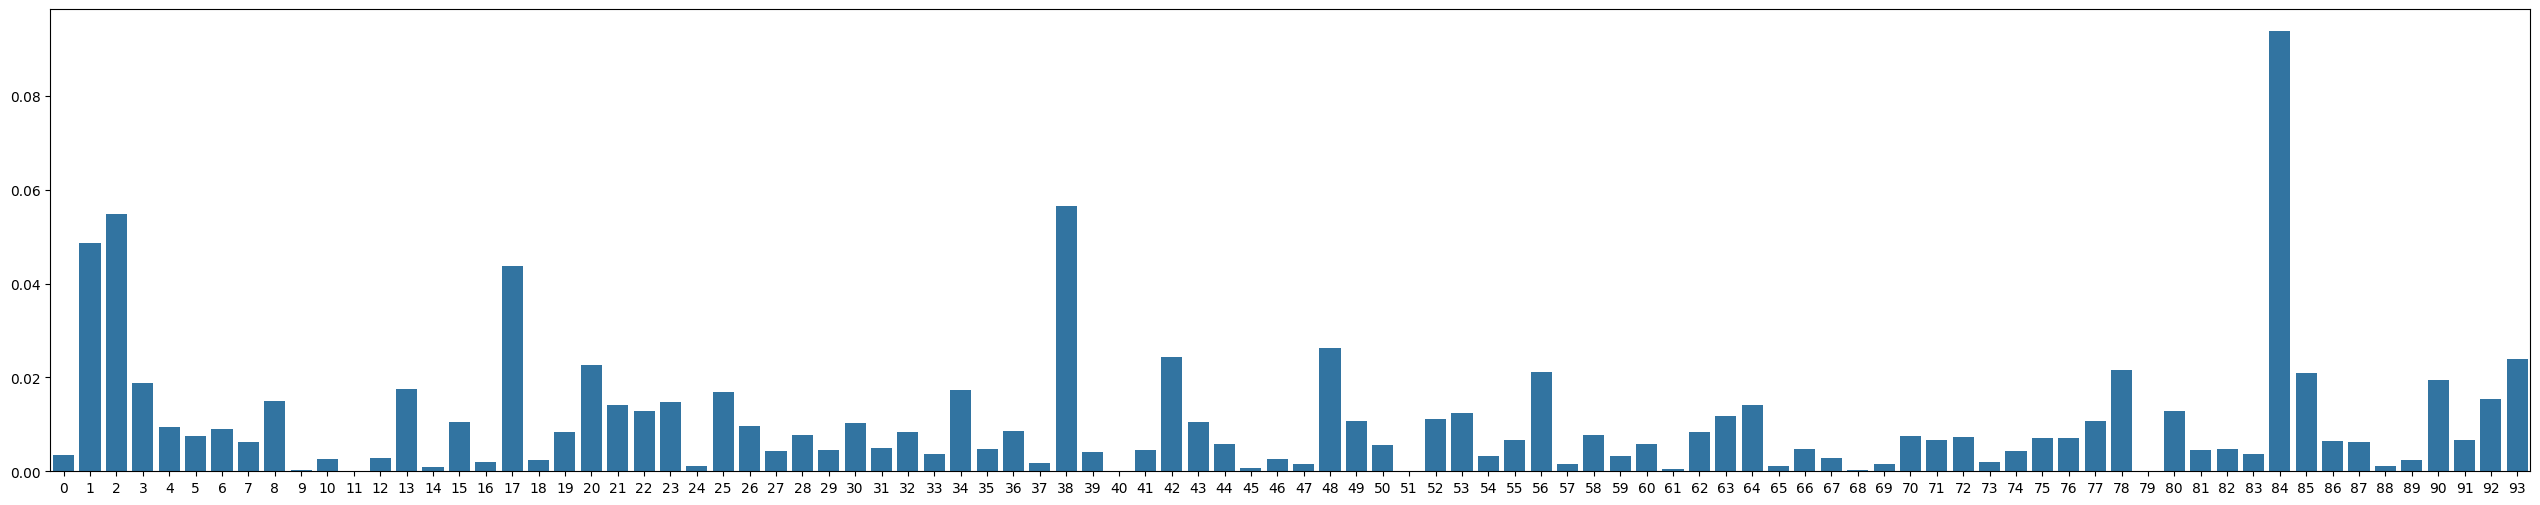

In [60]:
weighted_multi = best_alpha.reshape(-1, 1) * best_beta
global_predictive_profile = weighted_multi.sum(axis=0) / weighted_multi.sum()

plt.subplots(figsize=(32,6))
sns.barplot(x=np.arange(best_beta.shape[1]), y=global_predictive_profile)

__same thing by sampling__

Text(0, 0.5, 'Purchase probability')

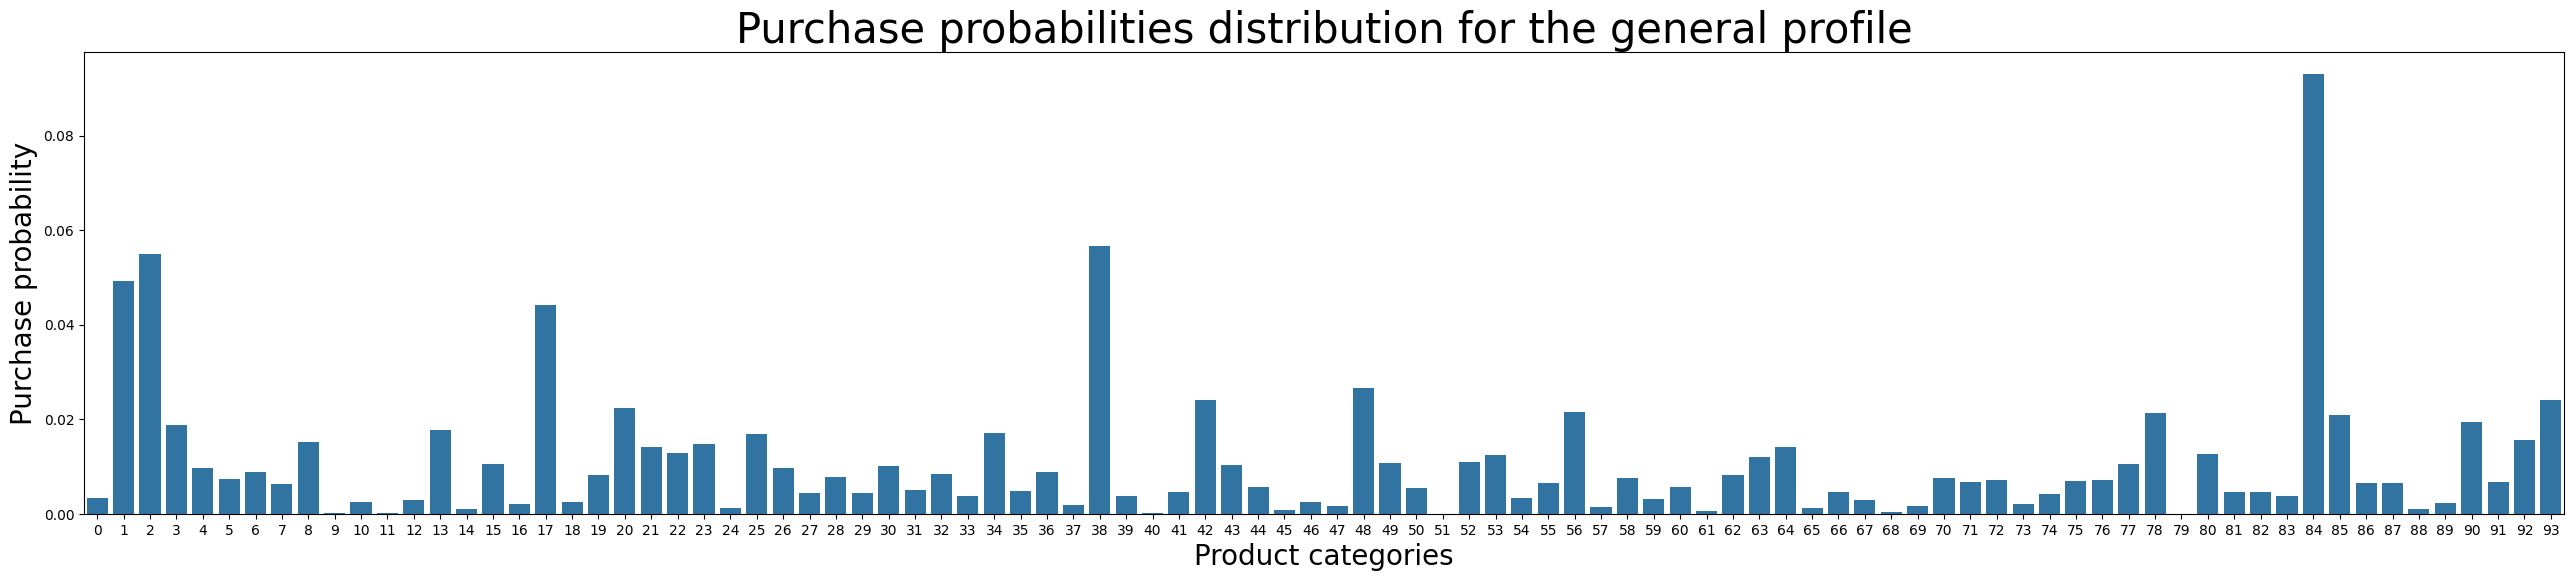

In [61]:
from scipy.stats import multinomial

K, C = best_beta.shape
n=100000
total = np.zeros((C))
for k in range(K):
    k_samples = best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=1000)
    total += k_samples.sum(axis=0)
probs = total / total.sum()

plt.subplots(figsize=(32,6))
ax = sns.barplot(x=np.arange(probs.size), y=probs)
ax.set_title('Purchase probabilities distribution for the general profile', size=30)
ax.set_xlabel('Product categories', size=20)
ax.set_ylabel('Purchase probability', size=20)

__Now using cluster assignments__

In [62]:
best_gamma_df = pd.DataFrame(best_gamma, index=train_household_ids)
best_gamma_df.head()

0         1         2         3         4
household_key                                                  
1              0.000837  0.545512  0.000001  0.453638  0.000012
1              0.008422  0.003112  0.980286  0.007328  0.000853
1              0.019218  0.021270  0.934635  0.021427  0.003450
1              0.000877  0.602332  0.006214  0.255845  0.134733
1              0.001338  0.001567  0.995777  0.001196  0.000122

In [63]:
test_counts_df.index = test_counts_df.index.droplevel()

In [64]:
from scipy.special import logsumexp

def compute_complete_predictive_profile(household_key):
    household_assignments = best_gamma_df[best_gamma_df.index == household_key]

    K, C = best_beta.shape
    total = np.zeros(C)
    for i, assignment in household_assignments.iterrows():
        for k in range(assignment.size):
            i_k_samples = assignment[k] * best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=100)
            total += i_k_samples.sum(axis=0)
    probs = total / total.sum()
    return probs
    
def compute_household_test_purchase(household_key):
    test_basket_ids=test_grocery_df.loc[test_grocery_df['household_key'] == household_key, 'BASKET_ID'].unique()
    household_test_counts_df = test_counts_df[test_counts_df.index.isin(test_basket_ids)].sum(axis=0)
    return household_test_counts_df / household_test_counts_df.sum()
    
def plot_prediction_vs_reality(household_key):
    fig, axes = plt.subplots(nrows=2, figsize=(32,14))
    axes = axes.ravel()
    
    predictive_probs = compute_complete_predictive_profile(household_key)
    sns.barplot(x=np.arange(predictive_probs.size), y=predictive_probs, ax=axes[0])
    axes[0].set_title('Purchases probabilities prediction for household %s' % str(household_key), size=20)
    axes[0].set_xlabel('Categories', size=20)
    axes[0].set_ylabel('Probability', size=20)

    test_probs = compute_household_test_purchase(household_key)
    sns.barplot(x=np.arange(test_probs.size), y=test_probs, ax=axes[1])
    axes[1].set_title('Purchases from the test set for household %s' % str(household_key), size=20)
    axes[1].set_xlabel('Categories', size=20)
    axes[1].set_ylabel('Probability', size=20)

    l1_distance = np.abs(predictive_probs - test_probs).sum()
    plt.text(0.5, -0.25, 'L1 distance between prediction and test data: %.3f' % l1_distance,
             horizontalalignment='center', verticalalignment='center', transform = axes[1].transAxes, size=30)

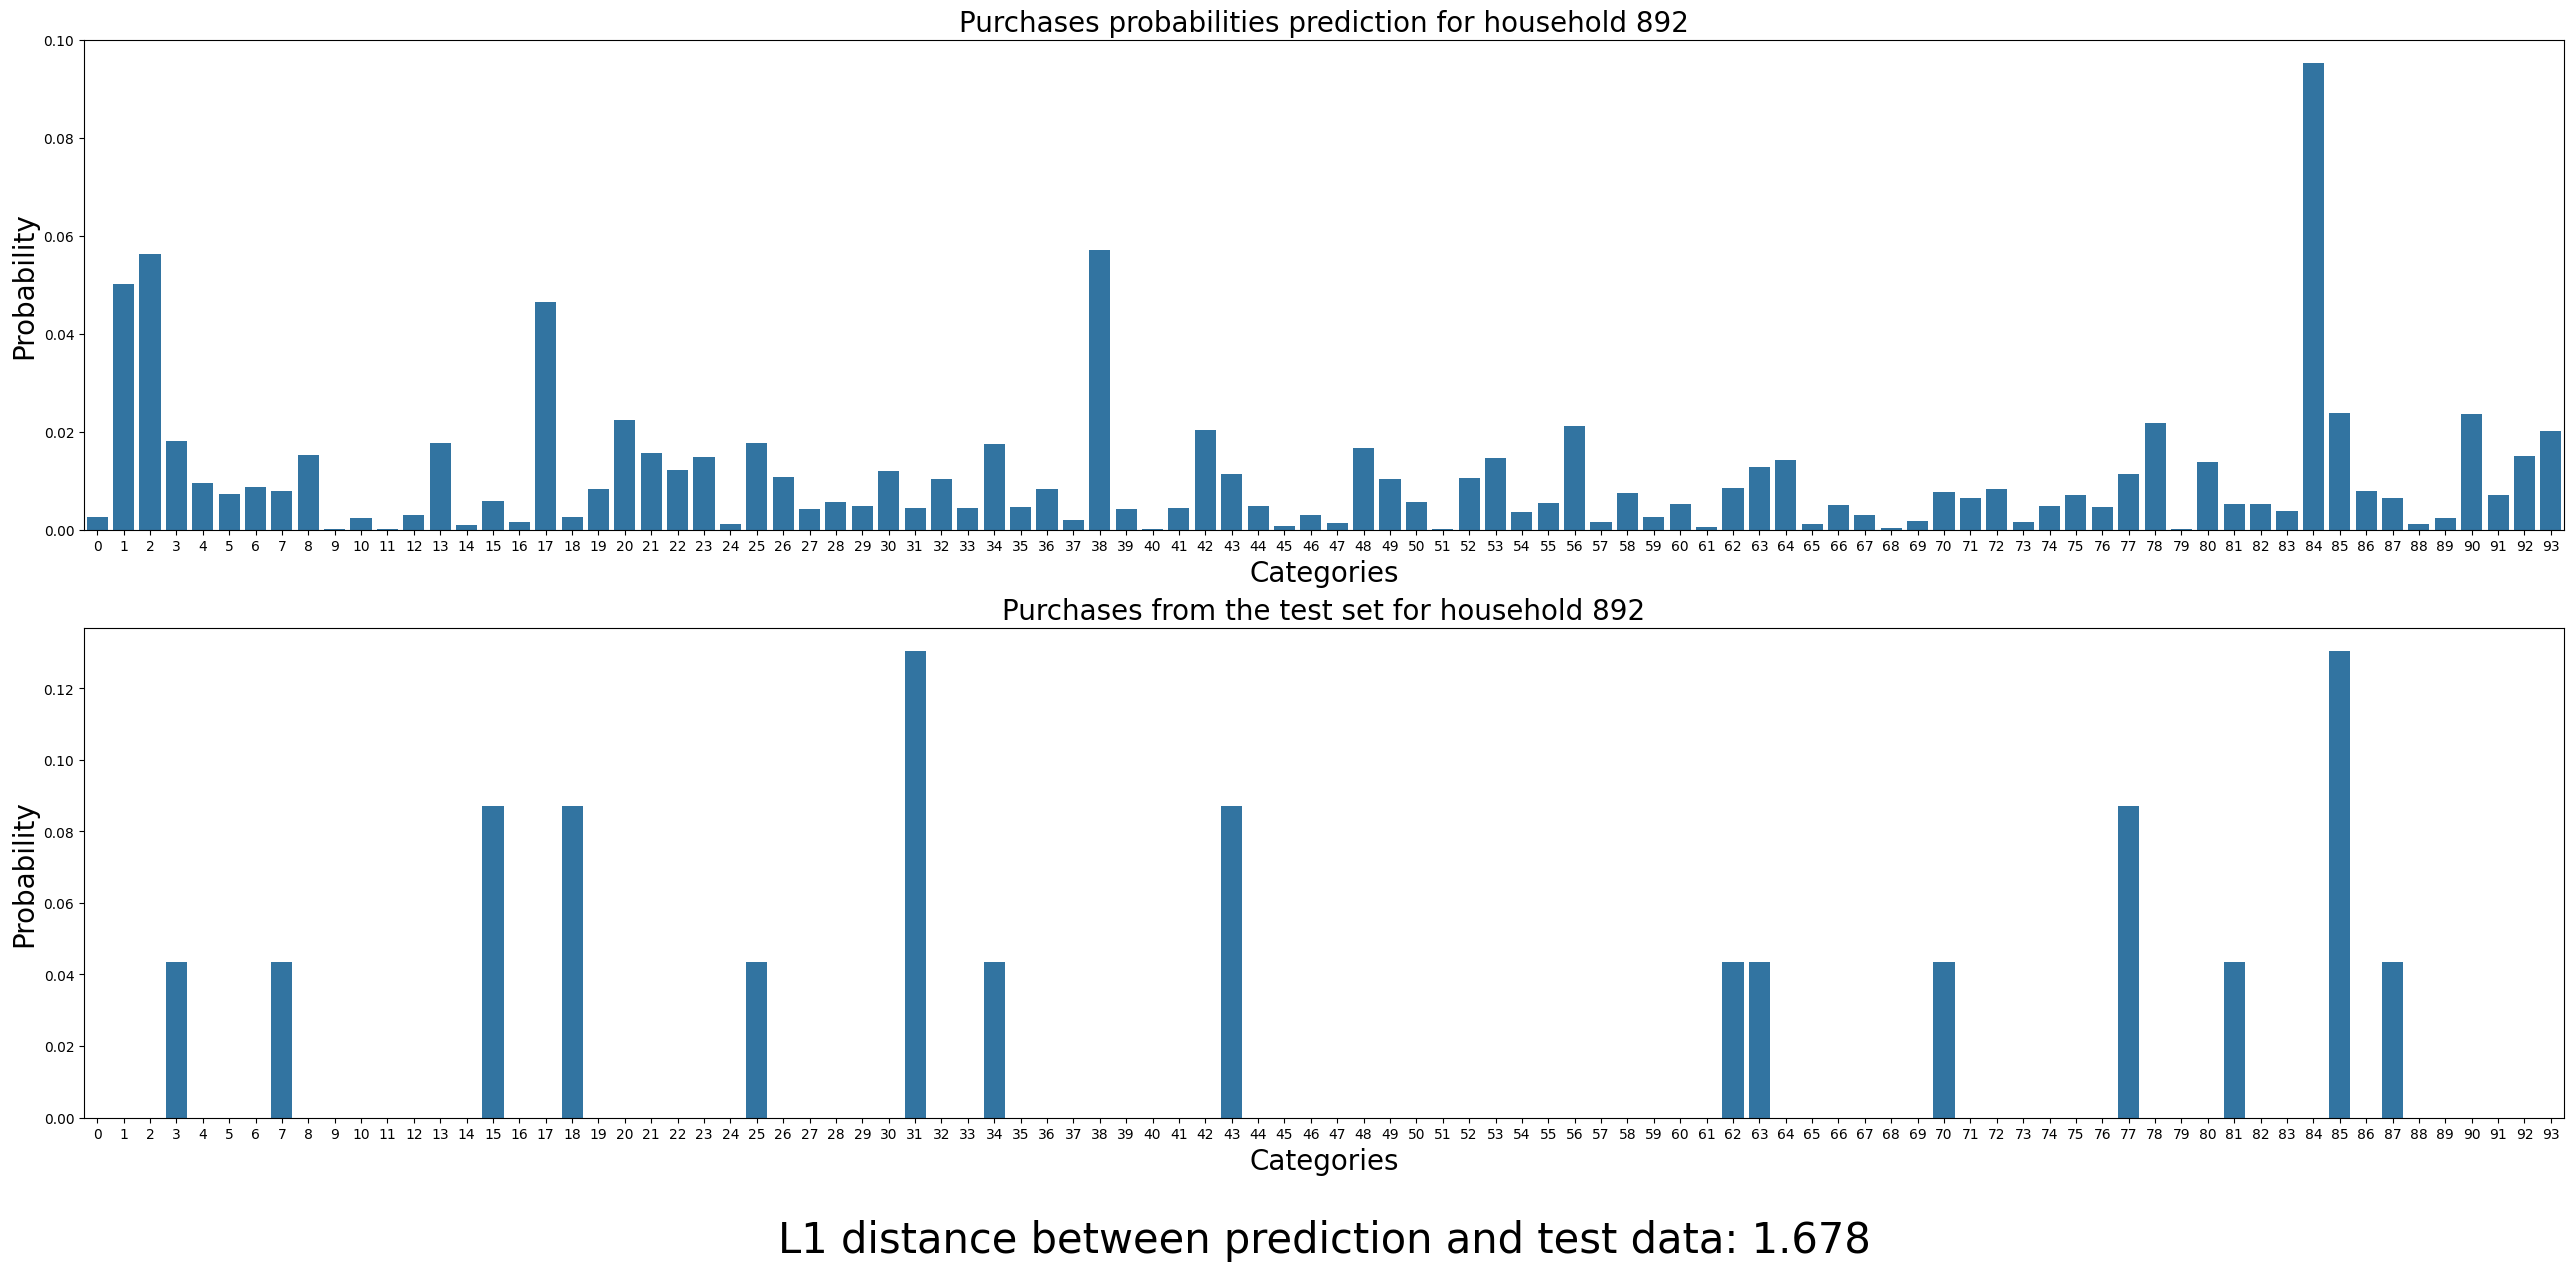

In [65]:
plot_prediction_vs_reality(892)

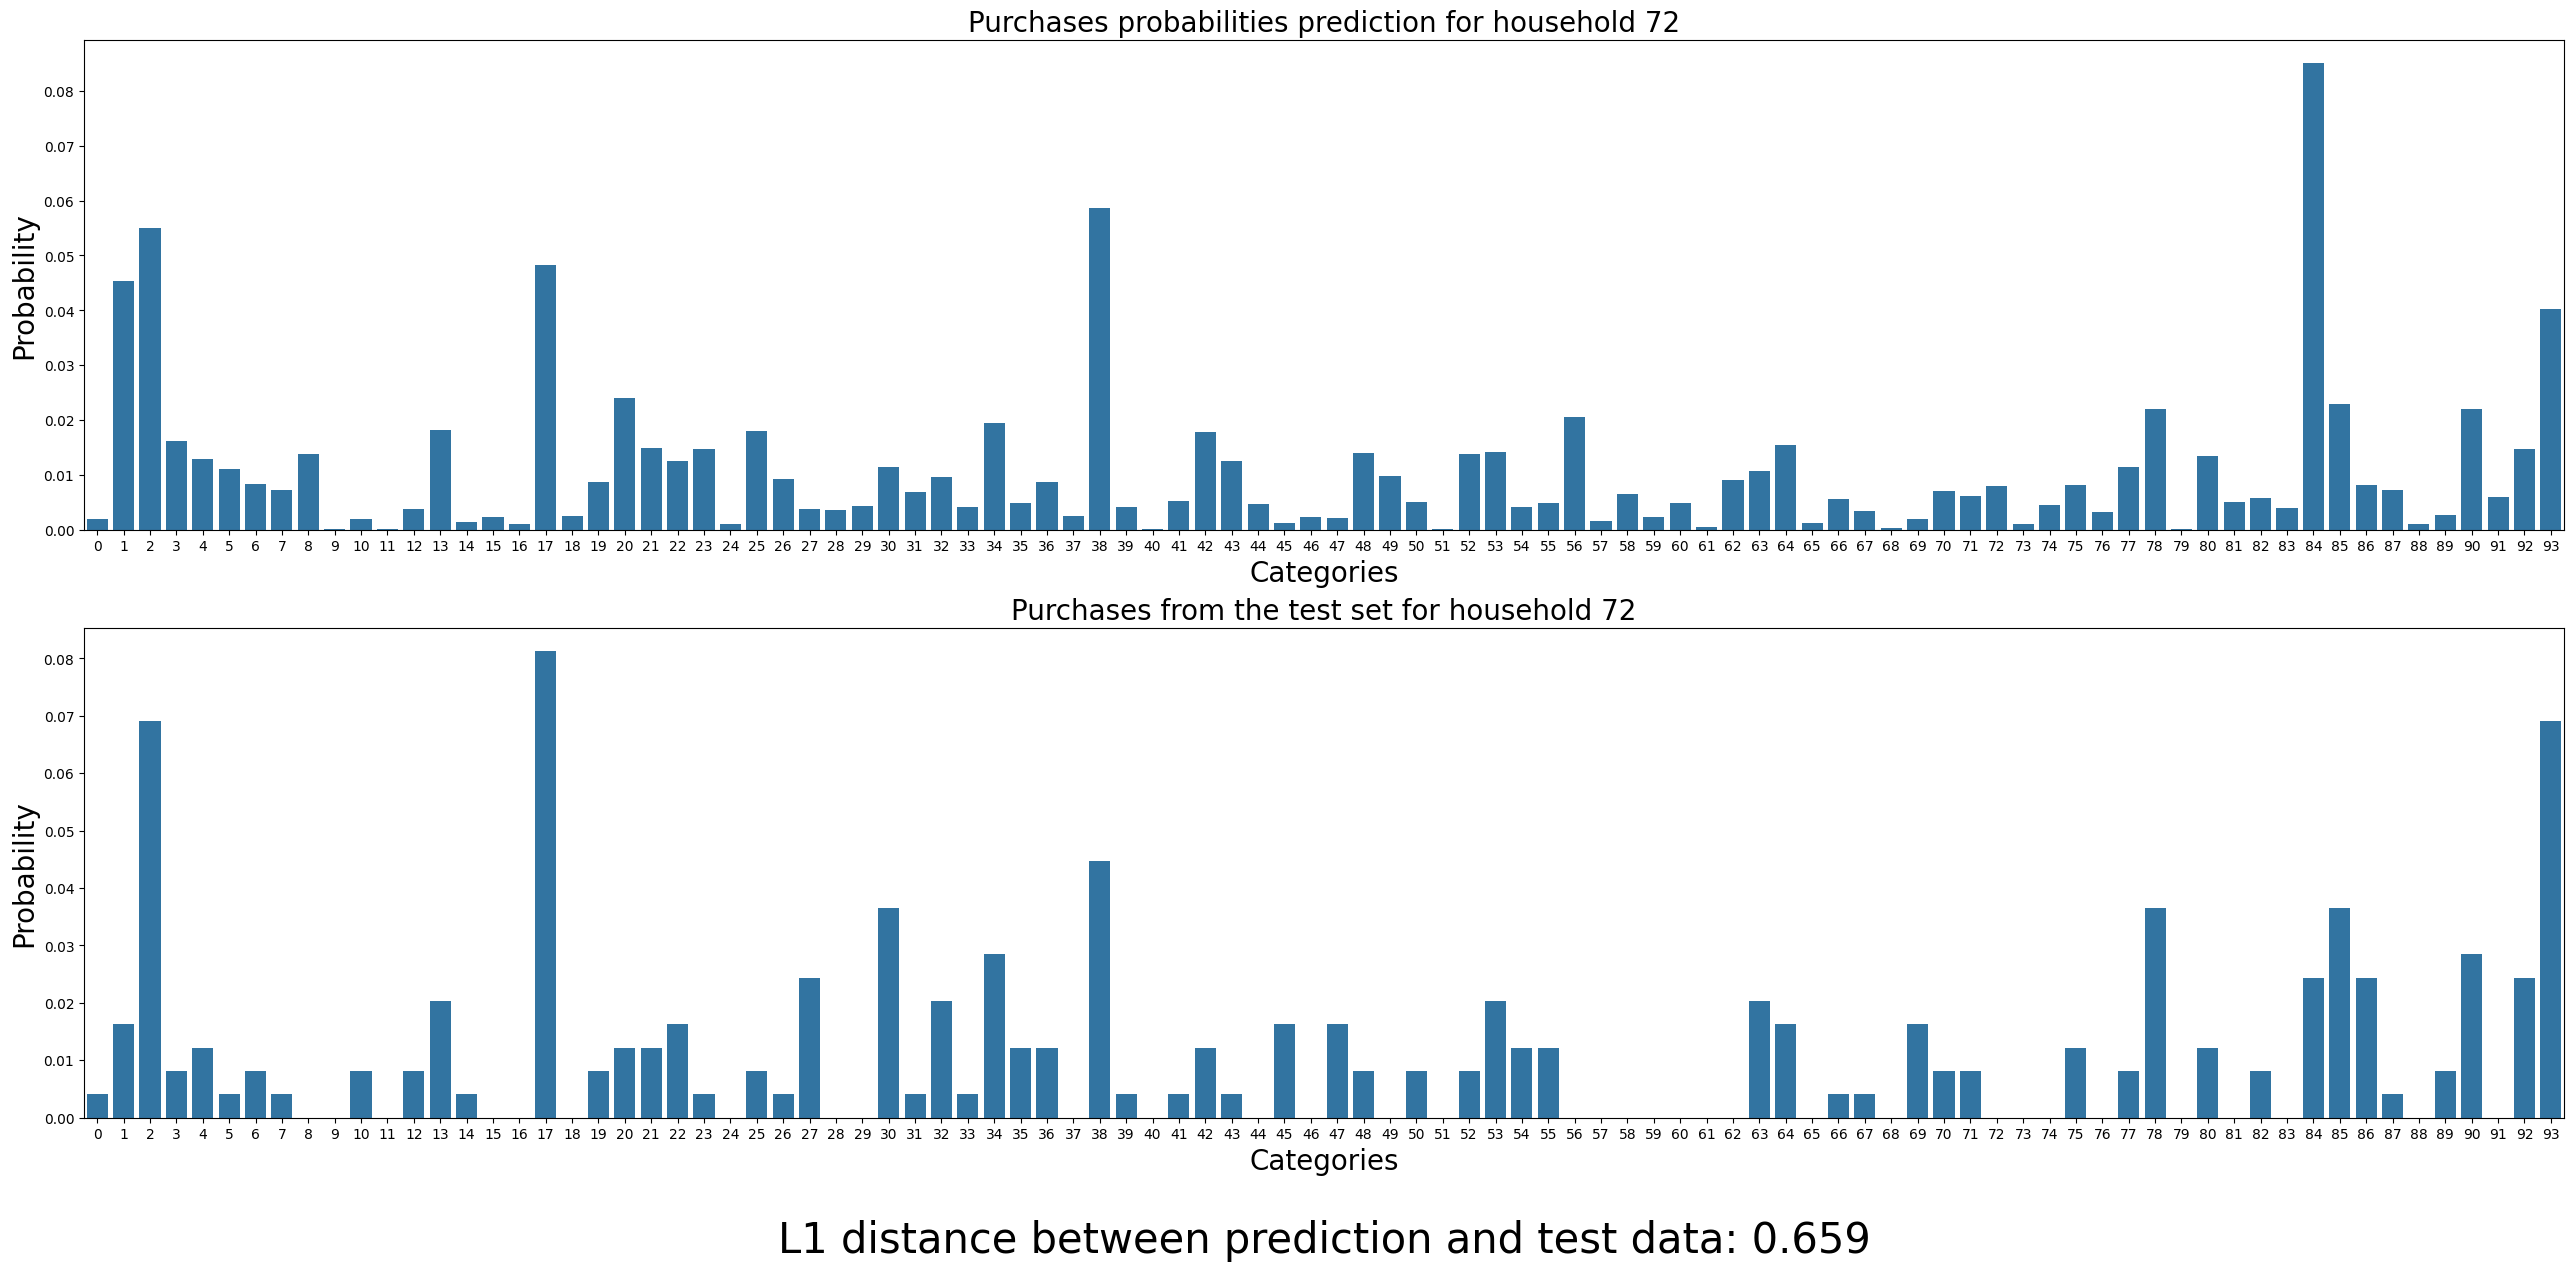

In [66]:
plot_prediction_vs_reality(72)

In [67]:
from tqdm import tqdm

unique_test_household_ids = test_grocery_df['household_key'].unique()
predictions_distances = {}
for household_id in tqdm(unique_test_household_ids):
    predictive_probs = compute_complete_predictive_profile(household_id)
    test_probs = compute_household_test_purchase(household_id)
    l1_distance = np.abs(predictive_probs - test_probs).sum()
    predictions_distances[household_id] = l1_distance

 86%|████████▋ | 2038/2361 [10:11<00:47,  6.75it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_16892\3972107922.py:12: RuntimeWarning: divide by zero encountered in divide
  probs = total / total.sum()
C:\Users\USER\AppData\Local\Temp\ipykernel_16892\3972107922.py:12: RuntimeWarning: invalid value encountered in divide
  probs = total / total.sum()
100%|██████████| 2361/2361 [10:46<00:00,  3.65it/s]


In [68]:
pickle.dump(predictions_distances, open('predictions_distances.p', 'wb'))

### Check individuals cluster assignments stability

In [69]:
def plot_group_clusters_attributions(household_key):
    g = best_gamma_df.groupby(best_gamma_df.index).get_group(household_key).copy()
    n, c = g.shape
    fig, axes = plt.subplots(nrows=((n+1) // 2), ncols=2, figsize=(32,64))
    for i in range(n):
        sns.barplot(x=list(range(g.shape[1])), y=g.iloc[i], ax=axes[(i//2)][i%2])
        axes[(i//2)][i%2].set_title('Visit = %i' % (i+1), size=16)

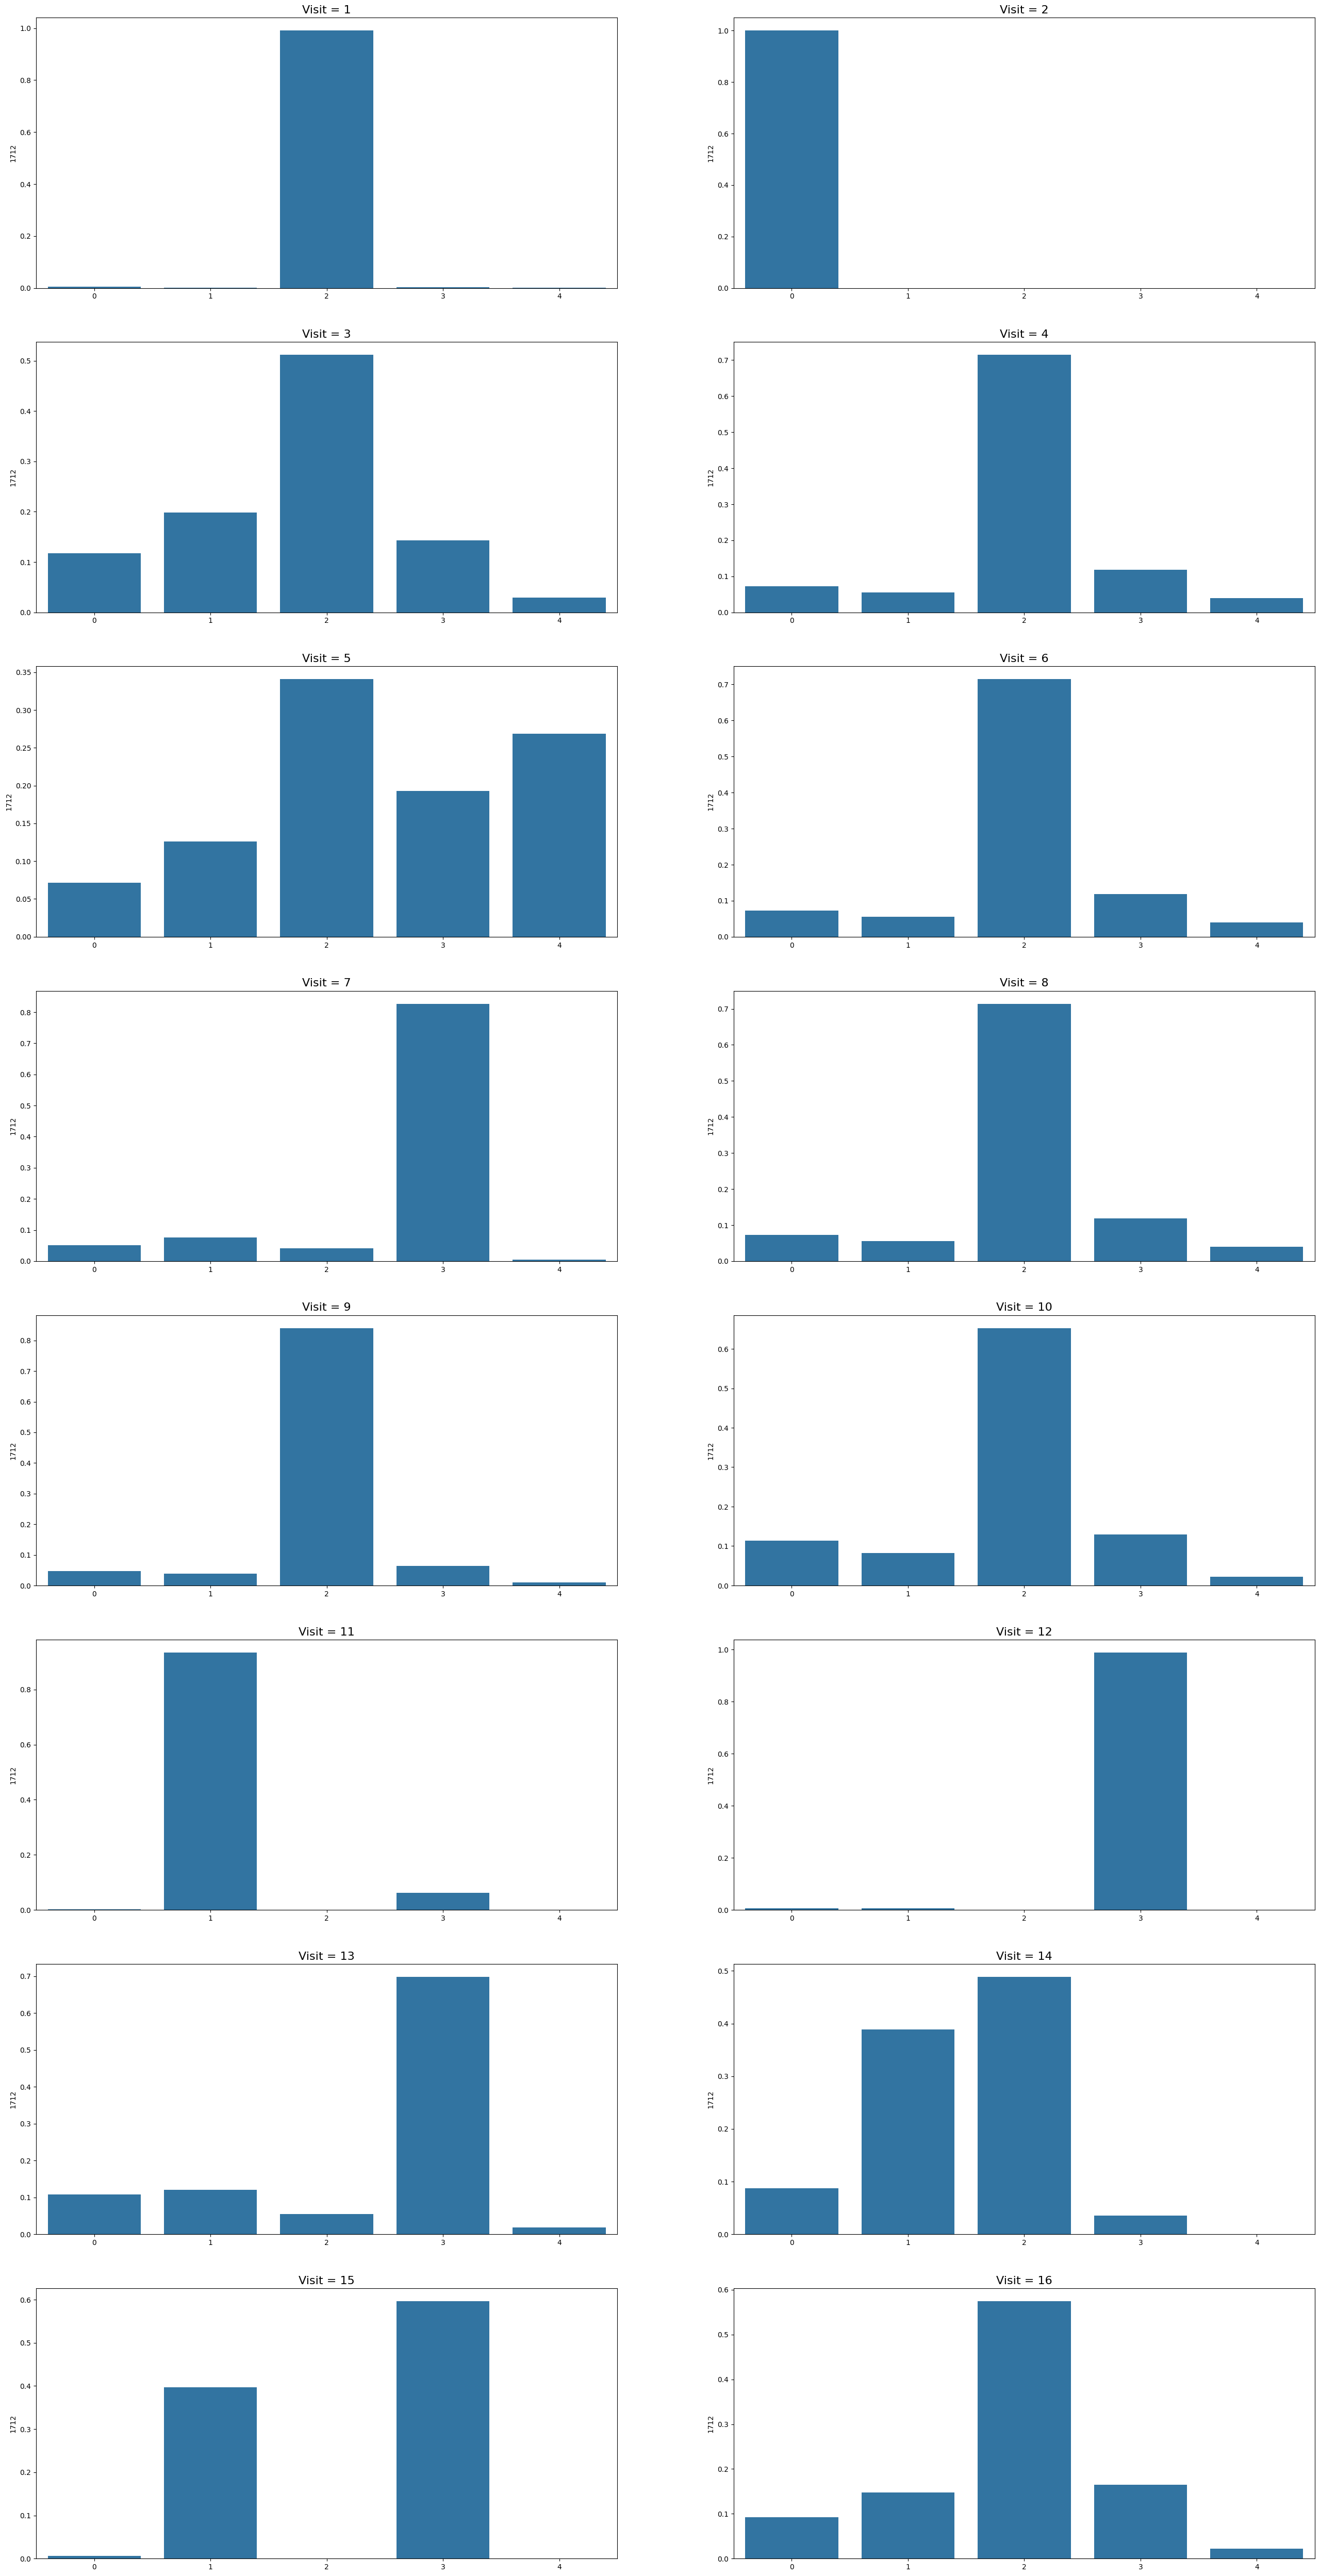

In [70]:
plot_group_clusters_attributions(1712)

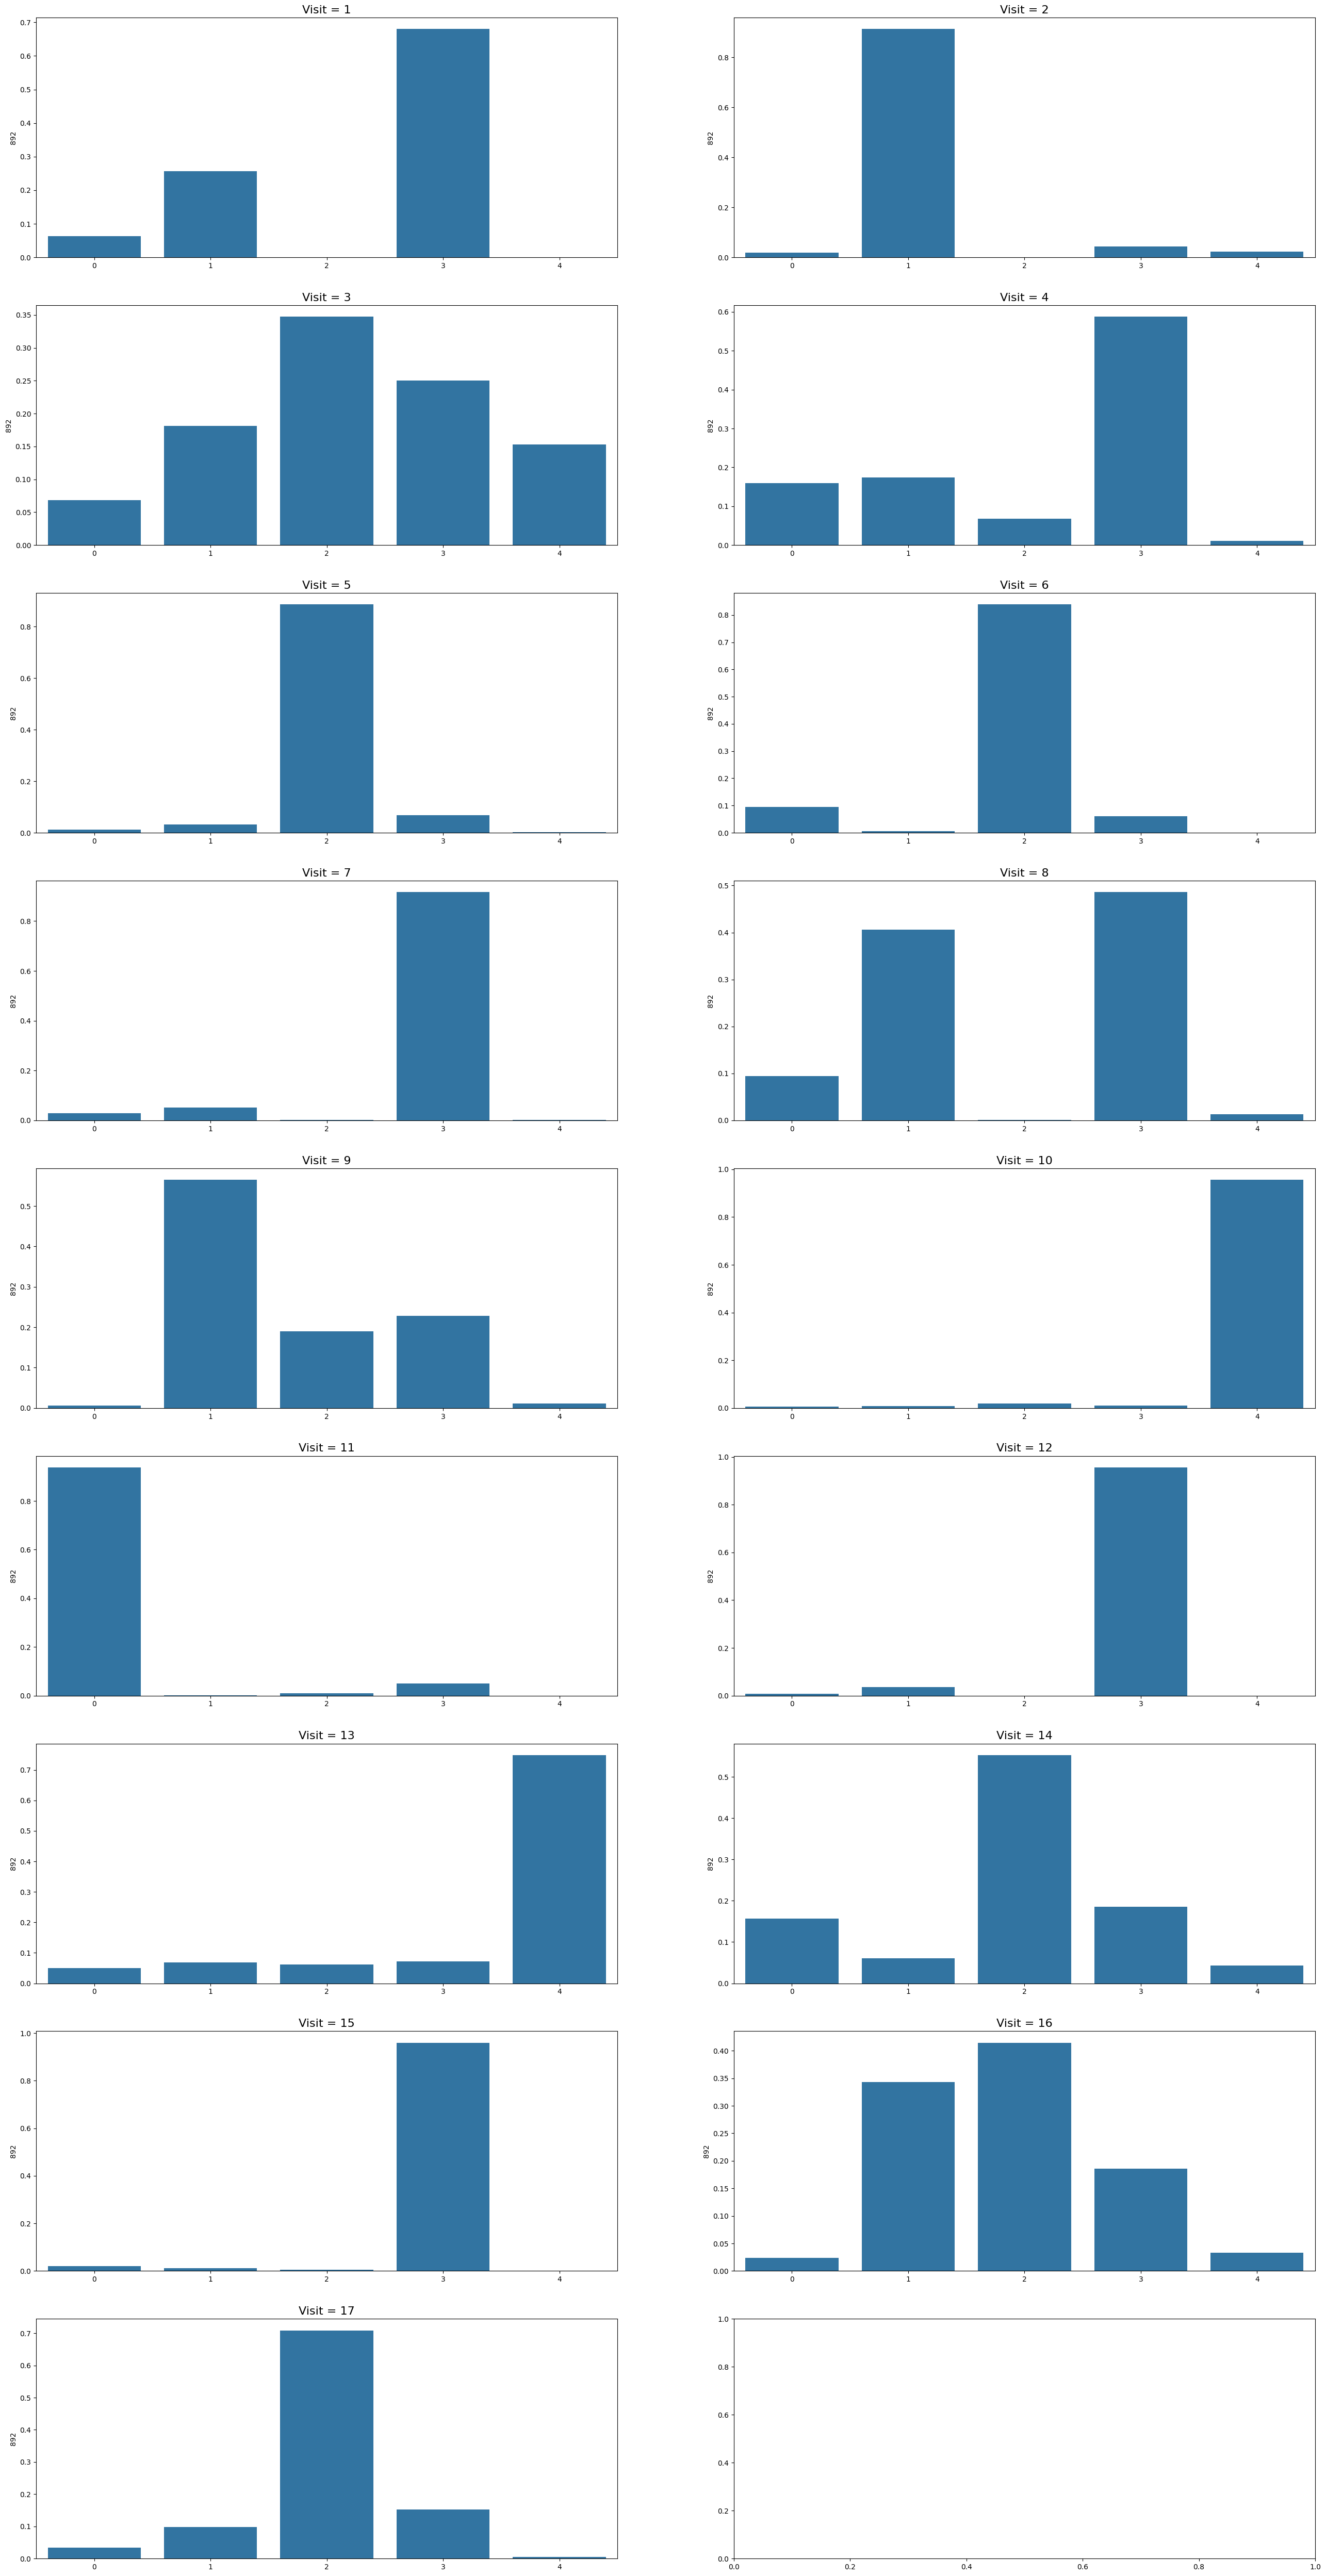

In [71]:
plot_group_clusters_attributions(892)

Individual Model (with existing best param pickle files)

In [28]:
individual_mode = True
Ks = [1, 2, 3, 4, 5] 
#Ks = [6, 8, 10, 15, 30] < for +2 thread (took almost 6 hours with 8 cpu for thread processing)
#more k (mixture components), more time for the program to run, 5 is the max k value with a 1 interval for the k array
params = [(k, X_train, X_test, train_household_ids, test_household_ids, individual_mode) for k in Ks]
p_counts = cpu_count()

In [29]:
with ThreadPool(processes=p_counts) as pool:
    pool.map(process_with_k_mixtures, params)

###################################### Experiment with 1 mixture components ############################################################################ Experiment with 2 mixture components ######################################

###################################### Experiment with 3 mixture components ######################################
###################################### Experiment with 4 mixture components ######################################
###################################### Experiment with 5 mixture components ######################################
iteration 0
iteration 0
iteration 0
iteration 0
iteration 0


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3249760.592988
Loss: -3315344.219733
better loss on iteration 0: -3315344.2197328513
iteration 1


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3211109.652771


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733
Loss: -3179479.514159


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733
iteration 2
Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3203935.656244
Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243952.893945
Loss: -3315344.219733
iteration 3


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3168969.729334
Loss: -3315344.219733
Loss: -3243501.312136
Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733
iteration 4


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243310.963244
better loss on iteration 0: -3243310.9632441956
iteration 1
Loss: -3200849.480219
Loss: -3315344.219733
iteration 5
Loss: -3165986.732927


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3249760.592988


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733
iteration 6


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324
Loss: -3315344.219733
Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164907.534977
Loss: -3315344.219733
iteration 7


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3200125.425373
better loss on iteration 0: -3200125.4253733223
iteration 1
Loss: -3243952.893945
Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3315344.219733
iteration 8


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3243501.312136
Loss: -3139382.664024Loss: -3315344.219733

Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3211109.652771


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3315344.219733
iteration 9


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243310.963244
iteration 2


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3315344.219733


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3315344.219733
Loss: -3203935.656244
log likelihood for k=1 : -885340.794603
bic for k=1 : 3610544.690348
icl bic for k=1 : 3610544.690348
Loss: -3249760.592988
Loss: -3164206.439979
better loss on iteration 0: -3164206.4399790172
iteration 1
Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3245230.602316
Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3179479.514159


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243952.893945


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138406.717426
Loss: -3200849.480219


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3168969.729334
Loss: -3243310.963244
iteration 3
Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3138183.629405
better loss on iteration 0: -3138183.6294046361
iteration 1
Loss: -3249760.592988


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200125.425373
iteration 2
Loss: -3165986.732927
Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3243952.893945
Loss: -3211109.652771
Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3203935.656244


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243310.963244
iteration 4


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164439.768531
Loss: -3144160.636570
Loss: -3201738.806918
Loss: -3249760.592988


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200849.480219


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164206.439979
iteration 2
Loss: -3243952.893945


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3200397.678576
Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3179479.514159


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243310.963244
iteration 5
Loss: -3200125.425373
iteration 3


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3249760.592988
Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3211109.652771
Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3138757.473261
Loss: -3243952.893945
Loss: -3165986.732927
Loss: -3203935.656244


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3201738.806918
Loss: -3243310.963244
iteration 6
Loss: -3164907.534977
Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3249760.592988
Loss: -3200849.480219


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164439.768531
Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200397.678576
Loss: -3138183.629405
iteration 2


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243952.893945


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164206.439979
iteration 3
Loss: -3243501.312136
Loss: -3200125.425373
iteration 4


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3243310.963244
iteration 7
Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3211109.652771
Loss: -3179479.514159
Loss: -3249760.592988


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3203935.656244
Loss: -3245230.602316
Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3168969.729334
Loss: -3243952.893945
Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3165986.732927
Loss: -3140701.205324
Loss: -3200849.480219
Loss: -3243310.963244
iteration 8


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3249760.592988
Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164907.534977
Loss: -3245230.602316


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3200125.425373
iteration 5
Loss: -3243952.893945


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243501.312136


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3211109.652771
Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243310.963244
iteration 9


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164206.439979
iteration 4


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3203935.656244
Loss: -3249760.592988


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3138406.717426
Loss: -3245230.602316
Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3179479.514159


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3243952.893945


c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum 

Loss: -3200849.480219
Loss: -3243501.312136
Loss: -3138183.629405
iteration 3
Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3243310.963244
log likelihood for k=2 : -868081.493943
bic for k=2 : 5415889.190170
icl bic for k=2 : 5387512.258929
Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3165986.732927
Loss: -3156358.017508
Loss: -3200125.425373
iteration 6


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3211109.652771
Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3203935.656244


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164206.439979
iteration 5
Loss: -3200849.480219


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3139382.664024
Loss: -3200397.678576
Loss: -3179479.514159


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3200125.425373
iteration 7
Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3211109.652771


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3165986.732927
Loss: -3203935.656244
Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164907.534977
Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3138183.629405
iteration 4
Loss: -3200849.480219
Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3200397.678576
Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164206.439979
iteration 6
Loss: -3200125.425373
iteration 8


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3179479.514159
Loss: -3144160.636570
Loss: -3211109.652771


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3203935.656244
Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3201738.806918


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3165986.732927
Loss: -3200849.480219
Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3138757.473261
Loss: -3200125.425373
iteration 9
Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3211109.652771
Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3164206.439979
iteration 7
Loss: -3203935.656244


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3179479.514159
Loss: -3201738.806918
Loss: -3138183.629405
iteration 5


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3200849.480219
Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3200397.678576


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3165986.732927
Loss: -3200125.425373


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3144160.636570
log likelihood for k=3 : -858724.026588
bic for k=3 : 7237037.356603
icl bic for k=3 : 7197028.121650
Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3140701.205324
Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3139382.664024Loss: -3164206.439979
iteration 8



c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3179479.514159
Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138406.717426
Loss: -3165986.732927


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3138183.629405
iteration 6
Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3156358.017508
Loss: -3164439.768531


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164206.439979
iteration 9
Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3179479.514159
Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3168969.729334


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3139382.664024
Loss: -3165986.732927


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3138757.473261
Loss: -3164907.534977


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 

Loss: -3164439.768531
Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the stri

Loss: -3164206.439979
log likelihood for k=4 : -850257.114902
bic for k=4 : 9059966.634372
icl bic for k=4 : 9015648.106504
Loss: -3138183.629405
iteration 7


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138183.629405
iteration 8


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138183.629405
iteration 9


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3156358.017508


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3144160.636570


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3140701.205324


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3139382.664024


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138757.473261


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138406.717426


c:\Users\USER\Desktop\Mini Research\multinomial_expectation_maximizer.py:203: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_gamma_sum = gamma_df.groupby(gamma_df.index).apply(sum)
c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Loss: -3138183.629405
log likelihood for k=5 : -845201.390033
bic for k=5 : 10889718.285777
icl bic for k=5 : 10841116.656002


Visualize result for individual model based on best_param_5.p of run_with_gamma2 (Individual param Folder)

In [30]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [73]:
best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open('run_with_gamma2/best_params_5.p', 'rb'))

In [74]:
test_log_likelihood

-845201.3900331992

In [75]:
test_bic

10889718.285776617

## Visualize cluster category probabilities

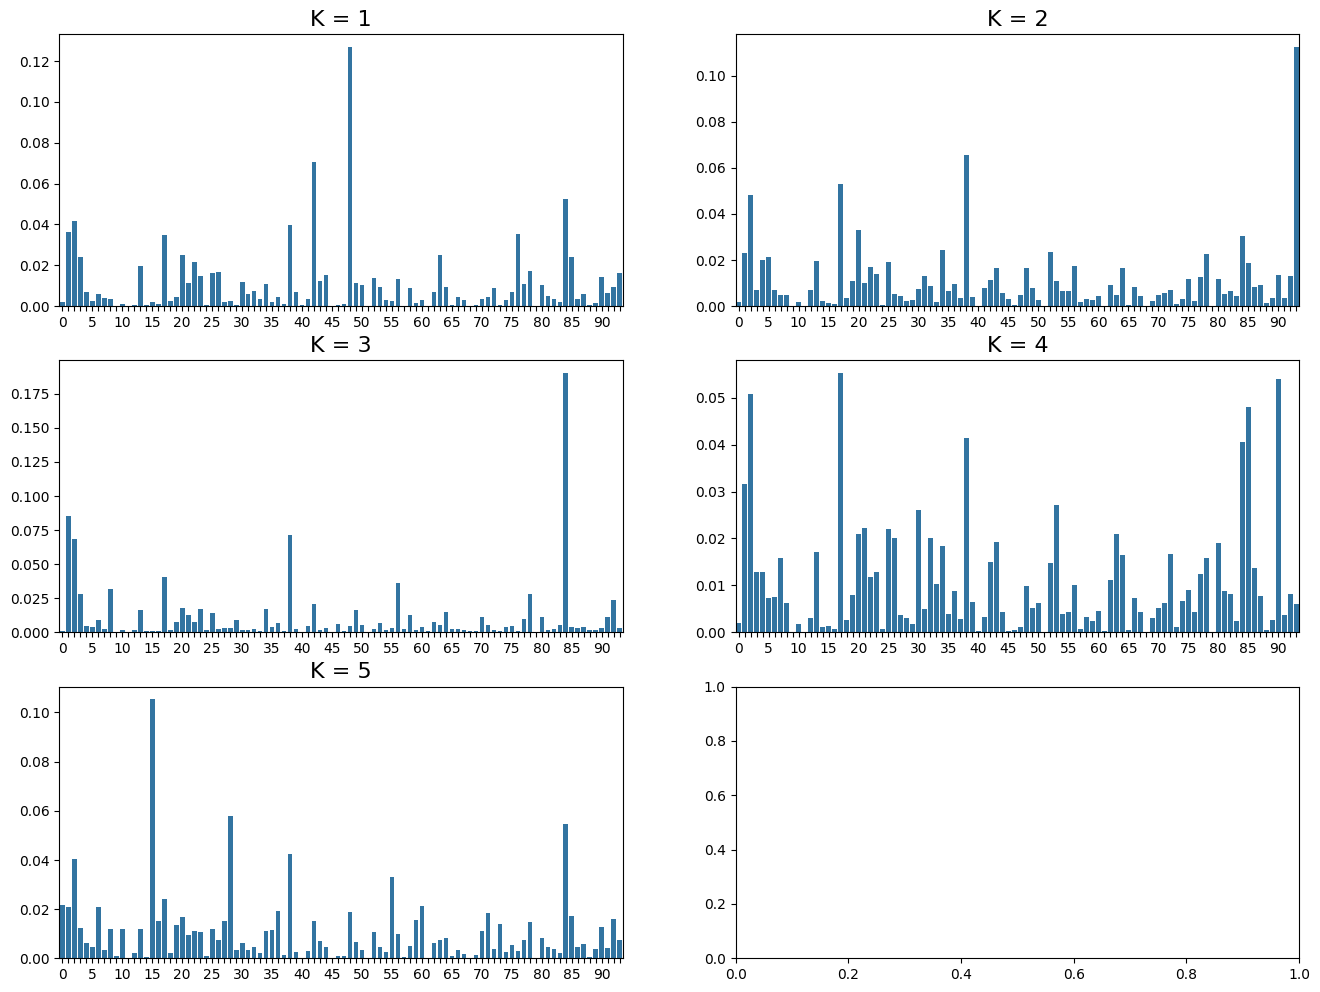

In [76]:
def hide_tick_labels(every_nth, ax):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

K, C = best_beta.shape
n_rows = ((K + 1) // 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16,n_rows*4))
axes = axes.ravel()
for k in range(K):
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[k])
    hide_tick_labels(5, axes[k])
    axes[k].set_title('K = %i' % (k+1), size=16)

## Visualize cluster distances

In [77]:
from sklearn.metrics.pairwise import manhattan_distances

beta_distances = manhattan_distances(best_beta)

In [78]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed')
beta_distances_transformed = embedding.fit_transform(beta_distances)

c:\Users\USER\Desktop\Mini Research\VirtEnv\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, 'Dimension 2')

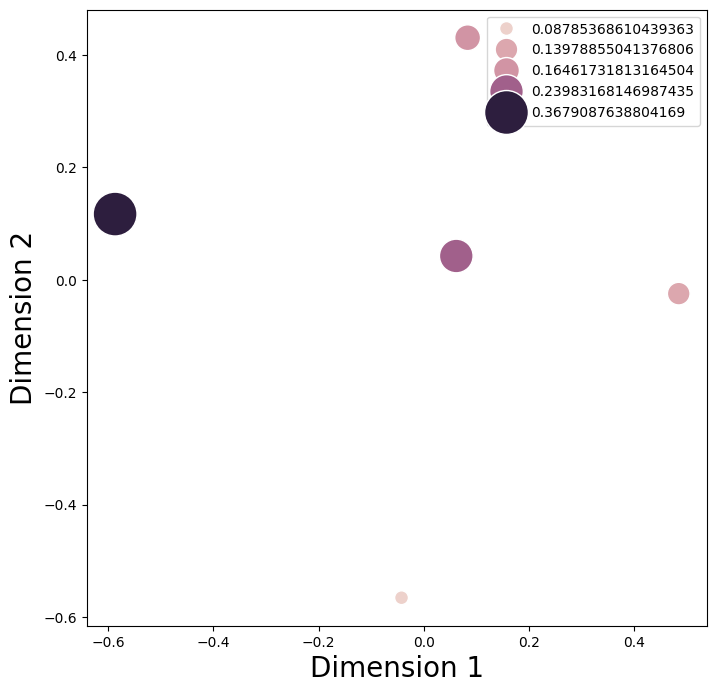

In [79]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=beta_distances_transformed[:, 0], 
                y=beta_distances_transformed[:, 1],
                size=best_alpha.mean(axis=0),
                hue=best_alpha.mean(axis=0),
                sizes=(100, 1000))
ax.set_xlabel('Dimension 1', size=20)
ax.set_ylabel('Dimension 2', size=20)

## Describe clusters by high lift items

In [80]:
train_household_key = train_grocery_df.groupby('BASKET_ID').nth(0)['household_key']
best_gamma_df = pd.DataFrame(best_gamma, index=train_household_key)
best_gamma_df.head()

0         1             2         3             4
household_key                                                              
1172           2.124085e-09  0.311656  3.636016e-07  0.688343  5.277092e-08
718            5.386497e-08  0.006064  9.823337e-01  0.011598  3.807352e-06
1060           1.929117e-07  0.063325  8.806339e-01  0.056014  2.738038e-05
1130           3.920108e-09  0.594023  1.861377e-03  0.403534  5.819999e-04
212            1.072347e-08  0.005146  9.922591e-01  0.002594  9.735910e-07

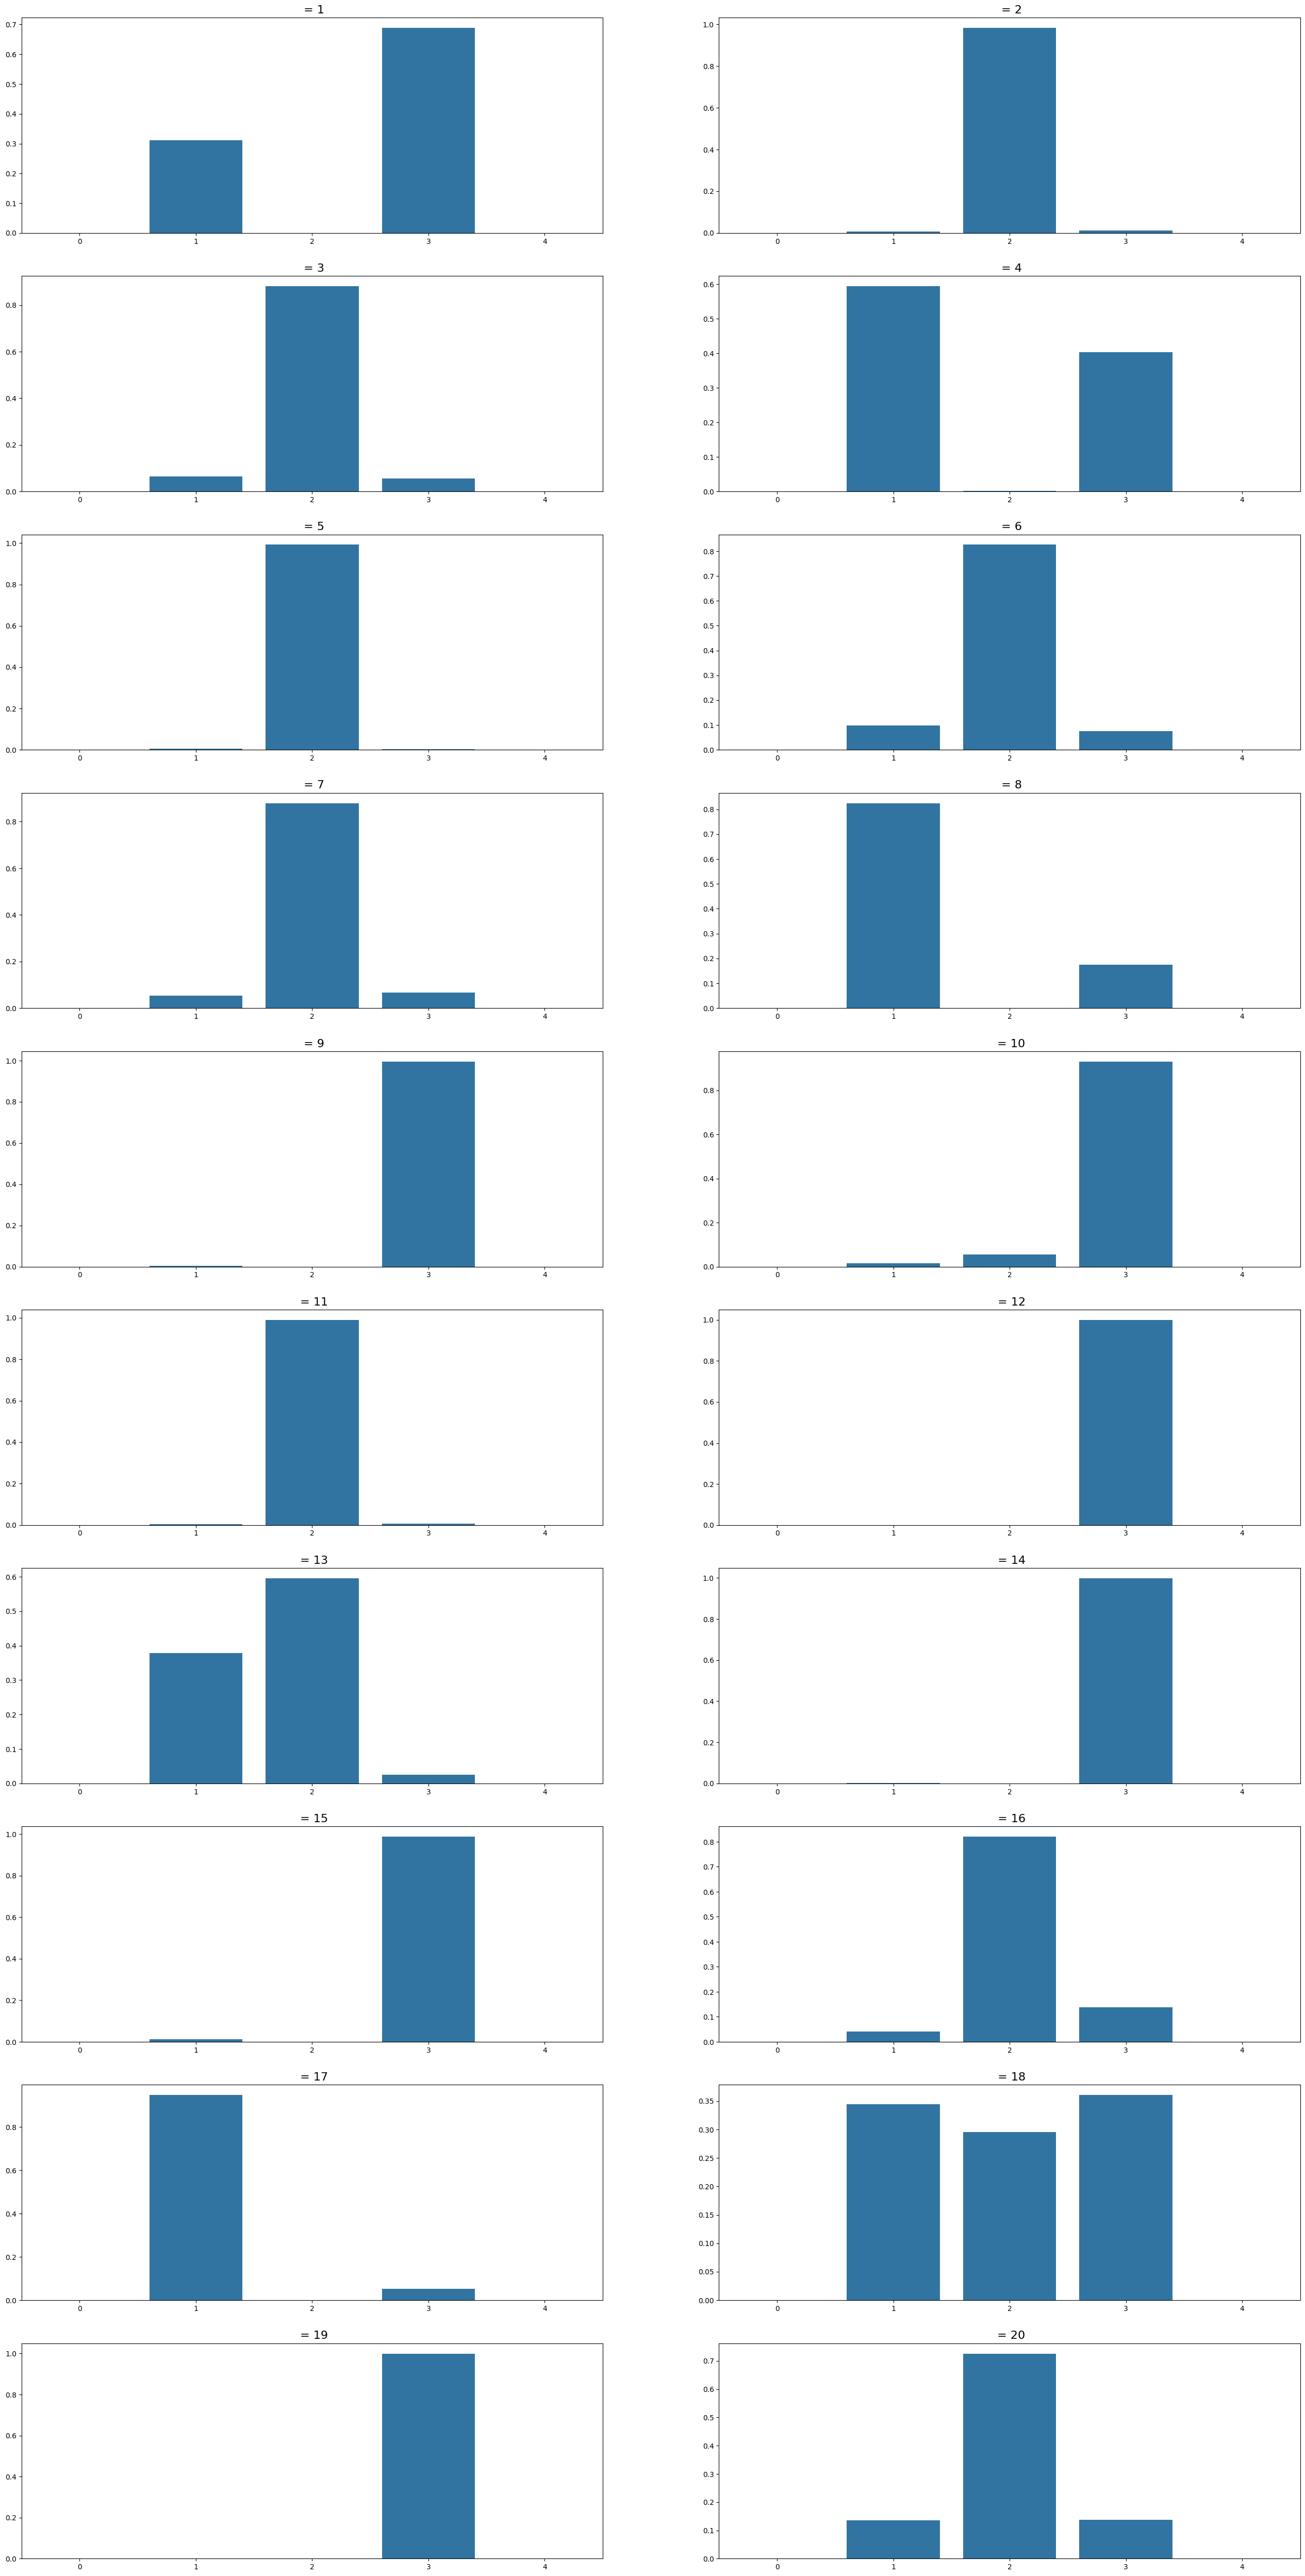

In [81]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(32,64))
for i in range(20):
    sns.barplot(x=list(range(best_gamma.shape[1])), y=best_gamma[i], ax=axes[(i//2)][i%2])
    axes[(i//2)][i%2].set_title(' = %i' % (i+1), size=16)

In [82]:
cluster_weights_by_basket_id = {}
for i, (individual_id, basket_id) in enumerate(train_counts_df.index):
    cluster_weights_by_basket_id[basket_id] = best_gamma[i]

__Compute global product purchase probabilities__

In [83]:
product_counts = train_grocery_df.groupby('PRODUCT_ID')['PRODUCT_ID'].value_counts()
product_purchase_prob = product_counts / len(train_grocery_df)

<Axes: xlabel='count', ylabel='Density'>

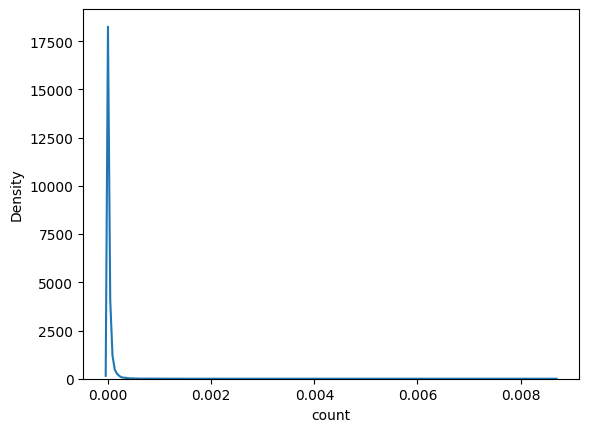

In [84]:
sns.kdeplot(product_purchase_prob)

In [85]:
high_freq_items_prob = product_purchase_prob[product_purchase_prob > 0.0001]
high_freq_items_prob_df = pd.DataFrame(data={'Total purchase prob': high_freq_items_prob})
high_freq_items_prob_df

Total purchase prob
PRODUCT_ID                     
819063                 0.000188
819304                 0.000174
819330                 0.000126
819518                 0.000138
819765                 0.000346
...                         ...
15506577               0.000145
15511891               0.000129
15596279               0.000146
15596488               0.000113
15596515               0.000105

[2119 rows x 1 columns]

In [86]:
total_cluster_weights = best_gamma.sum(axis=0)

products_filepath = 'product.csv'
products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)


def product_prob_for_component(g, k):
    total_product_cluster_weight = 0
    for basket_id in g['BASKET_ID']:
        total_product_cluster_weight += cluster_weights_by_basket_id[basket_id][k]
    return total_product_cluster_weight / total_cluster_weights[k]

def get_high_lift_frequent_items(k):

    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift.join(products_df, how='inner')

In [87]:
cluster_1_high_lift_items_df = get_high_lift_frequent_items(k=0)

In [88]:
cluster_1_high_lift_items_df

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
889779                 0.000132  50.937072           608    GROCERY  National   
968057                 0.000130  50.445018           608    GROCERY  National   
904375                 0.000196  49.793148           608    GROCERY  National   
1041476                0.000144  49.380028           608    GROCERY  National   
887691                 0.000167  49.336025           608    GROCERY  National   
...                         ...        ...           ...        ...       ...   
1088835                0.000358  10.033675            69    GROCERY   Private   
965766                 0.001250  10.027752           317    GROCERY  National   
974108                 0.000487  10.020305           764    GROCERY  National   
13945244               0.000150  10.015473           492    GROCERY  National   
938700                 0.001210  10.010937            69    GROCERY   Private   

                       COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                              
889779         FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
968057         FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
904375         FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
1041476        FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
887691         FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
...                               ...                             ...   
1088835                   SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
965766                         CHEESE               IWS SINGLE CHEESE   
974108               WAREHOUSE SNACKS      CANISTER POTATO/TORT CHIPS   
13945244             MILK BY-PRODUCTS                     REFRIG DIPS   
938700      VEGETABLES - SHELF STABLE                            CORN   

           CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                       
889779                    11 OZ  
968057                   9.4 OZ  
904375                   7.5 OZ  
1041476                10.25 OZ  
887691                    10 OZ  
...                         ...  
1088835                   2 LTR  
965766                    12 OZ  
974108                     6 OZ  
13945244                  16 OZ  
938700                 15.25 OZ  

[914 rows x 8 columns]

In [89]:
cluster_2_high_lift_items_df = get_high_lift_frequent_items(k=1)

In [90]:
cluster_2_high_lift_items_df

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
5588942                0.000153  42.291086            69    GROCERY   Private   
5585735                0.000338  41.811948            69    GROCERY   Private   
5587837                0.000200  41.787708            69    GROCERY   Private   
5586076                0.000200  41.729266            69    GROCERY   Private   
5584007                0.000395  41.675067            69    GROCERY   Private   
...                         ...        ...           ...        ...       ...   
885406                 0.000238  10.101862          1916    GROCERY  National   
909306                 0.000146  10.059359            69    GROCERY   Private   
969205                 0.000130  10.040081           584    GROCERY  National   
5591154                0.000227  10.038741            69    GROCERY   Private   
1047619                0.000167  10.027244           317    GROCERY  National   

                    COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                           
5588942                     YOGURT          YOGURT NOT MULTI-PACKS   
5585735                     YOGURT          YOGURT NOT MULTI-PACKS   
5587837                     YOGURT          YOGURT NOT MULTI-PACKS   
5586076                     YOGURT          YOGURT NOT MULTI-PACKS   
5584007                     YOGURT          YOGURT NOT MULTI-PACKS   
...                            ...                             ...   
885406      BAKED BREAD/BUNS/ROLLS  MEXICAN SOFT TORTILLAS AND WRA   
909306        CRACKERS/MISC BKD FD  SOUP CRACKERS (SALTINE/OYSTER)   
969205                  HOT CEREAL                           GRITS   
5591154       FRUIT - SHELF STABLE             FRUIT BOWL AND CUPS   
1047619     SALD DRSNG/SNDWCH SPRD   SEMI-SOLID SALAD DRESSING MAY   

           CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                       
5588942                    6 OZ  
5585735                    6 OZ  
5587837                    6 OZ  
5586076                    6 OZ  
5584007                    6 OZ  
...                         ...  
885406                    20 OZ  
909306                    12 OZ  
969205                    24 OZ  
5591154                  4/4 OZ  
1047619                   32 OZ  

[625 rows x 8 columns]

__predictive profiles__

In [96]:
test_counts_df.index
test_counts_df.index = test_counts_df.index.droplevel()

Index([40472616886, 40556455611, 40666800522, 40800826610, 40826640752,
       40968886759, 41008476635, 41238565364, 41338185846, 41439966015,
       ...
       41834707283, 41931400464, 41944671450, 42030760622, 42076591133,
       42076591137, 42115225458, 42198526427, 42229520973, 42250641157],
      dtype='int64', name='BASKET_ID', length=43083)

In [97]:
from scipy.special import logsumexp
from scipy.stats import multinomial


best_gamma_df = pd.DataFrame(best_gamma, index=train_household_ids)
best_alpha_df = pd.DataFrame(best_alpha, index=train_household_ids)


def compute_predictive_profile_from_sampling(household_key, complete):
    household_assignments = best_gamma_df[best_gamma_df.index == household_key]
    if len(household_assignments) == 0:
        return 0
    # All assignments are equal, as per the modelization, so we just take the first one
    alpha = best_alpha_df[best_alpha_df.index == household_key].iloc[0]
    
    K, C = best_beta.shape
    n=100
    total = np.zeros((C))
    for i, assignment in household_assignments.iterrows():
        for k in range(K):
            k_samples = alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=n)
            if complete:
                k_samples *= assignment[k]
            total += k_samples.sum(axis=0)
    probs = total / total.sum()
    return probs

    
def compute_household_test_purchase(household_key):
    test_basket_ids=test_grocery_df.loc[test_grocery_df['household_key'] == household_key, 'BASKET_ID'].unique()
    household_test_counts_df = test_counts_df[test_counts_df.index.isin(test_basket_ids)].sum(axis=0)
    return household_test_counts_df / household_test_counts_df.sum()
    
def plot_prediction_vs_reality(household_key, complete=False):
    fig, axes = plt.subplots(nrows=2, figsize=(32,14))
    axes = axes.ravel()
    
    predictive_probs = compute_predictive_profile_from_sampling(household_key, complete)
    sns.barplot(x=np.arange(predictive_probs.size), y=predictive_probs, ax=axes[0])
    axes[0].set_title('Purchases probabilities prediction for household %s' % str(household_key), size=20)
    axes[0].set_xlabel('Categories', size=20)
    axes[0].set_ylabel('Probability', size=20)
    
    test_probs = compute_household_test_purchase(household_key)
    sns.barplot(x=np.arange(test_probs.size), y=test_probs, ax=axes[1])
    axes[1].set_title('Purchases from the test set for household %s' % str(household_key), size=20)
    axes[1].set_xlabel('Categories', size=20)
    axes[1].set_ylabel('Probability', size=20)

    l1_distance = np.abs(predictive_probs - test_probs).sum()
    plt.text(0.5, -0.25, 'L1 distance between prediction and test data: %.3f' % l1_distance,
             horizontalalignment='center', verticalalignment='center', transform = axes[1].transAxes, size=30)

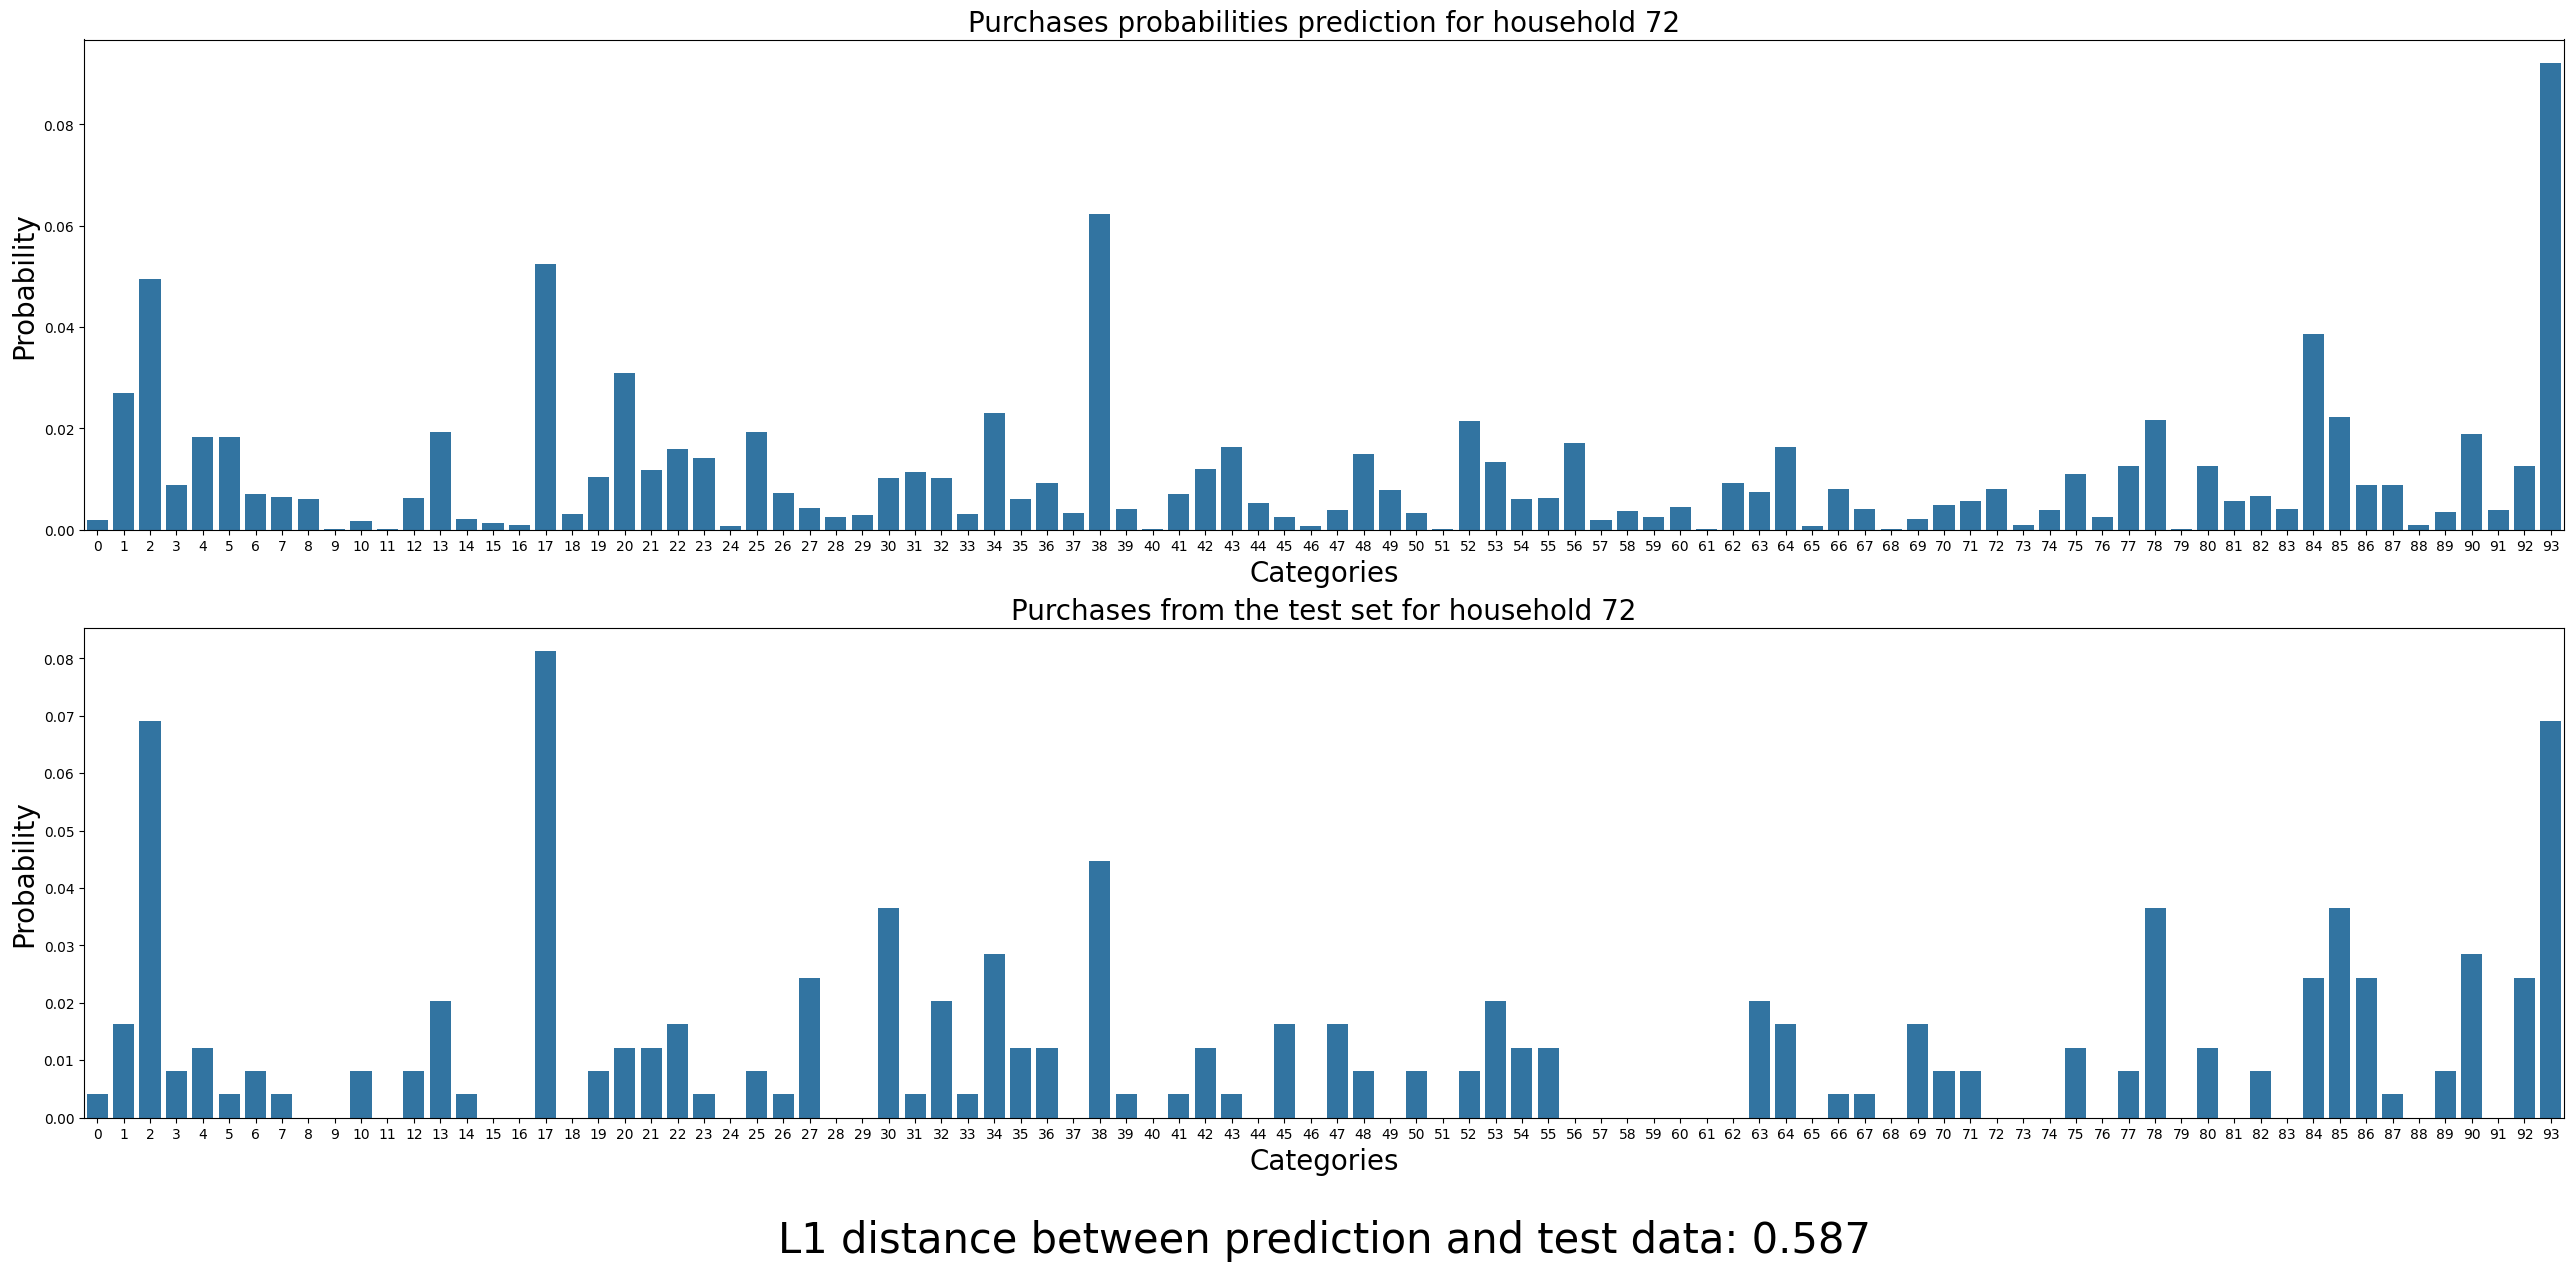

In [98]:
plot_prediction_vs_reality(72, complete=True)

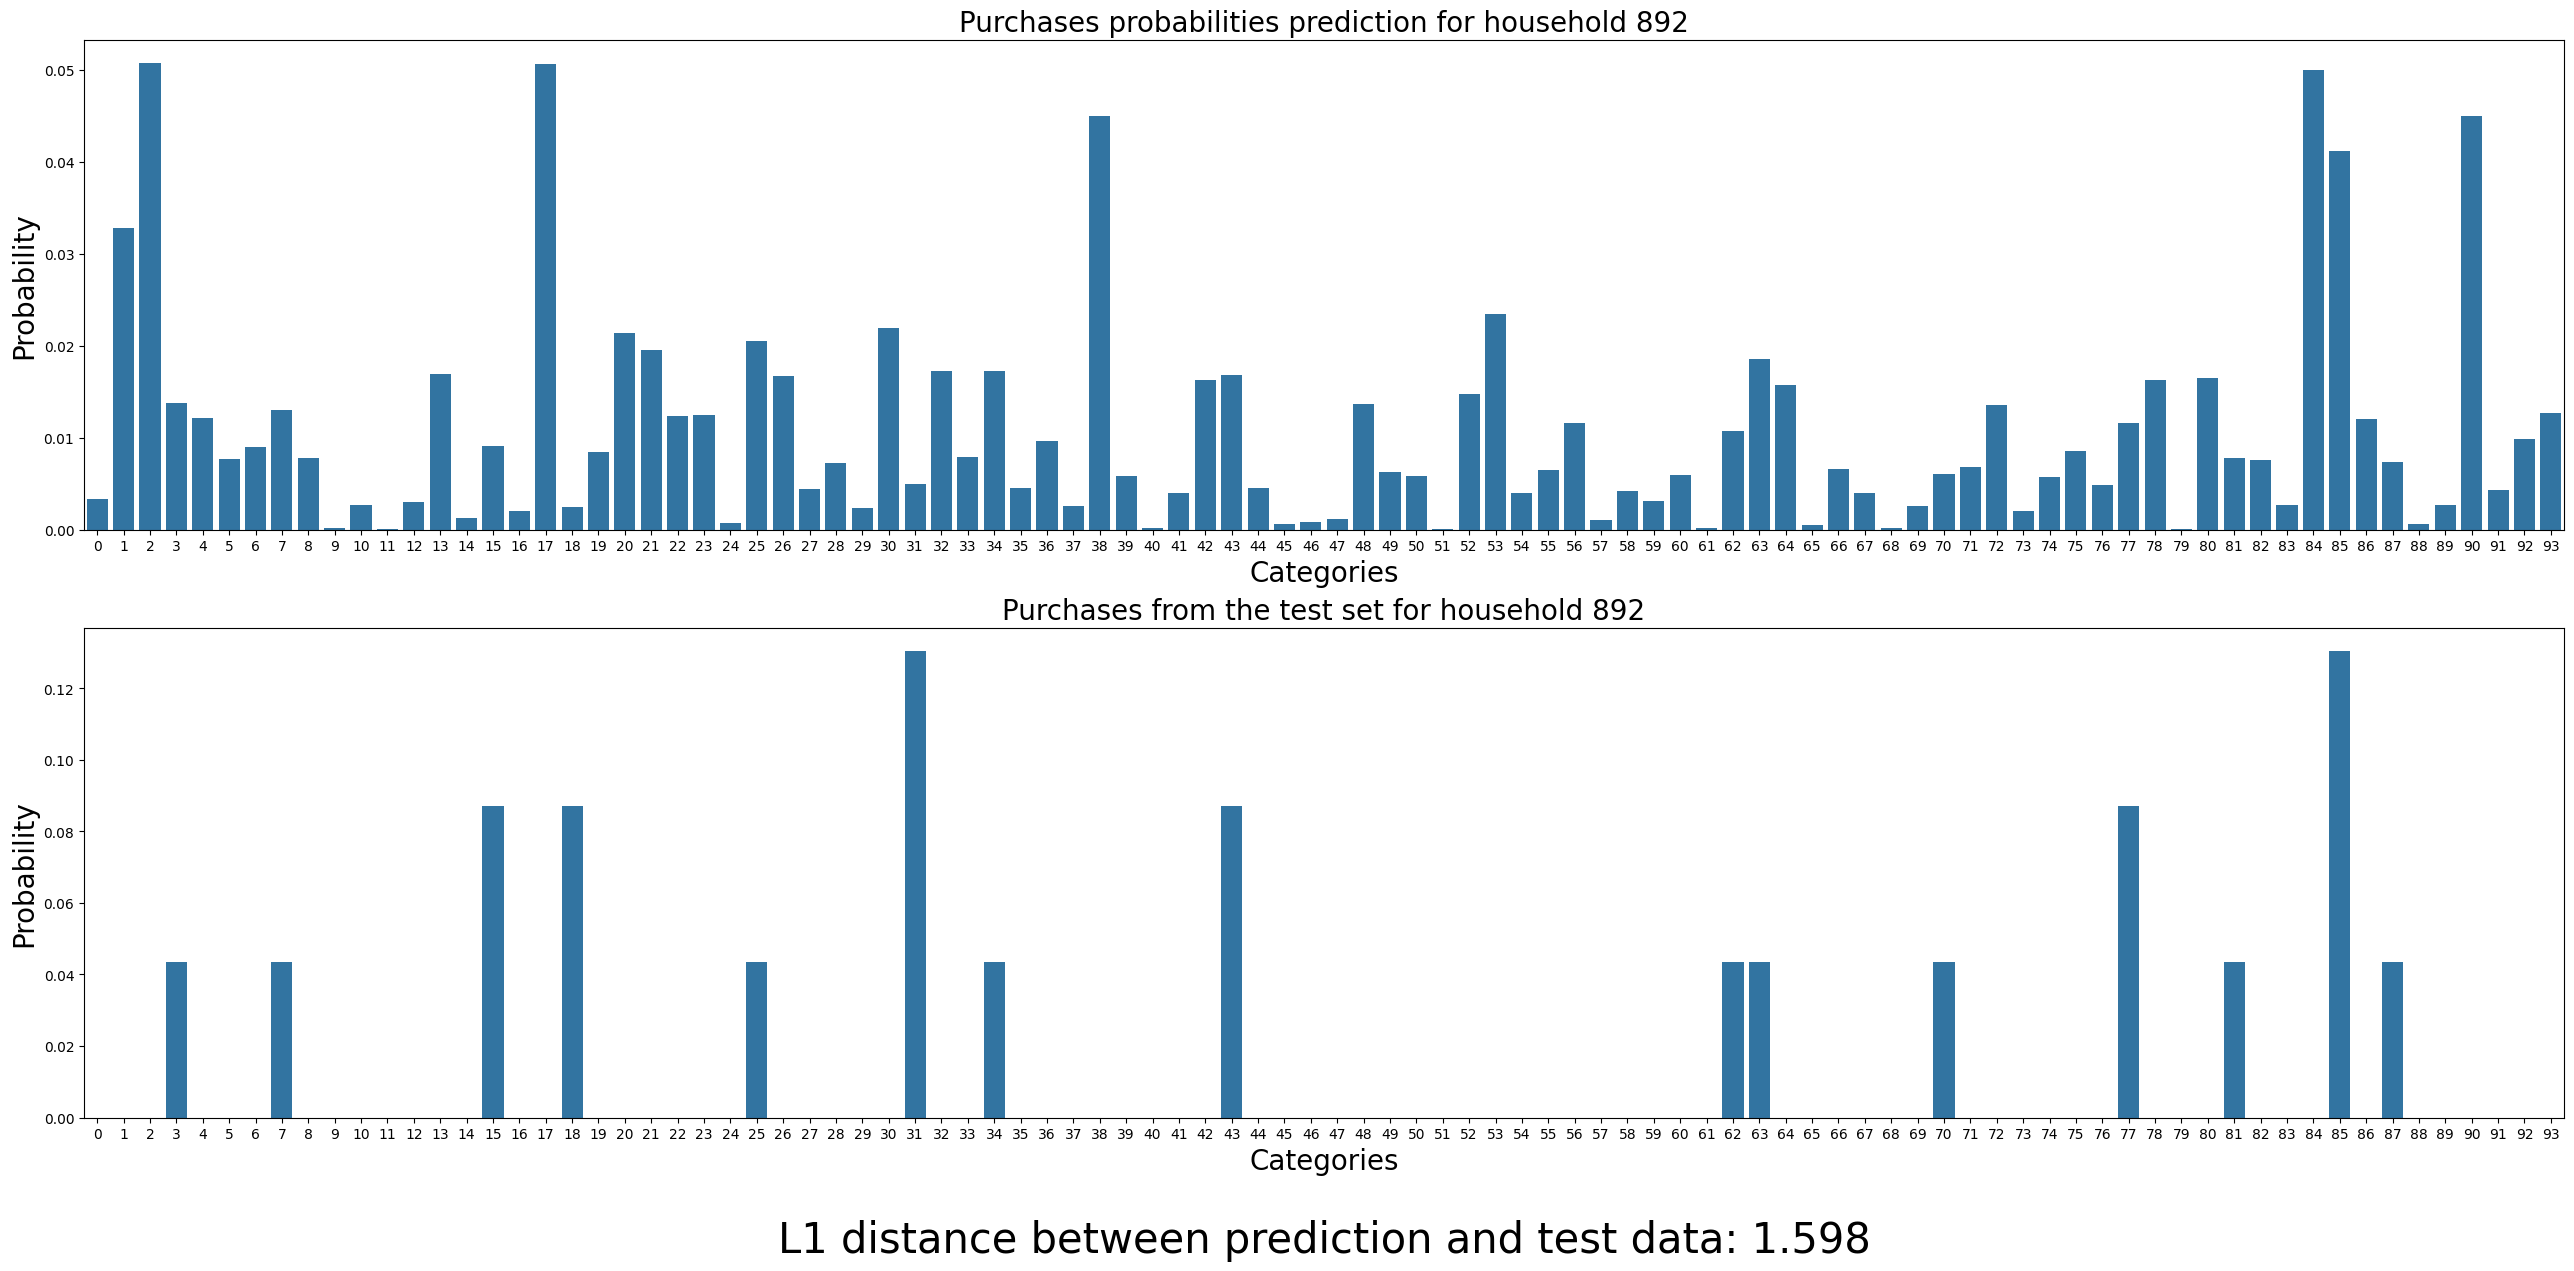

In [99]:
plot_prediction_vs_reality(892, complete=True)

In [100]:
from tqdm import tqdm

unique_test_household_ids = test_grocery_df['household_key'].unique()
predictions_distances = {}
for household_id in tqdm(unique_test_household_ids):
    predictive_probs = compute_predictive_profile_from_sampling(household_id, True)
    test_probs = compute_household_test_purchase(household_id)
    l1_distance = np.abs(predictive_probs - test_probs).sum()
    predictions_distances[household_id] = l1_distance

100%|██████████| 2361/2361 [11:18<00:00,  3.48it/s]


In [101]:
global_predictions_distances = pickle.load(open('predictions_distances.p', 'rb'))

C:\Users\USER\AppData\Local\Temp\ipykernel_16892\444051981.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = predictions_distances[household_id] / global_dist


Text(0, 0.5, 'Error with individuals model')

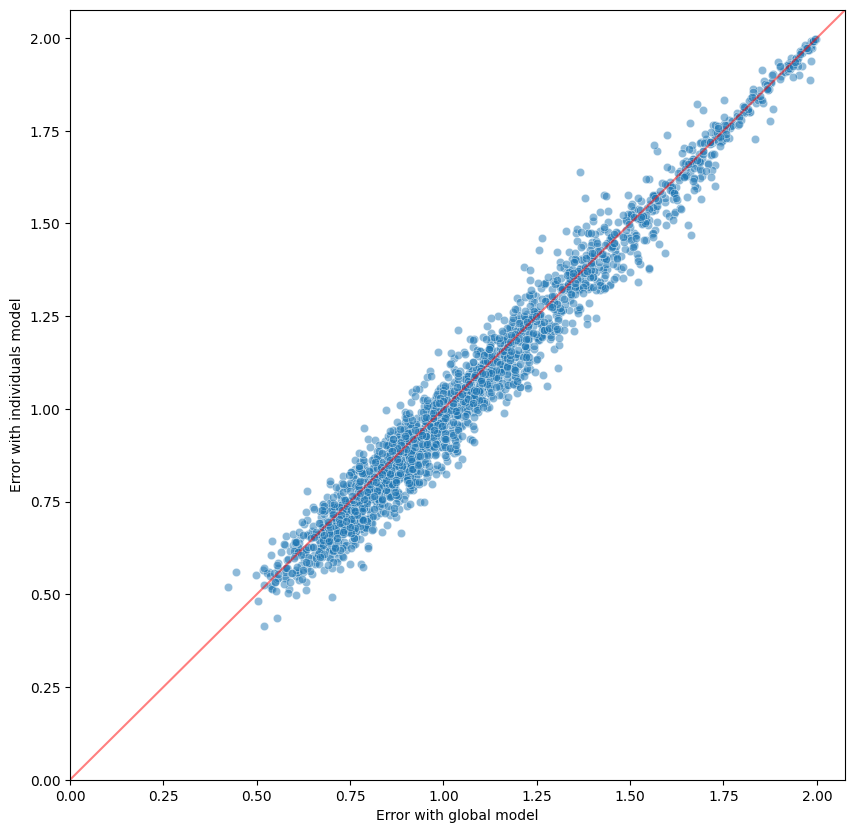

In [102]:
import matplotlib.lines as lines

distances = np.zeros((len(global_predictions_distances), len(global_predictions_distances)))

best_prediction_household_id = None
prev_ratio = float('inf')
for i, (household_id, global_dist) in enumerate(global_predictions_distances.items()):
    distances[i, 0] = global_dist
    distances[i, 1] = predictions_distances[household_id]
    ratio = predictions_distances[household_id] / global_dist
    if ratio < prev_ratio:
        prev_ratio = ratio
        best_prediction_household_id = household_id
distances = distances[distances[:, 0] > 0]

plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=distances[:, 0], y=distances[:, 1], alpha=0.5)
ax.set_ybound(0)
ax.set_xbound(0)
l = lines.Line2D([0, 2.1], [0, 2.1], linestyle='-', color='red', alpha=0.5)
ax.add_line(l)
ax.set_xlabel('Error with global model')
ax.set_ylabel('Error with individuals model')

In [103]:
(((distances[:, 0] - distances[:, 1]) > 0).sum() / distances.shape[0]) * 100

63.61323155216285